# LoanTap Logistic Regression
### Context:

- A Non-Banking Finance Company like LoanTap is an online platform committed to delivering customized loan products to millennials.
- They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

- The data science team is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

- Company deploys formal credit to salaried individuals and businesses 4 main financial instruments:

    - Personal Loan
    - EMI Free Loan
    - Personal Overdraft
    - Advance Salary Loan

- This case study will focus on the underwriting process behind Personal Loan only

## Problem Statement:

- Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

####  Tradeoff Questions:

- How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

- Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone

## Data dictionary:

1. loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. term : The number of payments on the loan. Values are in months and can be either 36 or 60.
3. int_rate : Interest Rate on the loan
4. installment : The monthly payment owed by the borrower if the loan originates.
5. grade : Institution assigned loan grade
6. sub_grade : Institution assigned loan subgrade
7. emp_title :The job title supplied by the Borrower when applying for the loan.*
8. emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
9. home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
10. annual_inc : The self-reported annual income provided by the borrower during registration.
11. verification_status : Indicates if income was verified by Institution, not verified, or if the income source was verified
12. issue_d : The month which the loan was funded
13. loan_status : Current status of the loan - Target Variable
14. purpose : A category provided by the borrower for the loan request.
15. title : The loan title provided by the borrower
16. dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested Institution loan, divided by the borrower’s self-reported monthly income.
17. earliest_cr_line :The month the borrower's earliest reported credit line was opened
18. open_acc : The number of open credit lines in the borrower's credit file.
19. pub_rec : Number of derogatory public records
20. revol_bal : Total credit revolving balance
21. revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
22. total_acc : The total number of credit lines currently in the borrower's credit file
23. initial_list_status : The initial listing status of the loan. Possible values are – W, F
24. application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
25. mort_acc : Number of mortgage accounts.
26. pub_rec_bankruptcies : Number of public record bankruptcies
27. Address: Address of the individual









In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import t
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import missingno as msno

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab


In [ ]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]
mon_to_int = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
grade_to_int = {'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
sub_grade_to_int = {'A1':35, 'A2':34, 'A3':33, 'A4':32, 'A5':31,
                    'B1':30, 'B2':29, 'B3':28, 'B4':27, 'B5':26,
                    'C1':25, 'C2':24, 'C3':23, 'C4':22, 'C5':21,
                    'D1':20, 'D2':19, 'D3':18, 'D4':17, 'D5':16,
                    'E1':15, 'E2':14, 'E3':13, 'E4':12, 'E5':11,
                    'F1':10, 'F2':9, 'F3':8, 'F4':7, 'F5':6,
                    'G1':5, 'G2':4, 'G3':3, 'G4':2, 'G5':1}
emp_len_to_int = {'10+ years': 10, '4 years': 4, '< 1 year': 0, '6 years': 6, '9 years': 9, '2 years': 2,
                  '3 years': 3, '8 years': 8, '7 years': 7, '5 years': 5, '1 year': 1, 'nan': np.nan}


In [ ]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<5:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<5:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [ ]:
def remove_outlier(df_in, col_name, thresh=5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= thresh/100:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

In [ ]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv?1651045921")

In [ ]:
df.head()

loan_amnt        term  int_rate  installment grade sub_grade                emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status             purpose                    title    dti earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status application_type  mort_acc  pub_rec_bankruptcies                                            address
0    10000.0   36 months     11.44       329.48     B        B4                Marketing  10+ years           RENT    117000.0        Not Verified  Jan-2015   Fully Paid            vacation                 Vacation  26.24         Jun-1990      16.0      0.0    36369.0        41.8       25.0                   w       INDIVIDUAL       0.0                   0.0     0174 Michelle Gateway\r\nMendozaberg, OK 22690
1     8000.0   36 months     11.99       265.68     B        B5          Credit analyst     4 years       MORTGAGE     65000.0        Not Verified  Jan-2015   Fully Paid  debt_consolidation       Debt consolidation  22.05         Jul-2004      17.0      0.0    20131.0        53.3       27.0                   f       INDIVIDUAL       3.0                   0.0  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    15600.0   36 months     10.49       506.97     B        B3             Statistician   < 1 year           RENT     43057.0     Source Verified  Jan-2015   Fully Paid         credit_card  Credit card refinancing  12.79         Aug-2007      13.0      0.0    11987.0        92.2       26.0                   f       INDIVIDUAL       0.0                   0.0  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3     7200.0   36 months      6.49       220.65     A        A2          Client Advocate    6 years           RENT     54000.0        Not Verified  Nov-2014   Fully Paid         credit_card  Credit card refinancing   2.60         Sep-2006       6.0      0.0     5472.0        21.5       13.0                   f       INDIVIDUAL       0.0                   0.0            823 Reid Ford\r\nDelacruzside, MA 00813
4    24375.0   60 months     17.27       609.33     C        C5  Destiny Management Inc.    9 years       MORTGAGE     55000.0            Verified  Apr-2013  Charged Off         credit_card    Credit Card Refinance  33.95         Mar-1999      13.0      0.0    24584.0        69.8       43.0                   f       INDIVIDUAL       1.0                   0.0             679 Luna Roads\r\nGreggshire, VA 11650

## 1. Analysing Basic Metrics

In [ ]:
df.shape

(396030, 27)

- 396030 data points , 26 features , 1 label.

### 1.1 Missing Values Check:

In [ ]:
def missing_df(data):
    total_missing_df = data.isna().sum().sort_values(ascending = False)
    percentage_missing_df = ((data.isna().sum()/len(data)*100)).sort_values(ascending = False)
    missingDF = pd.concat([total_missing_df, percentage_missing_df],axis = 1, keys=['Total', 'Percent'])
    return missingDF


missing_data = missing_df(df)
missing_data[missing_data["Total"]>0]


Total   Percent
mort_acc              37795  9.543469
emp_title             22927  5.789208
emp_length            18301  4.621115
title                  1755  0.443148
pub_rec_bankruptcies    535  0.135091
revol_util              276  0.069692

In [ ]:
from tabulate import tabulate
df.columns
# Finding Unique values from all columns in dataset
print("\nTotal unique values", end ='\n\n')
df_dict = {}
col = []
total_count = []
for i in df.columns:
    col.append(i)
    total_count.append(df[i].nunique())
df_dict = {'Column Names':col, 'Total count of Unique records':total_count}
print(tabulate(df_dict, headers='keys', tablefmt='fancy_grid',showindex =range(1,df.shape[1]+1)))


Total unique values

╒════╤══════════════════════╤═════════════════════════════════╕
│    │ Column Names         │   Total count of Unique records │
╞════╪══════════════════════╪═════════════════════════════════╡
│  1 │ loan_amnt            │                            1397 │
├────┼──────────────────────┼─────────────────────────────────┤
│  2 │ term                 │                               2 │
├────┼──────────────────────┼─────────────────────────────────┤
│  3 │ int_rate             │                             566 │
├────┼──────────────────────┼─────────────────────────────────┤
│  4 │ installment          │                           55706 │
├────┼──────────────────────┼─────────────────────────────────┤
│  5 │ grade                │                               7 │
├────┼──────────────────────┼─────────────────────────────────┤
│  6 │ sub_grade            │                              35 │
├────┼──────────────────────┼─────────────────────────────────┤
│  7 │ emp_title  

In [ ]:
df.duplicated().sum()

0

In [ ]:
(df.isna().sum() / df.shape[0] ) * 100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

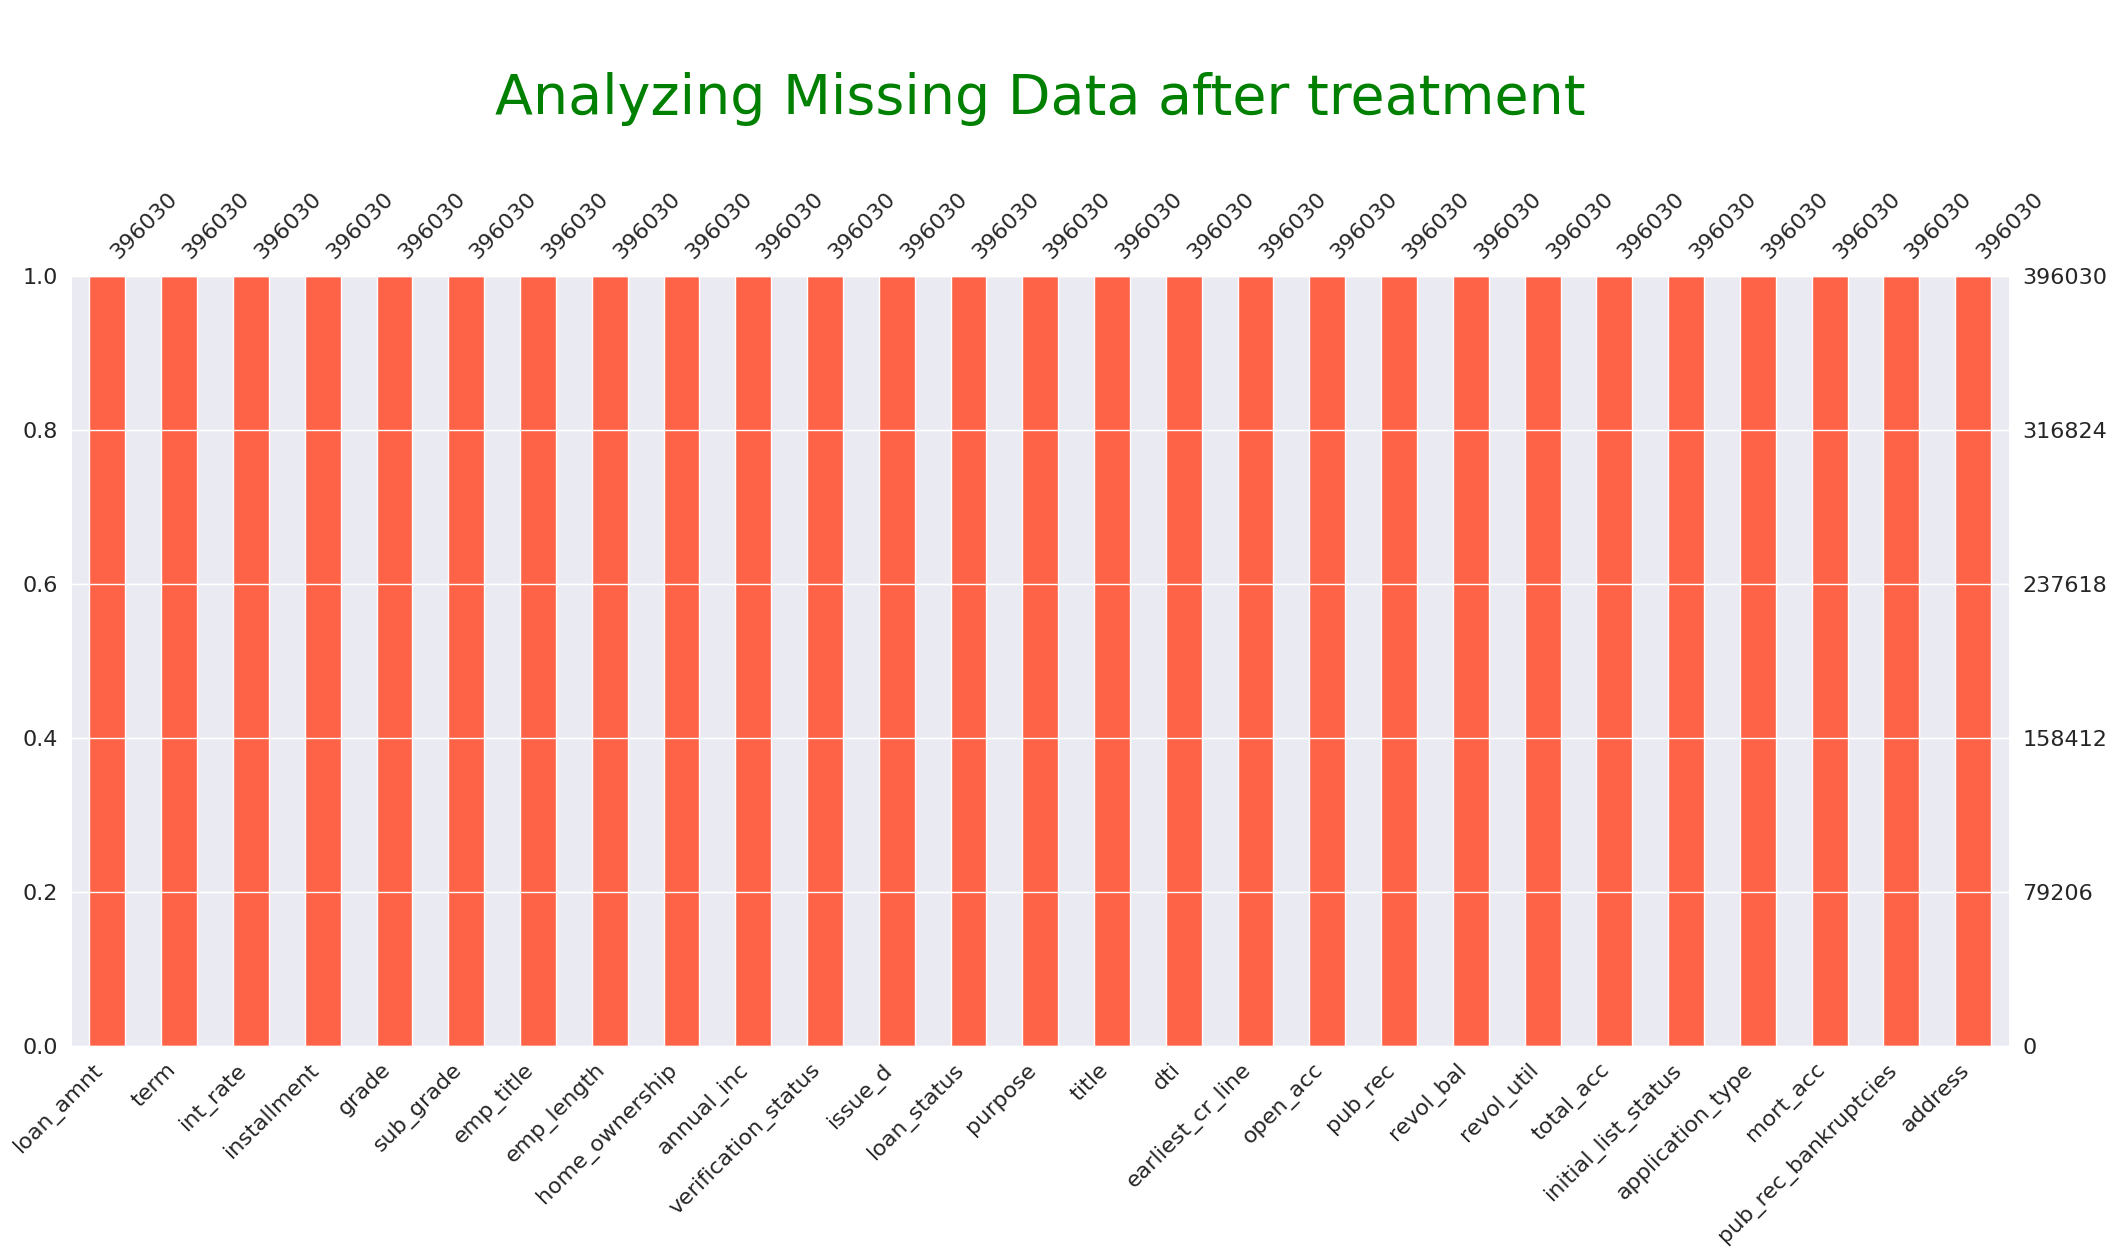

In [ ]:
values = {"emp_title": 'Unknown', "emp_length": '< 1 year', "title": 'Unknown', "revol_util": 0, 'mort_acc': 0, 'pub_rec_bankruptcies': 0}
df = df.fillna(value=values)
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data after treatment\n", fontsize=40, color="green")
plt.show()

### 1.2 Descriptive Statistics :

In [ ]:
df.describe().round(1)

loan_amnt  int_rate  installment  annual_inc       dti  open_acc   pub_rec  revol_bal  revol_util  total_acc  mort_acc  pub_rec_bankruptcies
count   396030.0  396030.0     396030.0    396030.0  396030.0  396030.0  396030.0   396030.0    396030.0   396030.0  396030.0              396030.0
mean     14113.9      13.6        431.8     74203.2      17.4      11.3       0.2    15844.5        53.8       25.4       1.6                   0.1
std       8357.4       4.5        250.7     61637.6      18.0       5.1       0.5    20591.8        24.5       11.9       2.1                   0.4
min        500.0       5.3         16.1         0.0       0.0       0.0       0.0        0.0         0.0        2.0       0.0                   0.0
25%       8000.0      10.5        250.3     45000.0      11.3       8.0       0.0     6025.0        35.8       17.0       0.0                   0.0
50%      12000.0      13.3        375.4     64000.0      16.9      10.0       0.0    11181.0        54.8       24.0       1.0                   0.0
75%      20000.0      16.5        567.3     90000.0      23.0      14.0       0.0    19620.0        72.9       32.0       3.0                   0.0
max      40000.0      31.0       1533.8   8706582.0    9999.0      90.0      86.0  1743266.0       892.3      151.0      34.0                   8.0

- **Loan Amount, Installments, Annual Income , revol_bal** : all these columns have large differnece in mean and median . That means outliers are present in the data.

In [ ]:
df.nunique()

loan_amnt                 1397
term                         2
int_rate                   566
installment              55706
grade                        7
sub_grade                   35
emp_title               173106
emp_length                  11
home_ownership               6
annual_inc               27197
verification_status          3
issue_d                    115
loan_status                  2
purpose                     14
title                    48817
dti                       4262
earliest_cr_line           684
open_acc                    61
pub_rec                     20
revol_bal                55622
revol_util                1226
total_acc                  118
initial_list_status          2
application_type             3
mort_acc                    33
pub_rec_bankruptcies         9
address                 393700
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             396030 non-null  object 
 7   emp_length            396030 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 396030 non-null  object 
 15  

## 2. Feature Creation and Feature Transformation.

In [ ]:
columns_type = df.dtypes

In [ ]:
columns_type[columns_type=="object"]

term                   object
grade                  object
sub_grade              object
emp_title              object
emp_length             object
home_ownership         object
verification_status    object
issue_d                object
loan_status            object
purpose                object
title                  object
earliest_cr_line       object
initial_list_status    object
application_type       object
address                object
dtype: object

In [ ]:
df.describe(include="object")

term   grade sub_grade emp_title emp_length home_ownership verification_status   issue_d loan_status             purpose               title earliest_cr_line initial_list_status application_type                      address
count       396030  396030    396030    396030     396030         396030              396030    396030      396030              396030              396030           396030              396030           396030                       396030
unique           2       7        35    173106         11              6                   3       115           2                  14               48817              684                   2                3                       393700
top      36 months       B        B3   Unknown  10+ years       MORTGAGE            Verified  Oct-2014  Fully Paid  debt_consolidation  Debt consolidation         Oct-2000                   f       INDIVIDUAL  USCGC Smith\r\nFPO AE 70466
freq        302005  116018     26655     22927     126041         198348              139563     14846      318357              234507              152472             3017              238066           395319                            8

In [ ]:
len(columns_type[columns_type=="object"])

15

- 15 Non-numerical (categorical/date time) features present in the dataset.

In [ ]:
for column in ['term', 'grade', 'sub_grade', 'emp_length', 'issue_d', 'earliest_cr_line', 'emp_title', 'address']:
    print(f"\nUnique values in {column} column are: ", df[column].unique()[:30])


Unique values in term column are:  [' 36 months' ' 60 months']

Unique values in grade column are:  ['B' 'A' 'C' 'E' 'D' 'F' 'G']

Unique values in sub_grade column are:  ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1']

Unique values in emp_length column are:  ['10+ years' '4 years' '< 1 year' '6 years' '9 years' '2 years' '3 years'
 '8 years' '7 years' '5 years' '1 year']

Unique values in issue_d column are:  ['Jan-2015' 'Nov-2014' 'Apr-2013' 'Sep-2015' 'Sep-2012' 'Oct-2014'
 'Apr-2012' 'Jun-2013' 'May-2014' 'Dec-2015' 'Apr-2015' 'Oct-2012'
 'Jul-2014' 'Feb-2013' 'Oct-2015' 'Jan-2014' 'Mar-2016' 'Apr-2014'
 'Jun-2011' 'Apr-2010' 'Jun-2014' 'Oct-2013' 'May-2013' 'Feb-2015'
 'Oct-2011' 'Jun-2015' 'Aug-2013' 'Feb-2014' 'Dec-2011' 'Mar-2013']

Unique values in earliest_cr_line column are:  ['Jun-1990' 'Jul-2004' 'Aug-2007' 'Sep-2006' 'Mar-1999' 'Jan-2005'
 'Aug-2005' 'Sep-1994' 'Jun

In [ ]:
df["loan_status"].value_counts(normalize=True)*100

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

- As we can see, there is an imbalance in the data.
> 80% belongs to the class 0 : which is loan fully paid.  
> 20% belongs to the class 1 : which were charged off.

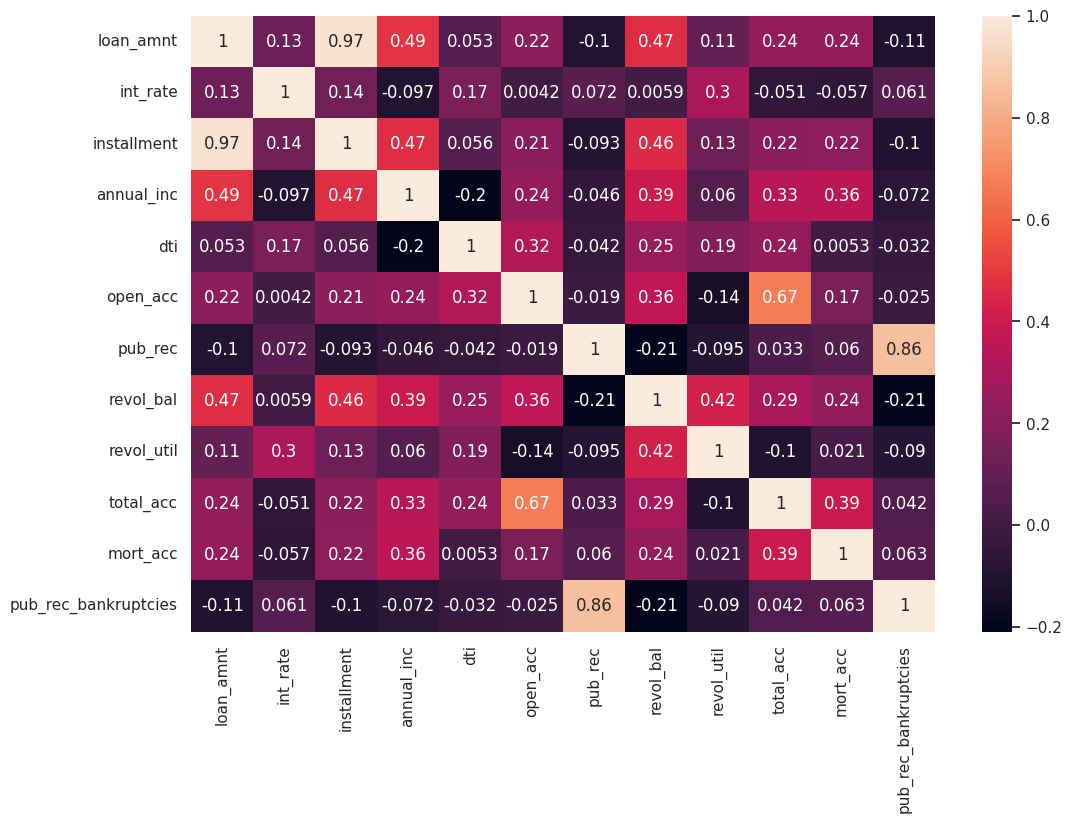

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True)
plt.show()

### 2.1 loan_amnt :

- The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


In [ ]:
df.groupby(by = "loan_status")["loan_amnt"].describe()

count          mean          std     min     25%      50%      75%      max
loan_status                                                                                
Charged Off   77673.0  15126.300967  8505.090557  1000.0  8525.0  14000.0  20000.0  40000.0
Fully Paid   318357.0  13866.878771  8302.319699   500.0  7500.0  12000.0  19225.0  40000.0

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

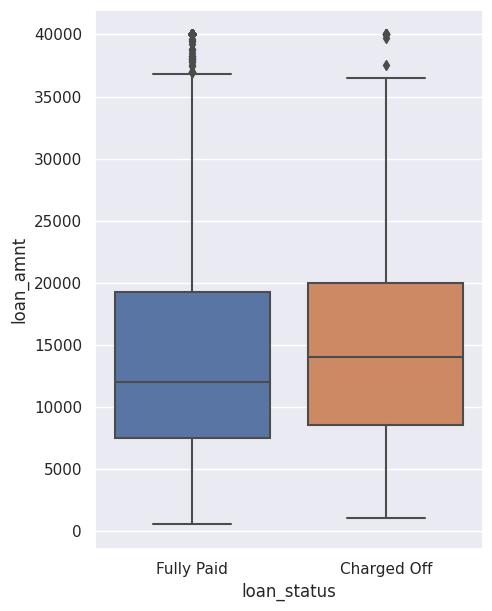

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y=df["loan_amnt"],
            x=df["loan_status"])

<Axes: xlabel='loan_amnt', ylabel='Count'>

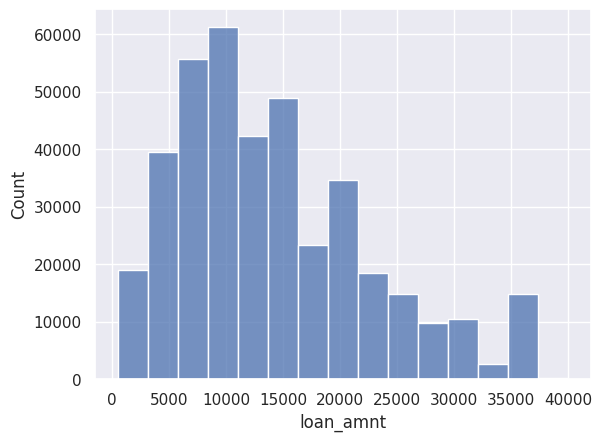

In [ ]:
sns.histplot(df["loan_amnt"],bins = 15)

- For loan status Charged_off, the mean and median of loan_amount is higher than fully paid.
- Also the distribution of loan_amnt is right skewed, which says it has outlier presence.


### 2.2 term :

- #### The number of payments on the loan. Values are in months and can be either 36 or 60.


In [ ]:
df["term"].value_counts(dropna=False)

 36 months    302005
 60 months     94025
Name: term, dtype: int64

  P[loan_status | term]

In [ ]:
pd.crosstab(index=df["term"],
            columns=df["loan_status"], normalize="index" , margins  = True
           ) * 100

loan_status  Charged Off  Fully Paid
term                                
 36 months     15.774573   84.225427
 60 months     31.941505   68.058495
All            19.612908   80.387092

<Axes: xlabel='term'>

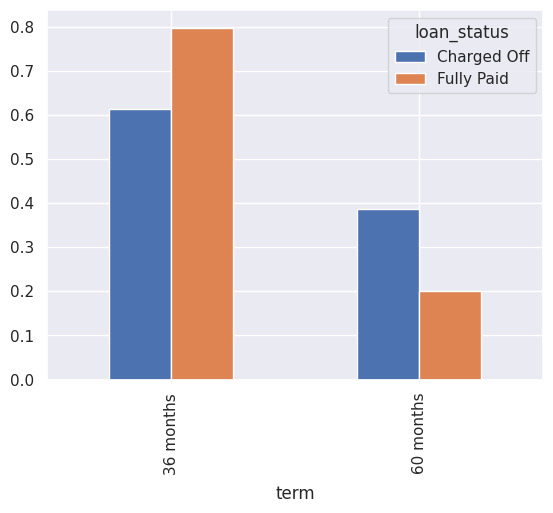

In [ ]:
pd.crosstab(index=df["term"],
            columns =df["loan_status"], normalize="columns"
           ).plot(kind = "bar")

**Observation**
- The conditional probability of loan fully paid given that its 36 month term is higher then charged off.  

- The loan fully paid probability when 60 month term is lower than charged off.

In [ ]:
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df['term'].map(term_values)


### 2.3 int_rate: **Interest Rate on the loan**


In [ ]:
df.groupby(by = "loan_status")["int_rate"].describe()

count       mean       std   min    25%    50%    75%    max
loan_status                                                                 
Charged Off   77673.0  15.882587  4.388135  5.32  12.99  15.61  18.64  30.99
Fully Paid   318357.0  13.092105  4.319105  5.32   9.91  12.99  15.61  30.99

<Axes: xlabel='int_rate', ylabel='Count'>

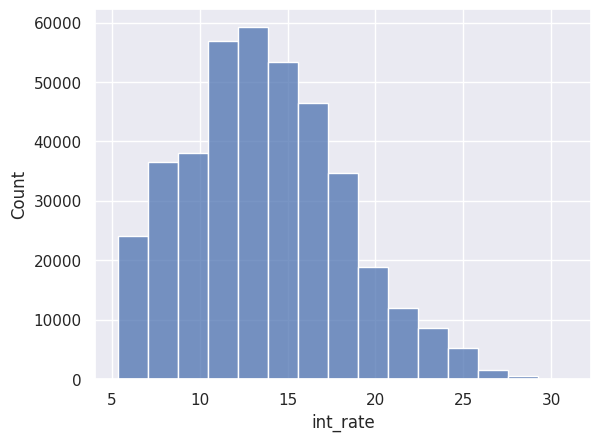

In [ ]:
sns.histplot(df["int_rate"],bins = 15)

<Axes: xlabel='int_rate', ylabel='loan_status'>

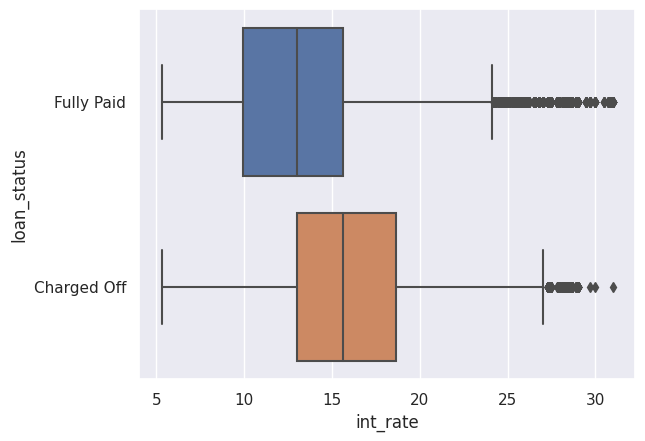

In [ ]:
sns.boxplot(x=df["int_rate"],
            y=df["loan_status"])

In [ ]:
df[df["loan_status"] == "Charged Off"]["int_rate"].median(),df[df["loan_status"] == "Charged Off"]["int_rate"].mean()


(15.61, 15.882587256833133)

In [ ]:
df[df["loan_status"] == "Fully Paid"]["int_rate"].median(),df[df["loan_status"] == "Fully Paid"]["int_rate"].mean()

(12.99, 13.092105403682032)

**Observation**
- For charge_off Loan Status, interest_rate median and mean is higher than fully paid.

- Also the distribution of interest_rate is right skewed, which says it has outlier presence.


### 2.4 grade :

- LoanTap assigned loan grade

- Loan grades are set based on both the borrower's credit profile and the nature of the contract.


<Axes: >

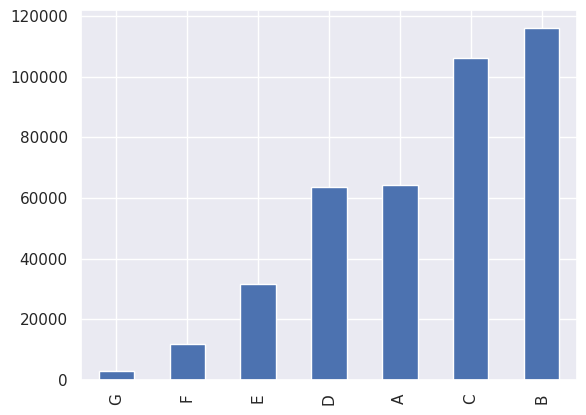

In [ ]:
df["grade"].value_counts().sort_values().plot(kind = "bar")

In [ ]:
df["grade"].value_counts(dropna=False)

B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: grade, dtype: int64

In [ ]:
pd.crosstab(index = df["grade"],
            columns= df["loan_status"],normalize= "index", margins = True)

loan_status  Charged Off  Fully Paid
grade                               
A               0.062879    0.937121
B               0.125730    0.874270
C               0.211809    0.788191
D               0.288678    0.711322
E               0.373634    0.626366
F               0.427880    0.572120
G               0.478389    0.521611
All             0.196129    0.803871

<Axes: xlabel='grade'>

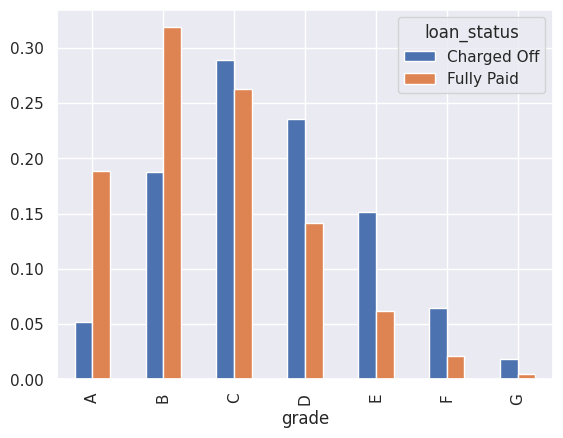

In [ ]:
pd.crosstab(index = df["grade"],
            columns= df["loan_status"],normalize= "columns").plot(kind  = "bar")

- The probability of loan_status as fully_paid decreases with grade is E,F,G

**Observation**

- we can conclude the relationship exists
between loan_status and LoanTap assigned loan grade.

### 2.5 sub_grade : **LoanTap assigned loan subgrade**


<Axes: xlabel='sub_grade'>

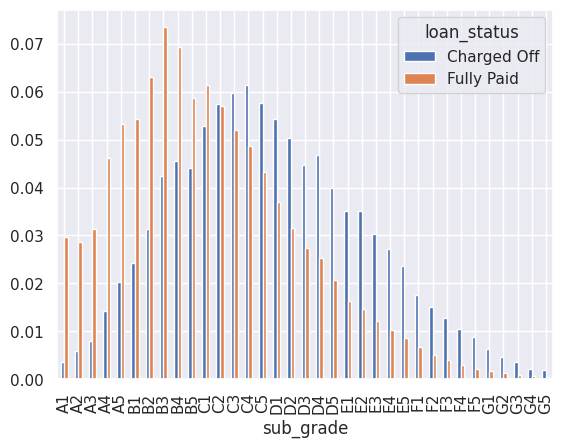

In [ ]:
pd.crosstab(index = df["sub_grade"],
            columns= df["loan_status"],normalize= "columns", ).plot(kind = "bar")

- Similar pattern is observed for sub_grade as grade.
- later target encoding will be done

### 2.6 emp_title : **The job title supplied by the Borrower when applying for the loan.**


In [ ]:
df["emp_title"].value_counts(dropna=False).sort_values(ascending=False).head(15)

Unknown             22927
Teacher              4389
Manager              4250
Registered Nurse     1856
RN                   1846
Supervisor           1830
Sales                1638
Project Manager      1505
Owner                1410
Driver               1339
Office Manager       1218
manager              1145
Director             1089
General Manager      1074
Engineer              995
Name: emp_title, dtype: int64

In [ ]:
df["emp_title"].nunique()

173106

**Observation**

- The missing values need to be treated with model based imputation .
- The total unique job_titles are 173,105.
- The target encoding while creating model.

### 2.7 emp_length: **Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years**


In [ ]:
df["emp_length"].value_counts(dropna=False)

10+ years    126041
< 1 year      50026
2 years       35827
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

In [ ]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status  Charged Off  Fully Paid
emp_length                          
1 year         19.913453   80.086547
10+ years      18.418610   81.581390
2 years        19.326206   80.673794
3 years        19.523133   80.476867
4 years        19.238477   80.761523
5 years        19.218721   80.781279
6 years        18.919438   81.080562
7 years        19.477400   80.522600
8 years        19.976002   80.023998
9 years        20.047016   79.952984
< 1 year       23.189941   76.810059
All            19.612908   80.387092

<Axes: xlabel='emp_length'>

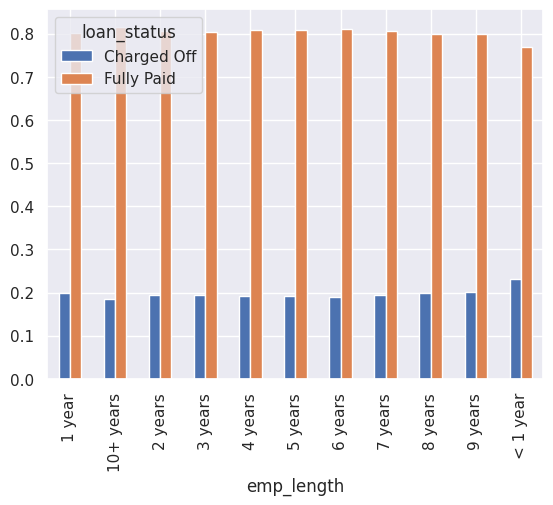

In [ ]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

Visually there doesn't seems to be much correlation between employement length
and loan_status.

In [ ]:
stats.chi2_contingency(pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"]))

Chi2ContingencyResult(statistic=538.3018503631934, pvalue=2.8542293620802177e-109, dof=10, expected_freq=array([[  5076.21287781,  20805.78712219],
       [ 24720.30551473, 101320.69448527],
       [  7026.71658965,  28800.28341035],
       [  6210.42735399,  25454.57264601],
       [  4697.68375123,  19254.31624877],
       [  5196.44000455,  21298.55999545],
       [  4087.52617983,  16753.47382017],
       [  4083.21134005,  16735.78865995],
       [  3759.4022271 ,  15408.5977729 ],
       [  3003.52074843,  12310.47925157],
       [  9811.55341262,  40214.44658738]]))

### 2.8  home_ownership : **The home ownership status provided by the borrower during registration or obtained from the credit report.**


In [ ]:
df["home_ownership"].value_counts(dropna=False)

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [ ]:
df["home_ownership"] = df["home_ownership"].replace({"NONE":"OTHER", "ANY":"OTHER"})

In [ ]:
pd.crosstab(index = df["home_ownership"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status     Charged Off  Fully Paid
home_ownership                         
MORTGAGE          16.956057   83.043943
OTHER             15.753425   84.246575
OWN               20.680337   79.319663
RENT              22.662244   77.337756
All               19.612908   80.387092

<Axes: xlabel='home_ownership'>

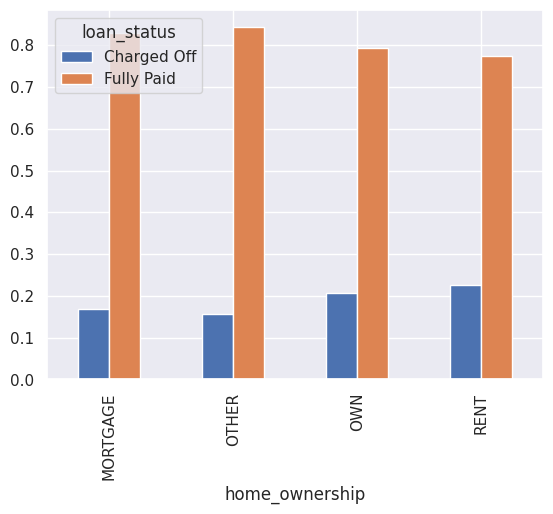

In [ ]:
pd.crosstab(index = df["home_ownership"],
            columns= df["loan_status"],normalize= "index").plot(kind= "bar")

Visually there doent seems to be much correlation between home_ownership and loan_status.  
Later target encoding or label encoding .

### 2.9 annual_inc :**The self-reported annual income provided by the borrower during registration.**


<Axes: xlabel='annual_inc', ylabel='Density'>

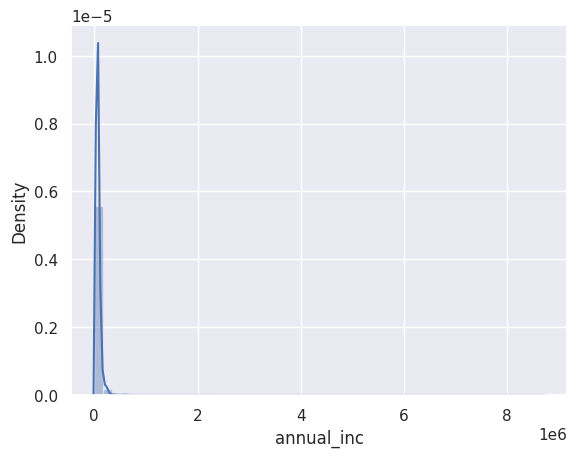

In [ ]:
sns.distplot(df["annual_inc"])

In [ ]:
df["annual_inc"].describe()

count    3.960300e+05
mean     7.420318e+04
std      6.163762e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

<Axes: xlabel='annual_inc', ylabel='Density'>

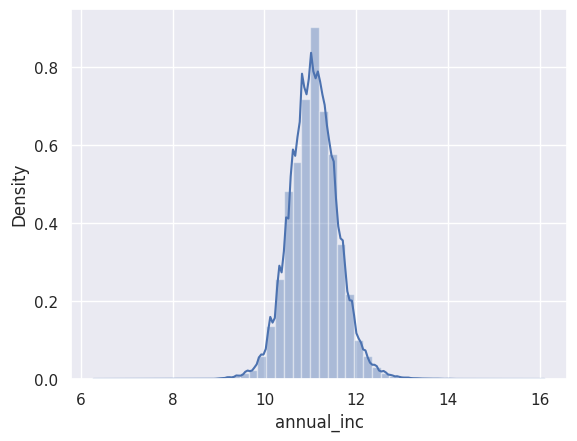

In [ ]:
sns.distplot(np.log(df[df["annual_inc"]>0]["annual_inc"]))

<Axes: xlabel='loan_status', ylabel='annual_inc'>

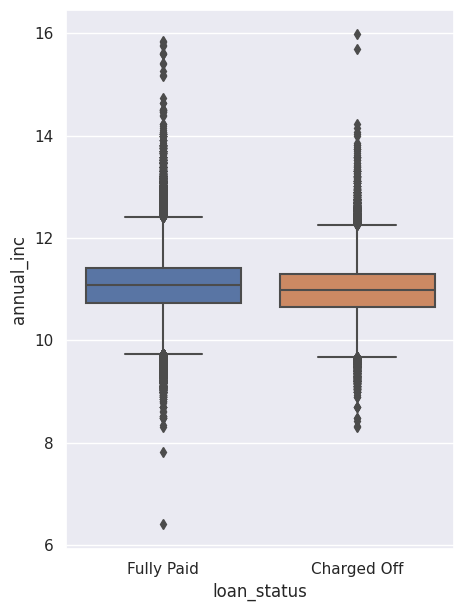

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["annual_inc"]>0]["annual_inc"]),
            x=df["loan_status"])

From the above boxplot, there seems to be no difference between annual income for loan status categories

### 2.10 verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified


In [ ]:
df["verification_status"].value_counts(dropna=False)

Verified           139563
Source Verified    131385
Not Verified       125082
Name: verification_status, dtype: int64

In [ ]:
pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status          Charged Off  Fully Paid
verification_status                         
Not Verified           14.635999   85.364001
Source Verified        21.474293   78.525707
Verified               22.321102   77.678898
All                    19.612908   80.387092

<Axes: xlabel='verification_status'>

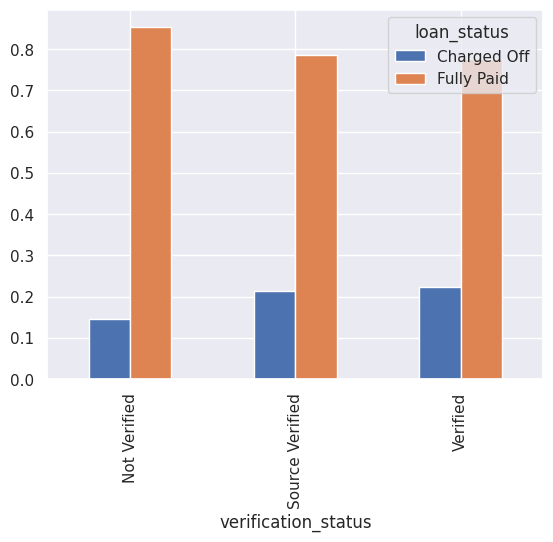

In [ ]:
pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

Later  label encoding  
- Verified           1
- Source Verified    2
- Not Verified       0

### 2.11 purpose: A category provided by the borrower for the loan request.


In [ ]:
df["purpose"].nunique()

14

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64


<Axes: xlabel='purpose'>

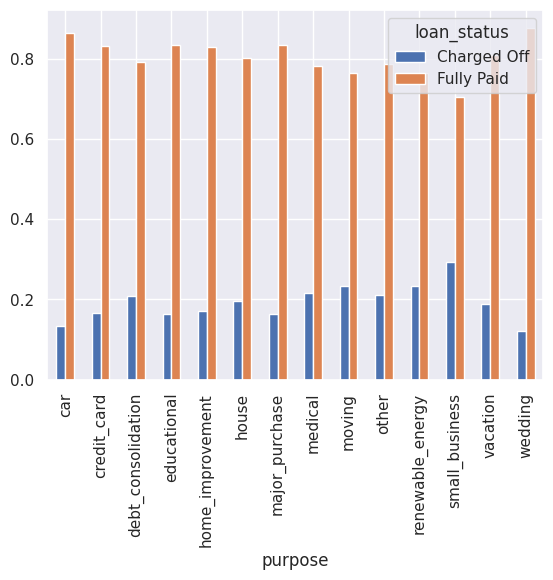

In [ ]:
print(df["purpose"].value_counts(dropna=False))
pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "index", margins = True)*100
pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")


<Axes: >

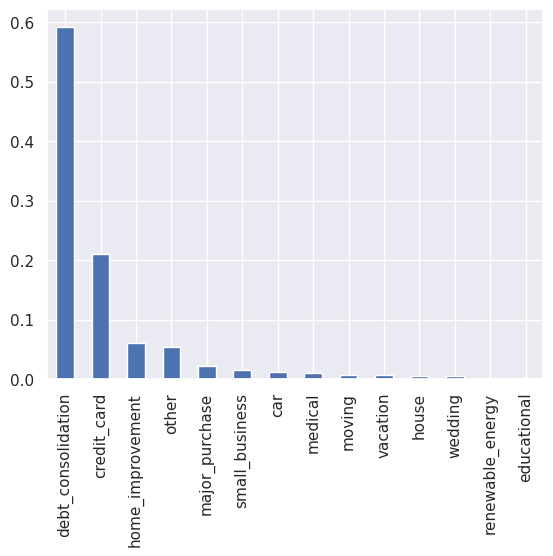

In [ ]:
(df["purpose"].value_counts(dropna=False,normalize=True)).plot(kind = "bar")


### 2.12 loan_status : Current status of the loan - Target Variable


<Axes: >

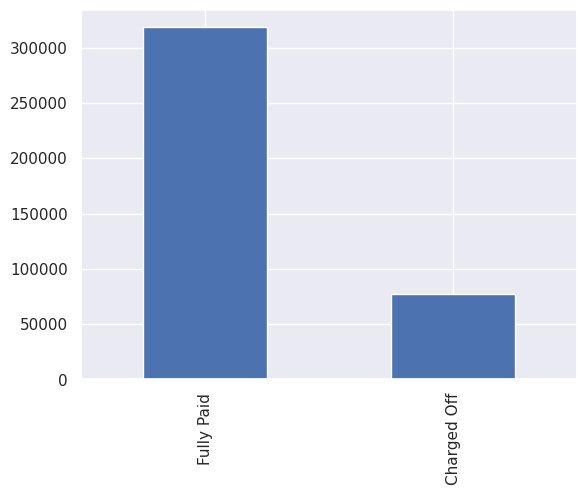

In [ ]:
df["loan_status"].value_counts(dropna=False).plot(kind = "bar")


In [ ]:
df["loan_status"].value_counts(dropna=False, normalize=True)  * 100

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

**Imbalanced data**
- 80% loans are fully paid.
- 20% loans are charged_off

    > Most of the loans are taken for
        debit_card,
        dept_consolidation ,
        home_improvement and others category.
    > The number of loan applications and amount per purpose category are highest in  above category.

### 2.13  title :**The** loan title provided by the borrower




In [ ]:
df["title"].nunique()

48817

In [ ]:
df["title"]

0                        Vacation
1              Debt consolidation
2         Credit card refinancing
3         Credit card refinancing
4           Credit Card Refinance
                   ...           
396025         Debt consolidation
396026         Debt consolidation
396027       pay off credit cards
396028              Loanforpayoff
396029          Toxic Debt Payoff
Name: title, Length: 396030, dtype: object

Title and Purpose are in a way same features.
- later needs to drop this feature.

### 2.14  dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.

>     dti = monthly total dept payment / monthly income excluding mortgages


In [ ]:
df["dti"].describe()

count    396030.000000
mean         17.379514
std          18.019092
min           0.000000
25%          11.280000
50%          16.910000
75%          22.980000
max        9999.000000
Name: dti, dtype: float64

<Axes: >

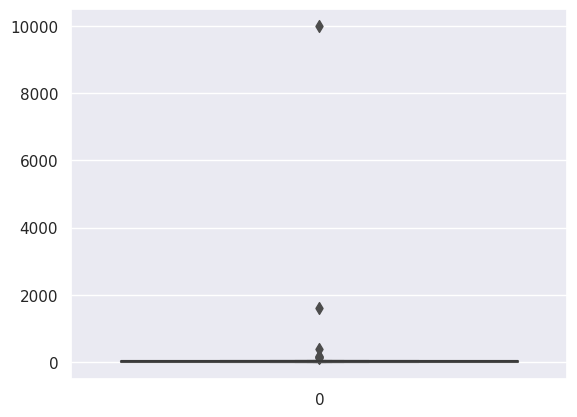

In [ ]:
sns.boxenplot((df["dti"]))

Looks like there are lots of outliers in dti column .

<Axes: xlabel='loan_status', ylabel='dti'>

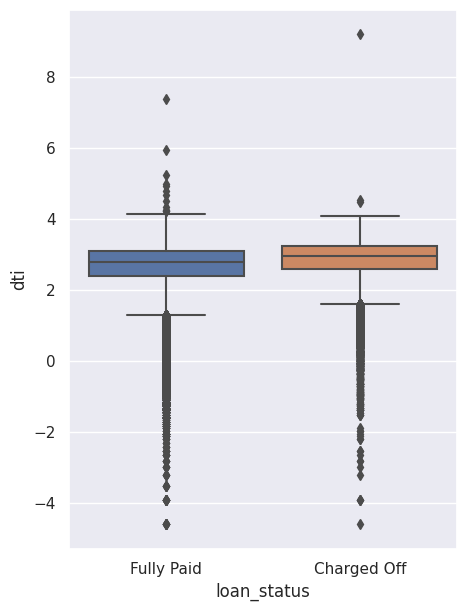

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["dti"]>0]["dti"]),
            x=df["loan_status"])

### 2.15 issue_d: The month which the loan was funded


In [ ]:
df["issue_d"].value_counts(dropna=False)



Oct-2014    14846
Jul-2014    12609
Jan-2015    11705
Dec-2013    10618
Nov-2013    10496
Jul-2015    10270
Oct-2013    10047
Jan-2014     9705
Apr-2015     9470
Sep-2013     9179
Aug-2013     9112
Apr-2014     9020
Nov-2014     8858
May-2014     8840
Jul-2013     8631
Oct-2015     8401
May-2015     8325
Mar-2014     8108
Jun-2013     7947
Aug-2014     7860
Feb-2014     7624
Jun-2014     7610
May-2013     7567
Mar-2015     7268
Feb-2015     7167
Aug-2015     7153
Apr-2013     6970
Jun-2015     6844
Dec-2015     6407
Mar-2013     6187
Mar-2016     5945
Nov-2015     5835
Feb-2013     5693
Sep-2015     5419
Jan-2013     5215
Nov-2012     4910
Oct-2012     4833
Sep-2012     4707
Dec-2012     4571
Feb-2016     4336
Sep-2014     4293
Aug-2012     4220
Jan-2016     4133
Jul-2012     3576
Dec-2014     3487
Apr-2016     3027
Jun-2012     2936
May-2012     2644
Apr-2012     2508
Mar-2012     2256
Jun-2016     2152
May-2016     2082
Jan-2012     2050
Feb-2012     1991
Jul-2016     1851
Dec-2011  

- later use in feature engineering !

### 2.16 earliest_cr_line: The month the borrower's earliest reported credit line was opened


In [ ]:
df["Loan_Tenure"] = ((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M'))

In [ ]:
pd.to_datetime(df["earliest_cr_line"])

0        1990-06-01
1        2004-07-01
2        2007-08-01
3        2006-09-01
4        1999-03-01
            ...    
396025   2004-11-01
396026   2006-02-01
396027   1997-03-01
396028   1990-11-01
396029   1998-09-01
Name: earliest_cr_line, Length: 396030, dtype: datetime64[ns]

**The month which the loan was funded**

In [ ]:
pd.to_datetime(df["issue_d"])

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2014-11-01
4        2013-04-01
            ...    
396025   2015-10-01
396026   2015-02-01
396027   2013-10-01
396028   2012-08-01
396029   2010-06-01
Name: issue_d, Length: 396030, dtype: datetime64[ns]

<Axes: ylabel='Count'>

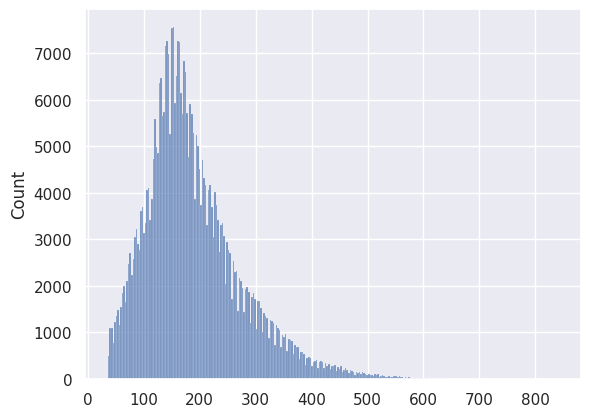

In [ ]:
 sns.histplot(((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M')))


<Axes: xlabel='loan_status'>

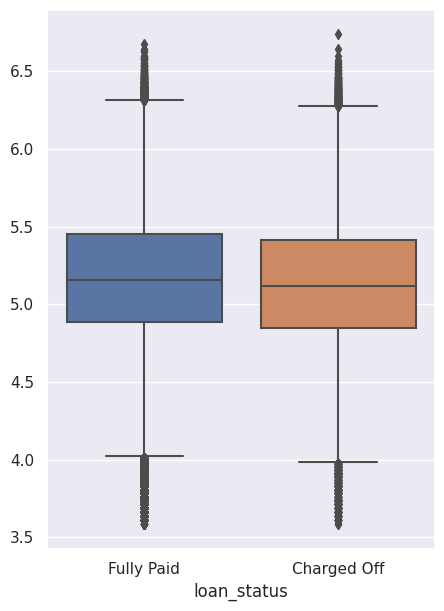

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M'))),
            x=df["loan_status"])

### 2.17 open_acc: The number of open credit lines in the borrower's credit file.


In [ ]:
df.groupby("loan_status")["open_acc"].describe()

count       mean       std  min  25%   50%   75%   max
loan_status                                                           
Charged Off   77673.0  11.602513  5.288507  0.0  8.0  11.0  14.0  76.0
Fully Paid   318357.0  11.240067  5.097647  0.0  8.0  10.0  14.0  90.0

In [ ]:
df["open_acc"].nunique()

61

<Axes: xlabel='open_acc', ylabel='Count'>

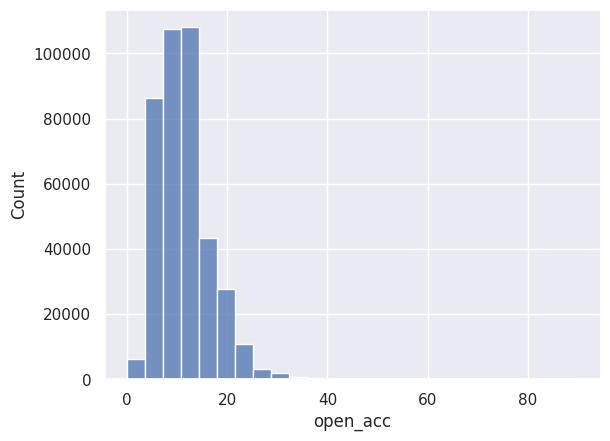

In [ ]:
sns.histplot(df["open_acc"],bins = 25)


<Axes: xlabel='loan_status', ylabel='open_acc'>

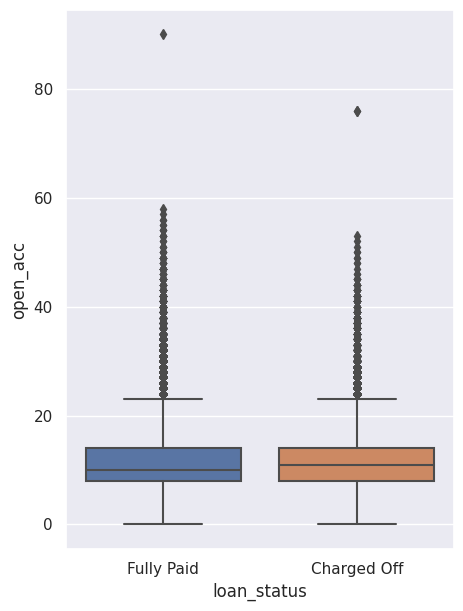

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df["open_acc"],
            x=df["loan_status"])

### 2.18 pub_rec: Number of derogatory public records

- “Derogatory” is seen as negative to lenders, and can include late payments, collection accounts, bankruptcy, charge-offs and other negative marks on your credit report. This can impact your ability to qualify for new credit.

In [ ]:
df.groupby("loan_status")["pub_rec"].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off   77673.0  0.199606  0.648283  0.0  0.0  0.0  0.0  86.0
Fully Paid   318357.0  0.172966  0.497637  0.0  0.0  0.0  0.0  24.0

<Axes: xlabel='loan_status', ylabel='pub_rec'>

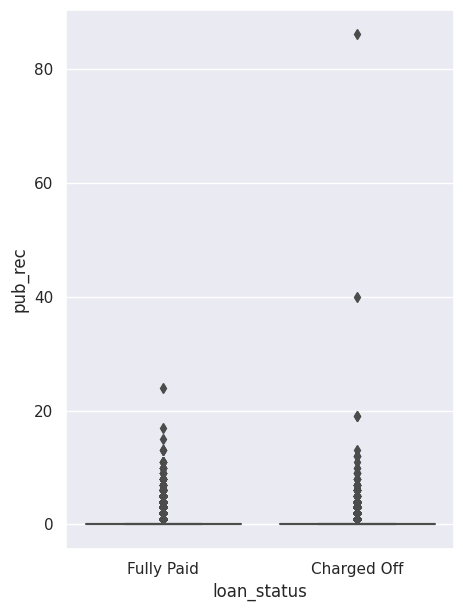

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df["pub_rec"],
            x=df["loan_status"])

0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: pub_rec, dtype: int64


<Axes: xlabel='pub_rec'>

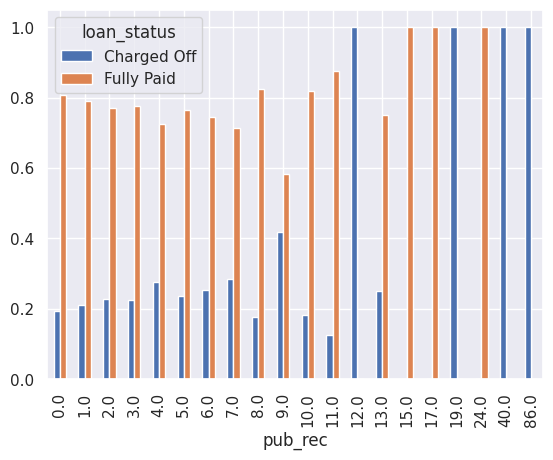

In [ ]:
print(df["pub_rec"].value_counts(dropna=False))
pd.crosstab(index = df["pub_rec"],
            columns= df["loan_status"],normalize= "index", margins = True)*100
pd.crosstab(index = df["pub_rec"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")


### 2.19 revol_bal: Total credit revolving balance

With revolving credit, a consumer has a line of credit he can keep using and repaying over and over. The balance that carries over from one month to the next is the revolving balance on that loan.




In [ ]:
df.groupby("loan_status")["revol_bal"].describe()

count          mean           std  min     25%      50%      75%        max
loan_status                                                                                
Charged Off   77673.0  15390.454701  18203.387930  0.0  6150.0  11277.0  19485.0  1030826.0
Fully Paid   318357.0  15955.327918  21132.193457  0.0  5992.0  11158.0  19657.0  1743266.0

<Axes: xlabel='revol_bal', ylabel='Count'>

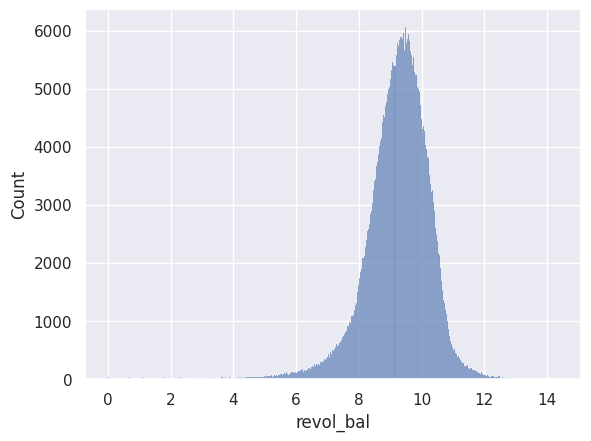

In [ ]:
sns.histplot(np.log(df["revol_bal"]))


<Axes: xlabel='loan_status', ylabel='revol_bal'>

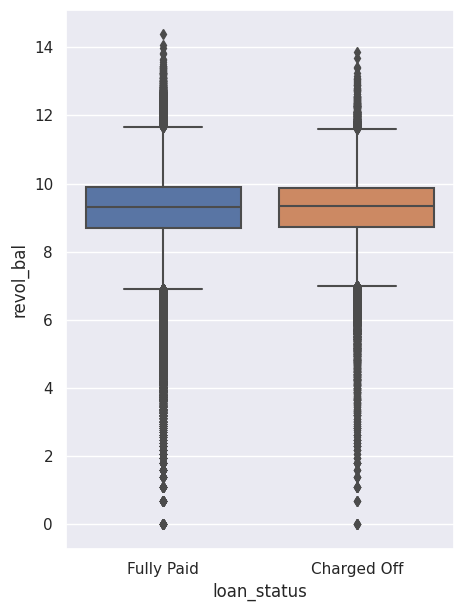

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_bal"]),
            x=df["loan_status"])

### 2.20  revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


Your credit utilization rate, sometimes called your credit utilization ratio, is the amount of revolving credit you're currently using divided by the total amount of revolving credit you have available. In other words, it's how much you currently owe divided by your credit limit. It is generally expressed as a percent.

In [ ]:
df.groupby("loan_status")["revol_util"].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
Charged Off   77673.0  57.822886  23.540366  0.0  41.2  59.3  76.2  148.0
Fully Paid   318357.0  52.761594  24.607979  0.0  34.6  53.6  71.9  892.3

<Axes: xlabel='loan_status', ylabel='revol_util'>

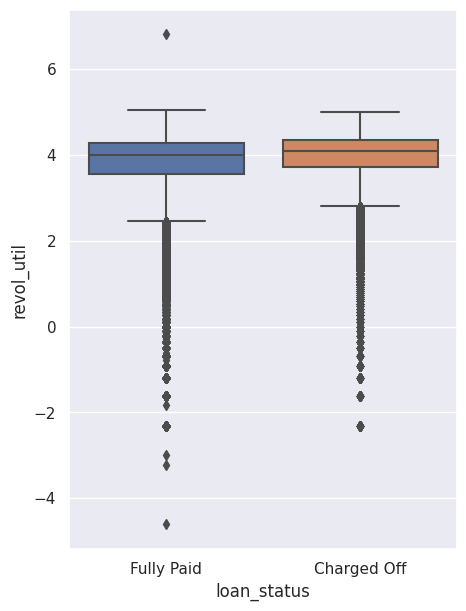

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_util"]),
            x=df["loan_status"])

### 2.21  total_acc: The total number of credit lines currently in the borrower's credit file


In [ ]:
df["total_acc"].value_counts()

21.0     14280
22.0     14260
20.0     14228
23.0     13923
24.0     13878
19.0     13876
18.0     13710
17.0     13495
25.0     13225
26.0     12799
16.0     12771
27.0     12343
15.0     12283
28.0     11706
14.0     11524
29.0     11274
13.0     10936
30.0     10587
31.0      9869
12.0      9858
32.0      9552
11.0      8844
33.0      8682
34.0      8088
10.0      7672
35.0      7406
36.0      6971
9.0       6362
37.0      6362
38.0      5707
39.0      5428
8.0       5365
40.0      4896
41.0      4391
7.0       4143
42.0      4072
43.0      3637
44.0      3408
45.0      2991
6.0       2923
46.0      2626
47.0      2426
48.0      2197
5.0       2028
49.0      1912
50.0      1747
51.0      1529
52.0      1447
53.0      1245
4.0       1238
54.0      1066
63.0      1025
55.0       993
56.0       864
57.0       758
58.0       715
59.0       645
60.0       582
62.0       556
61.0       541
3.0        327
64.0       234
65.0       178
66.0       141
67.0       136
68.0       132
69.0      

In [ ]:
df.groupby("loan_status")["total_acc"].describe()

count       mean        std  min   25%   50%   75%    max
loan_status                                                              
Charged Off   77673.0  24.984152  11.913692  2.0  16.0  23.0  32.0  151.0
Fully Paid   318357.0  25.519800  11.878117  2.0  17.0  24.0  32.0  150.0

<Axes: xlabel='loan_status', ylabel='total_acc'>

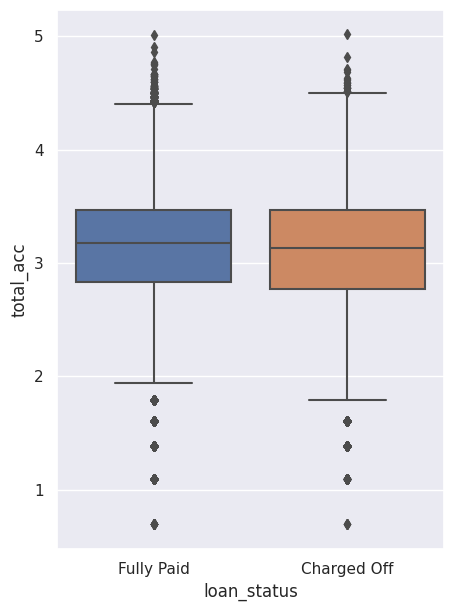

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["total_acc"]),
            x=df["loan_status"])

### 2.22 initial_list_status: The initial listing status of the loan. Possible values are – W, F


In [ ]:
df["initial_list_status"].value_counts()

f    238066
w    157964
Name: initial_list_status, dtype: int64

f    238066
w    157964
Name: initial_list_status, dtype: int64


<Axes: xlabel='initial_list_status'>

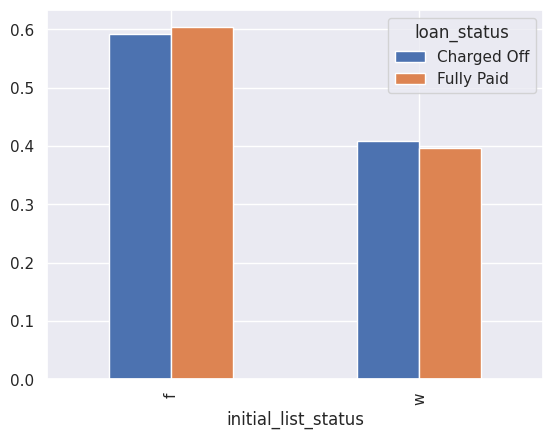

In [ ]:
print(df["initial_list_status"].value_counts(dropna=False))

pd.crosstab(index = df["initial_list_status"],
            columns= df["loan_status"],normalize= "columns").plot(kind = "bar")


### 2.23 application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers


In [ ]:
df["application_type"].value_counts()

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64


<Axes: xlabel='application_type'>

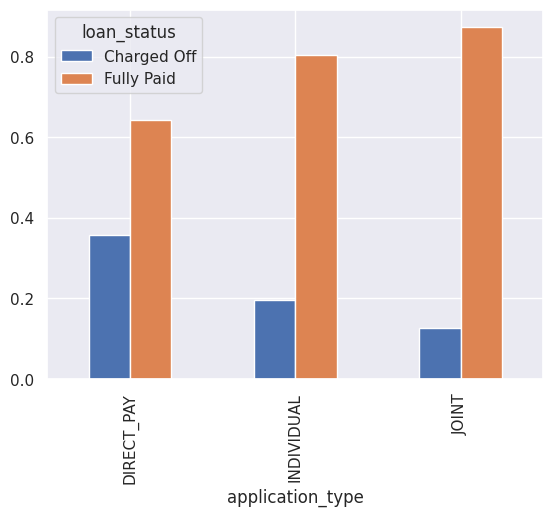

In [ ]:
print(df["application_type"].value_counts(dropna=False))

pd.crosstab(index = df["application_type"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")


### 2.24 mort_acc: Number of mortgage accounts.


In [ ]:
df["mort_acc"].value_counts(dropna=False)

0.0     177572
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: mort_acc, dtype: int64

In [ ]:
df.groupby("loan_status")["mort_acc"].describe()

count      mean       std  min  25%  50%  75%   max
loan_status                                                        
Charged Off   77673.0  1.393946  1.941407  0.0  0.0  1.0  2.0  23.0
Fully Paid   318357.0  1.701119  2.146348  0.0  0.0  1.0  3.0  34.0

<Axes: xlabel='loan_status', ylabel='mort_acc'>

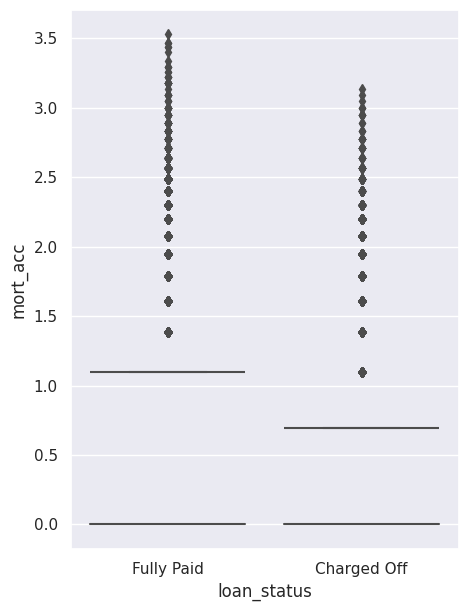

In [ ]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["mort_acc"]),
            x=df["loan_status"])

<Axes: xlabel='mort_acc'>

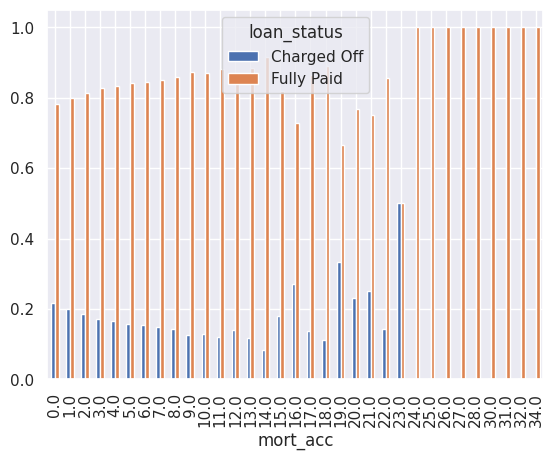

In [ ]:
pd.crosstab(index = df["mort_acc"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

### 2.24 pub_rec_bankruptcies: Number of public record bankruptcies


In [ ]:
df["pub_rec_bankruptcies"].value_counts()

0.0    350915
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: pub_rec_bankruptcies, dtype: int64

0.0    350915
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: pub_rec_bankruptcies, dtype: int64
loan_status           Charged Off  Fully Paid
pub_rec_bankruptcies                         
0.0                     19.494180   80.505820
1.0                     20.394952   79.605048
2.0                     23.226854   76.773146
3.0                     21.082621   78.917379
4.0                     31.707317   68.292683
5.0                     15.625000   84.375000
6.0                     28.571429   71.428571
7.0                     25.000000   75.000000
8.0                     50.000000   50.000000
All                     19.612908   80.387092


<Axes: xlabel='pub_rec_bankruptcies'>

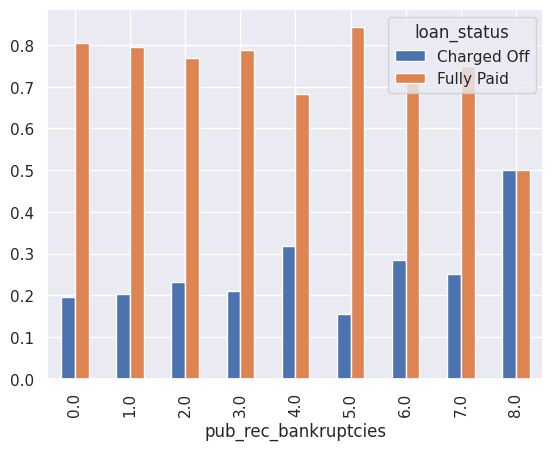

In [ ]:
print(df["pub_rec_bankruptcies"].value_counts(dropna=False))
print(pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "index", margins = True)*100)
pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")


### 2.25 Address: Address of the individual

In [ ]:
df["address"][10]

'40245 Cody Drives\r\nBartlettfort, NM 00813'

In [ ]:
df["address"] = df["address"].str.split().apply(lambda x:x[-1])

In [ ]:
df["address"].value_counts()

70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: address, dtype: int64

<Axes: xlabel='address'>

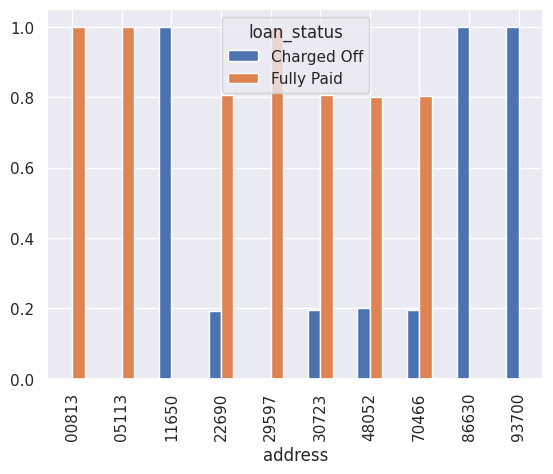

In [ ]:
pd.crosstab(index = df["address"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")


In [ ]:
df["pin_code"] = df["address"]
df.drop(["address"],axis = 1  ,inplace=True)

## Converted data into relevant data types

In [ ]:
df.shape

(396030, 28)

In [ ]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'Loan_Tenure', 'pin_code'], dtype='object')

In [ ]:
df['grade'] = df['grade'].apply(lambda x: grade_to_int[str(x).split('-')[0]])

df['sub_grade'] = df['sub_grade'].apply(lambda x: sub_grade_to_int[str(x).split('-')[0]])
df['emp_length'] = df['emp_length'].apply(lambda x: emp_len_to_int[str(x).split('-')[0]])
df['issue_d_month'] = df['issue_d'].apply(lambda x: mon_to_int[str(x).split('-')[0]])
df['issue_d_year'] = df['issue_d'].apply(lambda x: int(str(x).split('-')[1]))
df['earliest_cr_line_month'] = df['earliest_cr_line'].apply(lambda x: mon_to_int[str(x).split('-')[0]])
df['earliest_cr_line_year'] = df['earliest_cr_line'].apply(lambda x: int(str(x).split('-')[1]))
df['emp_title_primary'] = df['emp_title'].apply(lambda x: str(x).strip().split(':')[0] if ':' in str(x) else str(x))
df['emp_title_secondary'] = df['emp_title'].apply(lambda x: str(x).strip().split(':')[1] if ':' in str(x) else 'NA')
df['title'] = df['title'].apply(lambda x: str(x).replace(':', '').strip())
df['pin_code'] = df['pin_code'].apply(lambda x: str(str(x)[len(str(x))-5:]))
df = df.drop([ 'emp_title'], axis=1)

In [ ]:

df.dtypes

loan_amnt                 float64
term                        int64
int_rate                  float64
installment               float64
grade                       int64
sub_grade                   int64
emp_length                  int64
home_ownership             object
annual_inc                float64
verification_status        object
issue_d                    object
loan_status                object
purpose                    object
title                      object
dti                       float64
earliest_cr_line           object
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
initial_list_status        object
application_type           object
mort_acc                  float64
pub_rec_bankruptcies      float64
Loan_Tenure               float64
pin_code                   object
issue_d_month               int64
issue_d_year                int64
earliest_cr_li

In [ ]:
df

loan_amnt  term  int_rate  installment  grade  sub_grade  emp_length home_ownership  annual_inc verification_status   issue_d  loan_status             purpose                    title    dti earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status application_type  mort_acc  pub_rec_bankruptcies  Loan_Tenure pin_code  issue_d_month  issue_d_year  earliest_cr_line_month  earliest_cr_line_year         emp_title_primary emp_title_secondary
0         10000.0    36     11.44       329.48      6         27          10           RENT    117000.0        Not Verified  Jan-2015   Fully Paid            vacation                 Vacation  26.24         Jun-1990      16.0      0.0    36369.0        41.8       25.0                   w       INDIVIDUAL       0.0                   0.0   295.036859    22690              1          2015                       6                   1990                 Marketing                  NA
1          8000.0    36     11.99       265.68      6         26           4       MORTGAGE     65000.0        Not Verified  Jan-2015   Fully Paid  debt_consolidation       Debt consolidation  22.05         Jul-2004      17.0      0.0    20131.0        53.3       27.0                   f       INDIVIDUAL       3.0                   0.0   126.031335    05113              1          2015                       7                   2004           Credit analyst                   NA
2         15600.0    36     10.49       506.97      6         28           0           RENT     43057.0     Source Verified  Jan-2015   Fully Paid         credit_card  Credit card refinancing  12.79         Aug-2007      13.0      0.0    11987.0        92.2       26.0                   f       INDIVIDUAL       0.0                   0.0    89.036736    05113              1          2015                       8                   2007              Statistician                  NA
3          7200.0    36      6.49       220.65      7         34           6           RENT     54000.0        Not Verified  Nov-2014   Fully Paid         credit_card  Credit card refinancing   2.60         Sep-2006       6.0      0.0     5472.0        21.5       13.0                   f       INDIVIDUAL       0.0                   0.0    98.006119    00813             11          2014                       9                   2006           Client Advocate                  NA
4         24375.0    60     17.27       609.33      5         21           9       MORTGAGE     55000.0            Verified  Apr-2013  Charged Off         credit_card    Credit Card Refinance  33.95         Mar-1999      13.0      0.0    24584.0        69.8       43.0                   f       INDIVIDUAL       1.0                   0.0   169.038379    11650              4          2013                       3                   1999   Destiny Management Inc.                  NA
...           ...   ...       ...          ...    ...        ...         ...            ...         ...                 ...       ...          ...                 ...                      ...    ...              ...       ...      ...        ...         ...        ...                 ...              ...       ...                   ...          ...      ...            ...           ...                     ...                    ...                       ...                 ...
396025    10000.0    60     10.99       217.38      6         27           2           RENT     40000.0     Source Verified  Oct-2015   Fully Paid  debt_consolidation       Debt consolidation  15.63         Nov-2004       6.0      0.0     1990.0        34.3       23.0                   w       INDIVIDUAL       0.0                   0.0   130.959568    30723             10          2015                      11                   2004          licensed bankere                  NA
396026    21000.0    36     12.29       700.42      5         25           5       MORTGAGE    110000.0     Source Verified  Feb-2015   Fully Paid  debt

In [ ]:
 df = convert_to_best_type(df)

In [ ]:
df.dtypes

loan_amnt                  float64
term                      category
int_rate                   float64
installment                float64
grade                        int64
sub_grade                    int64
emp_length                   int64
home_ownership            category
annual_inc                 float64
verification_status       category
issue_d                     string
loan_status               category
purpose                     string
title                       string
dti                        float64
earliest_cr_line            string
open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                 float64
total_acc                  float64
initial_list_status       category
application_type          category
mort_acc                   float64
pub_rec_bankruptcies       float64
Loan_Tenure                float64
pin_code                     int64
issue_d_month                int64
issue_d_year        

## 3. Dropping unimportant columns

In [ ]:
df.drop(["title","issue_d","earliest_cr_line","initial_list_status"],axis = 1, inplace=True)

In [ ]:
df.drop(["Loan_Tenure"],axis=1,inplace=True)

## 4. Missing value treatment

In [ ]:
missing_data[missing_data["Percent"]>0]

Total   Percent
mort_acc              37795  9.543469
emp_title             22927  5.789208
emp_length            18301  4.621115
title                  1755  0.443148
pub_rec_bankruptcies    535  0.135091
revol_util              276  0.069692

In [ ]:
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(strategy="most_frequent")
df["mort_acc"] = Imputer.fit_transform(df["mort_acc"].values.reshape(-1,1))

In [ ]:
df.dropna(inplace=True)

In [ ]:
missing_df(df)

Total  Percent
loan_amnt                   0      0.0
term                        0      0.0
emp_title_primary           0      0.0
earliest_cr_line_year       0      0.0
earliest_cr_line_month      0      0.0
issue_d_year                0      0.0
issue_d_month               0      0.0
pin_code                    0      0.0
pub_rec_bankruptcies        0      0.0
mort_acc                    0      0.0
application_type            0      0.0
total_acc                   0      0.0
revol_util                  0      0.0
revol_bal                   0      0.0
pub_rec                     0      0.0
open_acc                    0      0.0
dti                         0      0.0
purpose                     0      0.0
loan_status                 0      0.0
verification_status         0      0.0
annual_inc                  0      0.0
home_ownership              0      0.0
emp_length                  0      0.0
sub_grade                   0      0.0
grade                       0      0.0
installment                 0      0.0
int_rate                    0      0.0
emp_title_secondary         0      0.0

## 5. Outlier treatment :

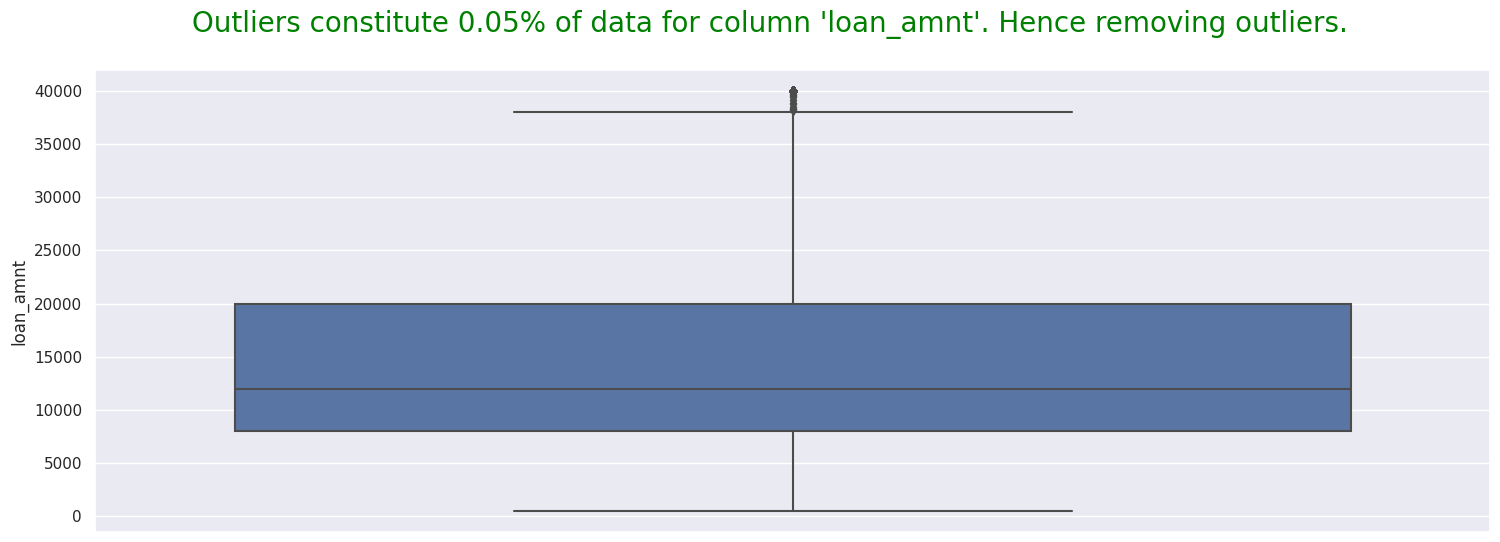

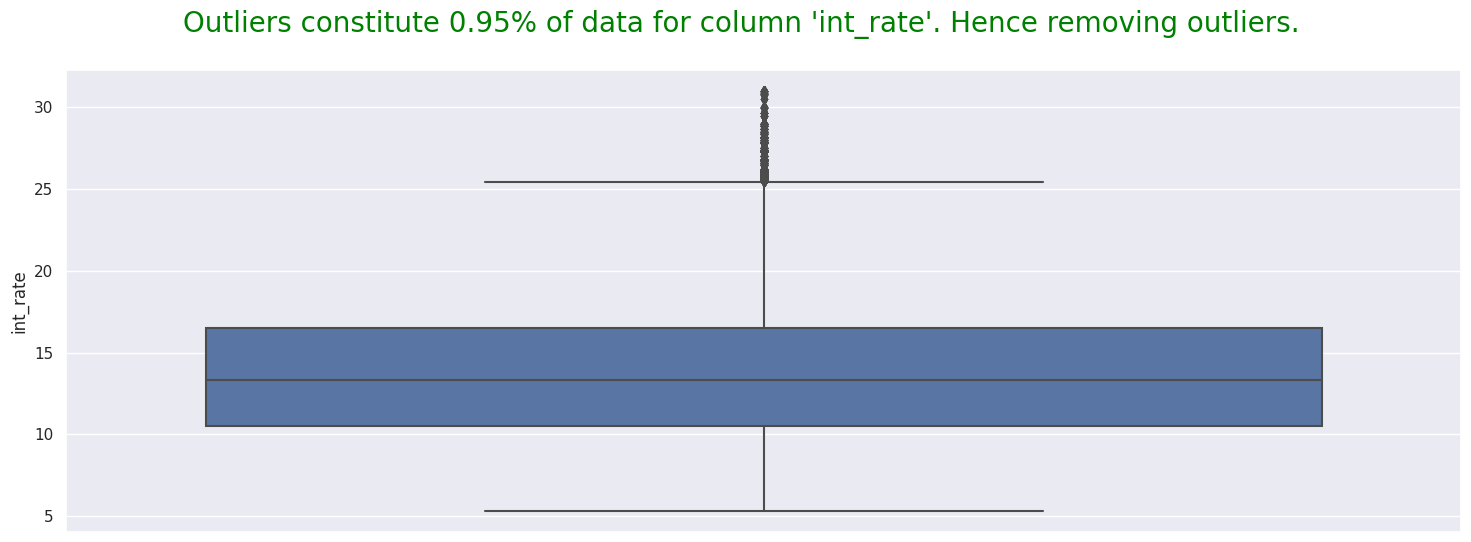

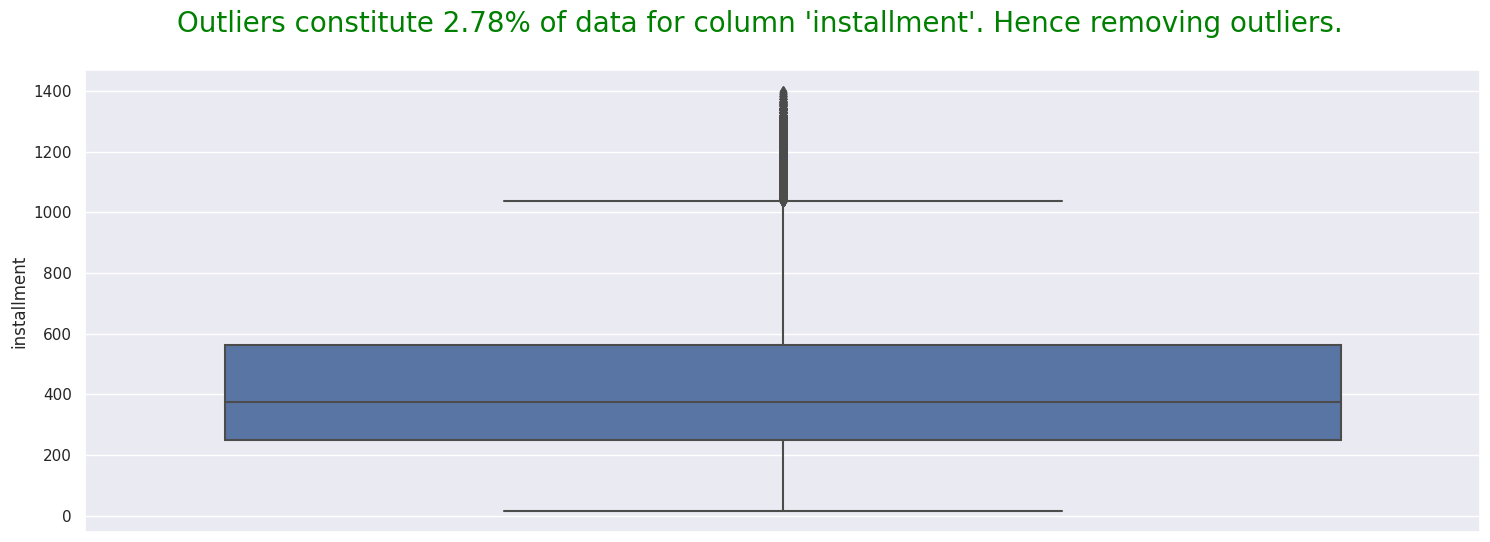

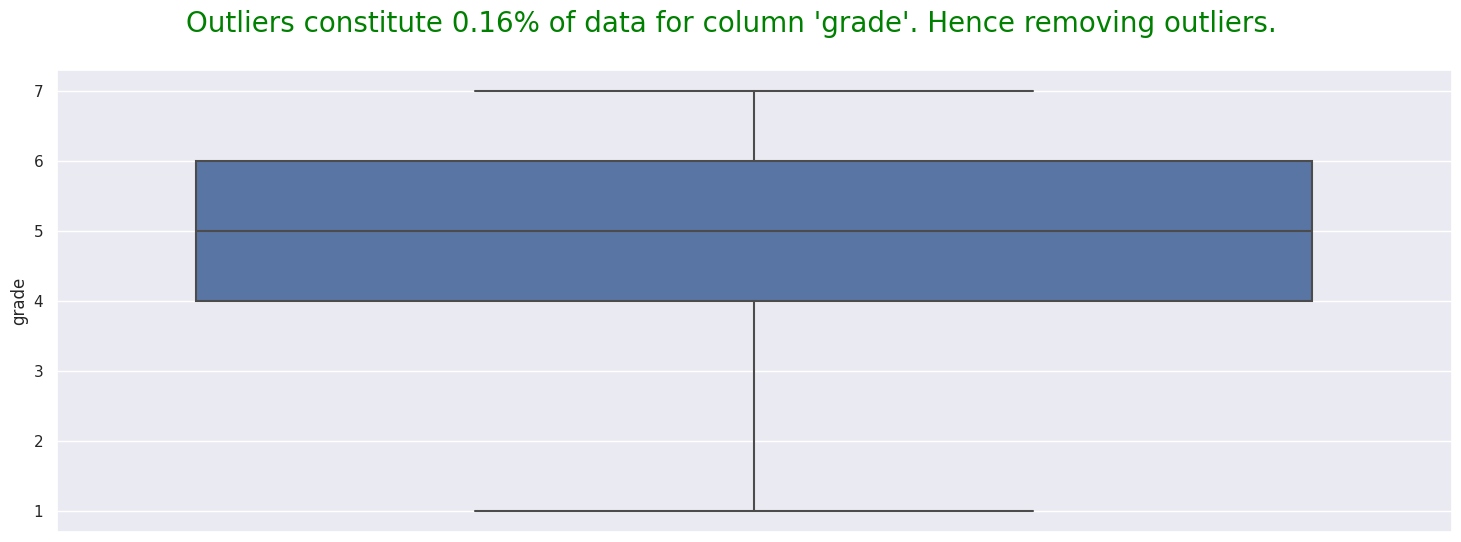

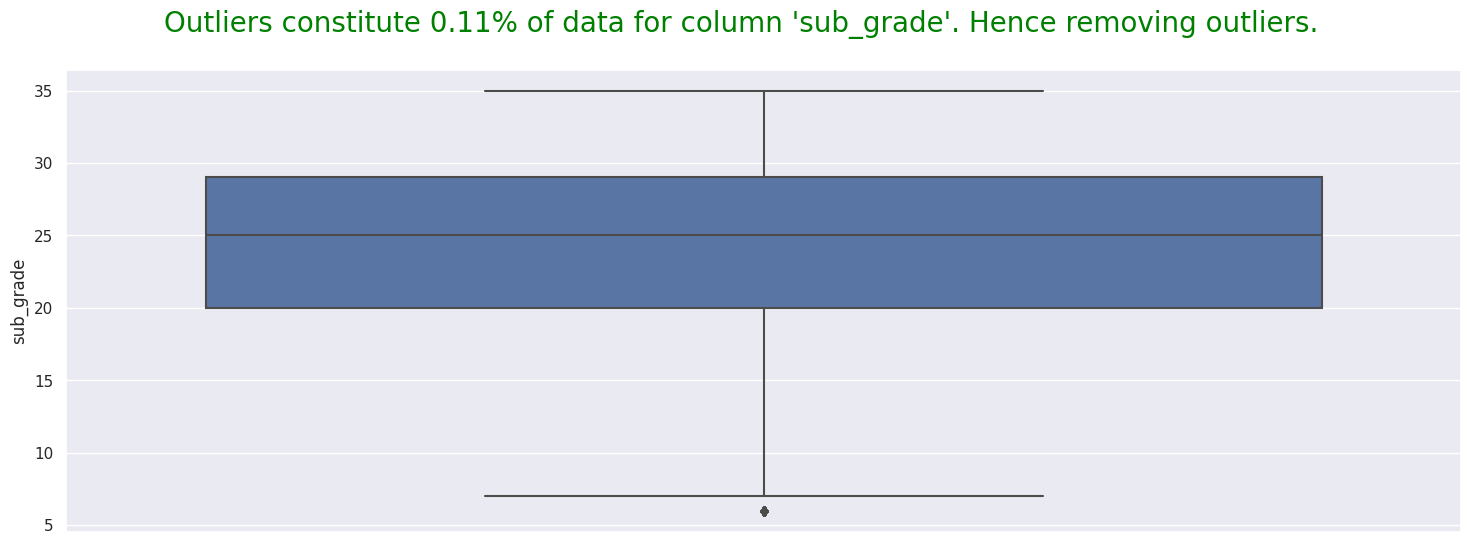

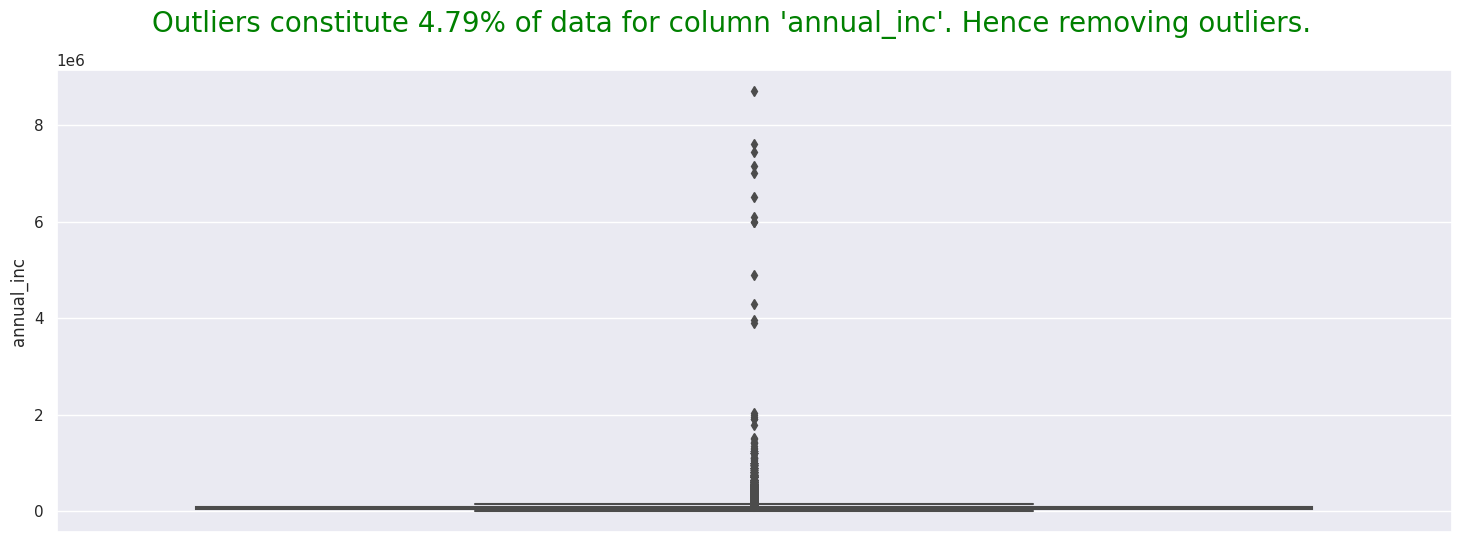

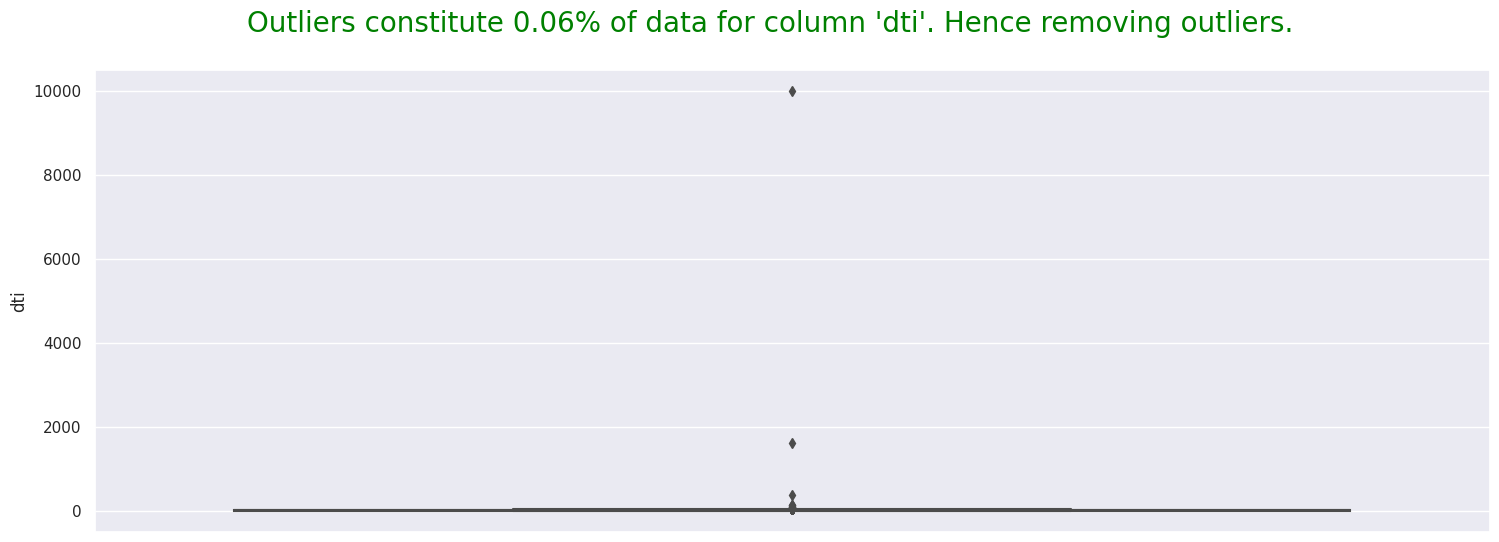

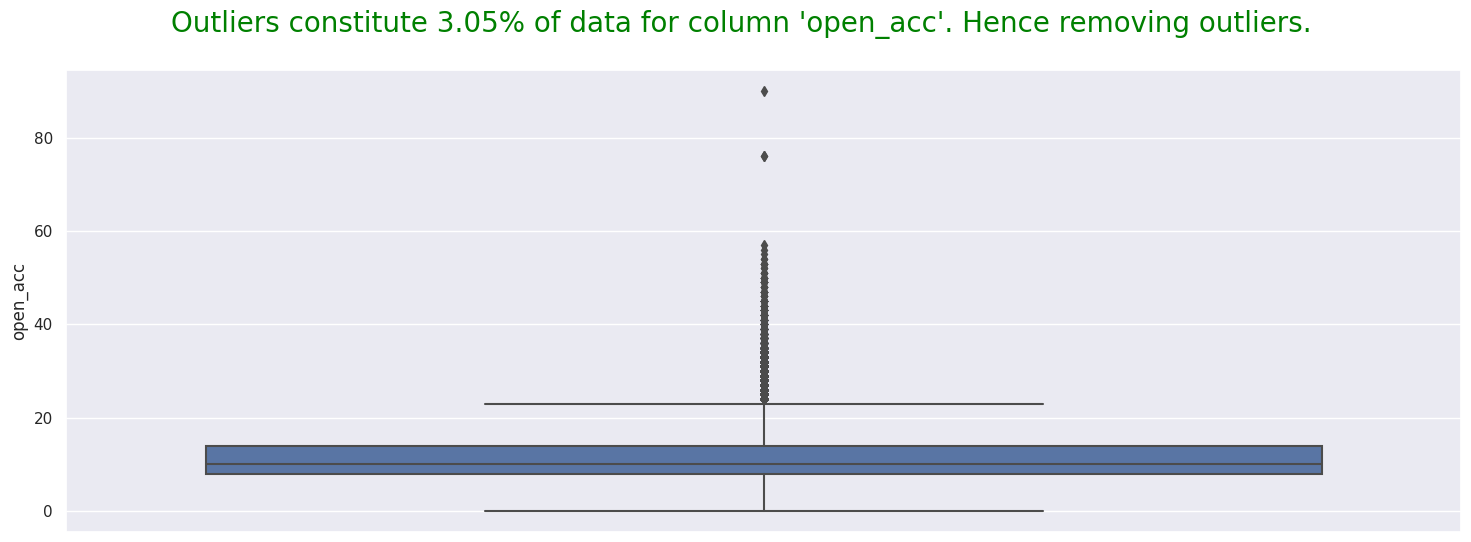

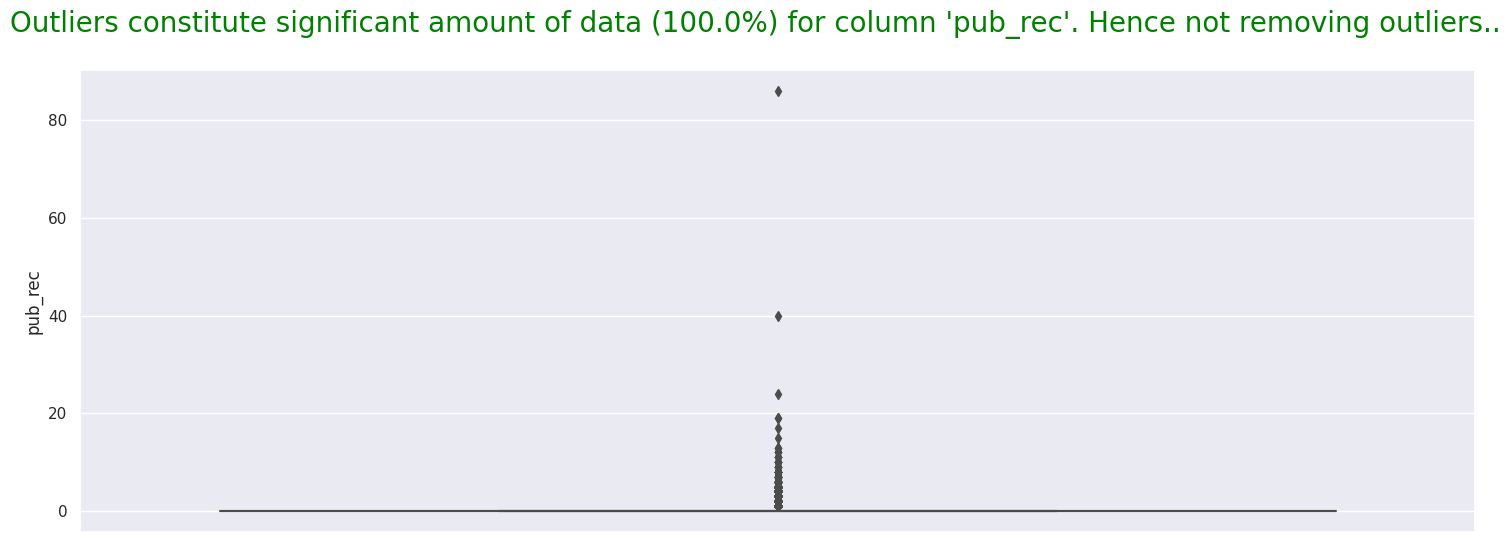

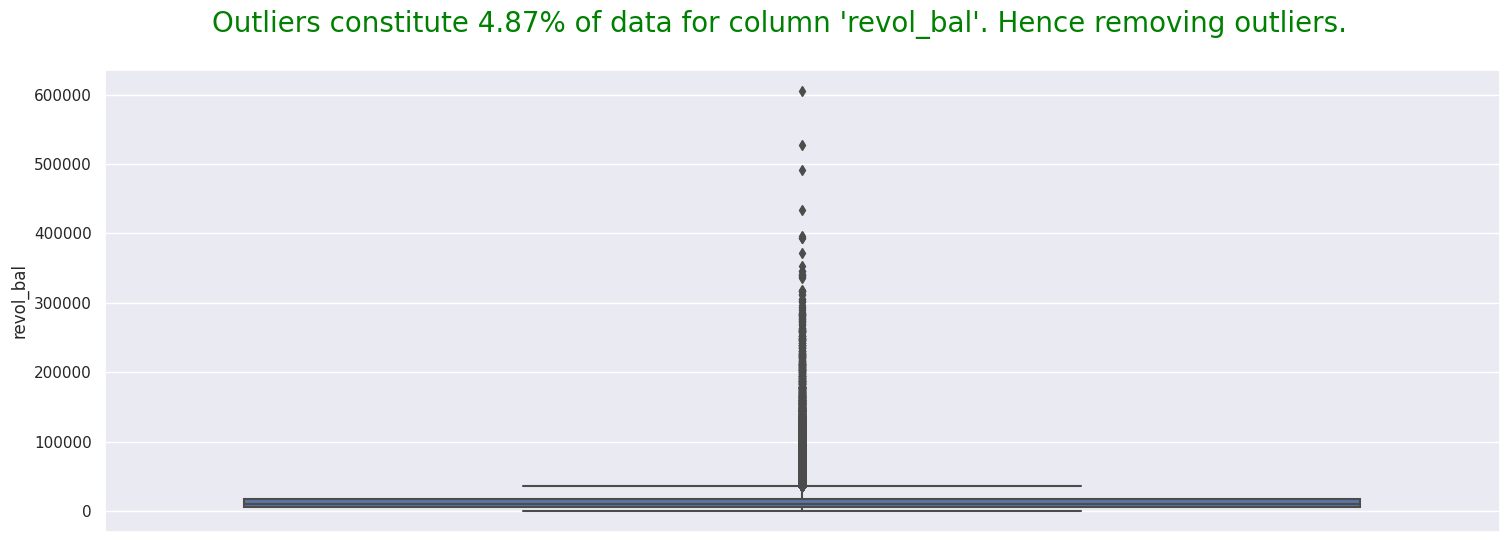

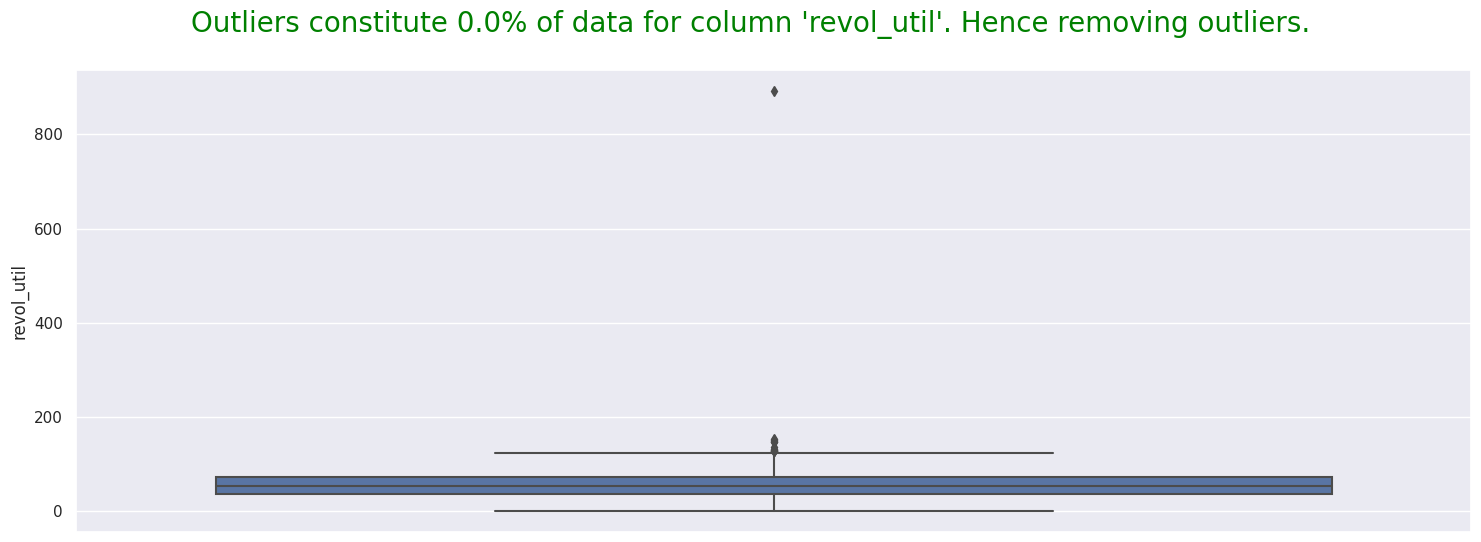

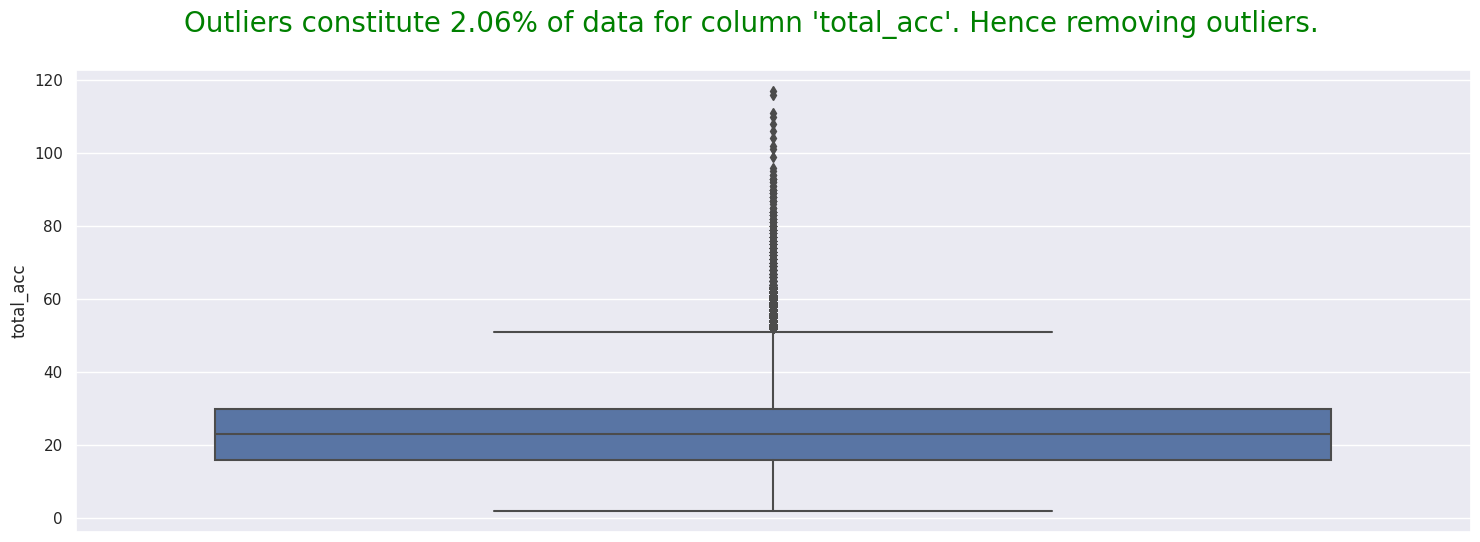

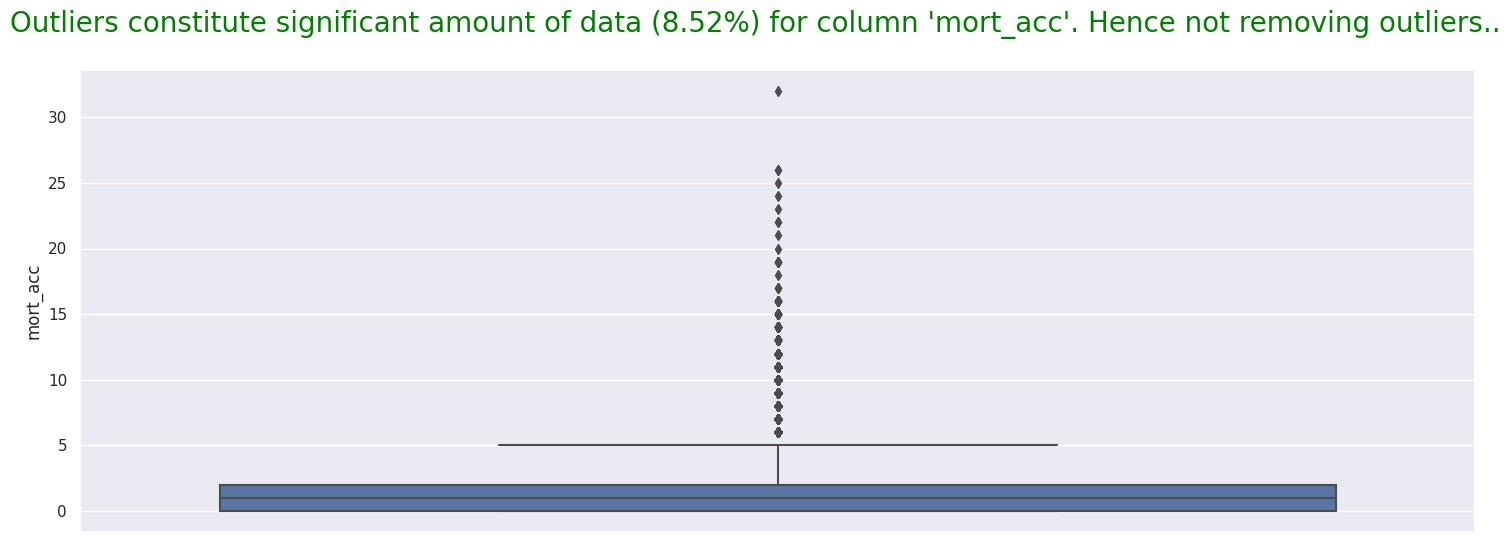

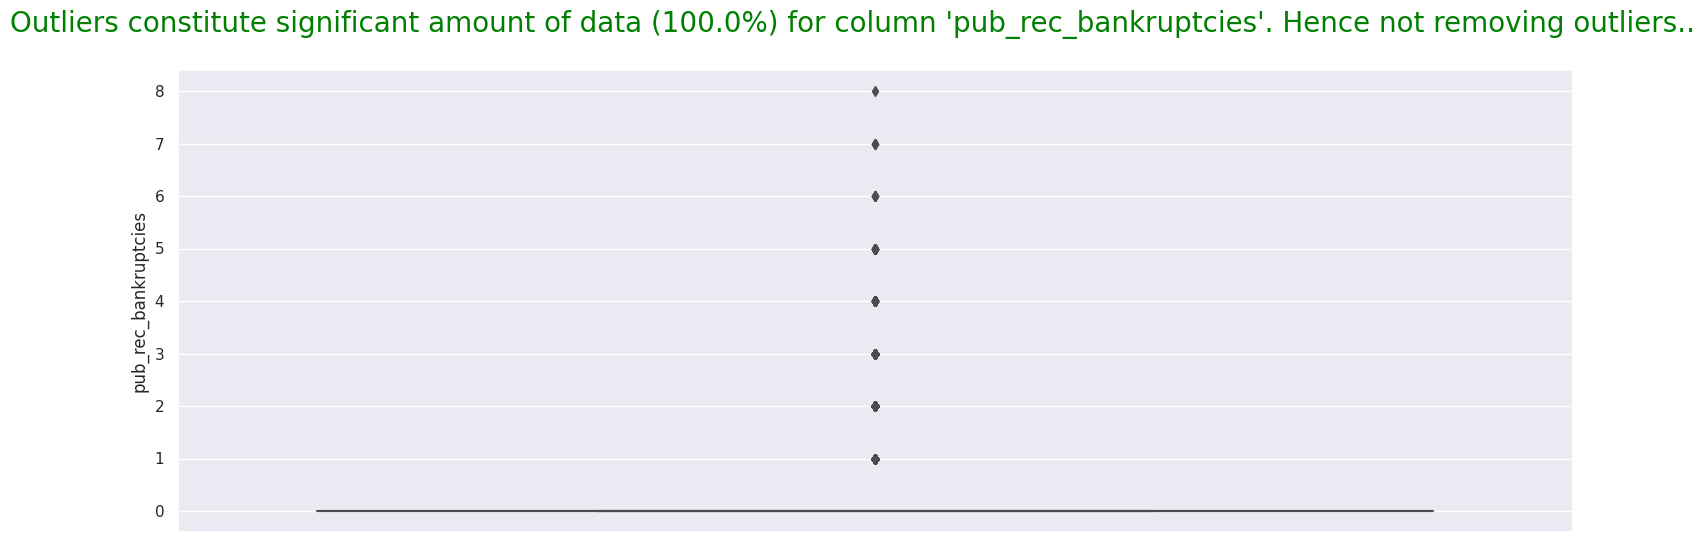

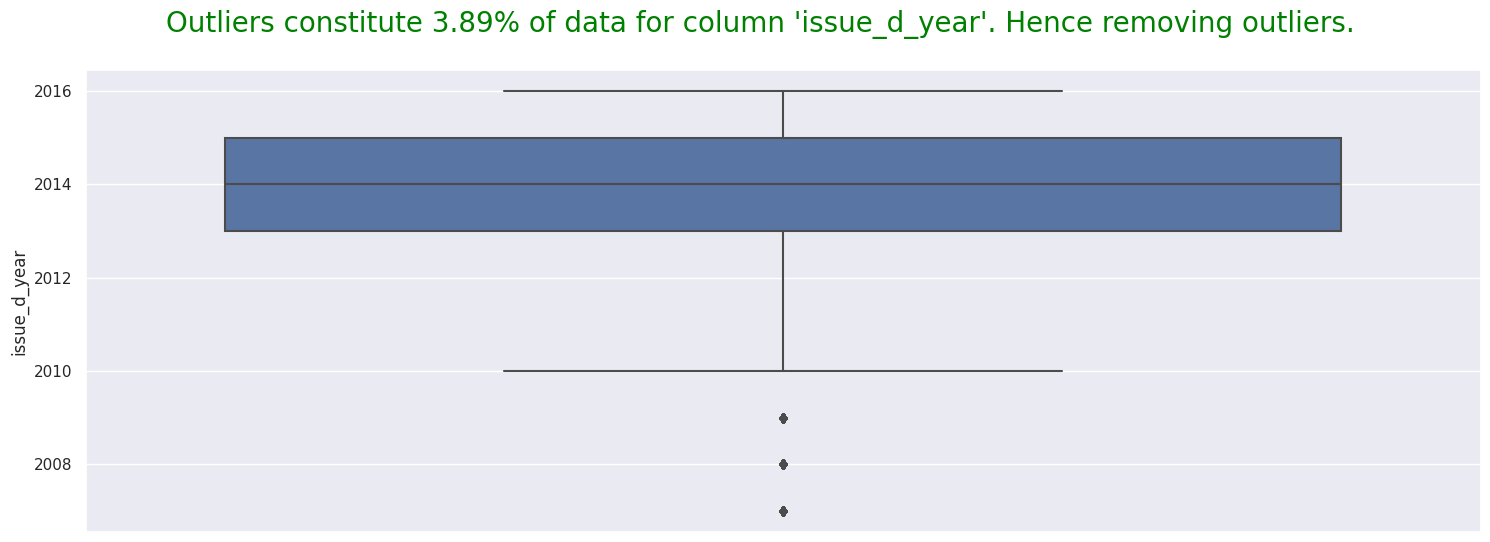

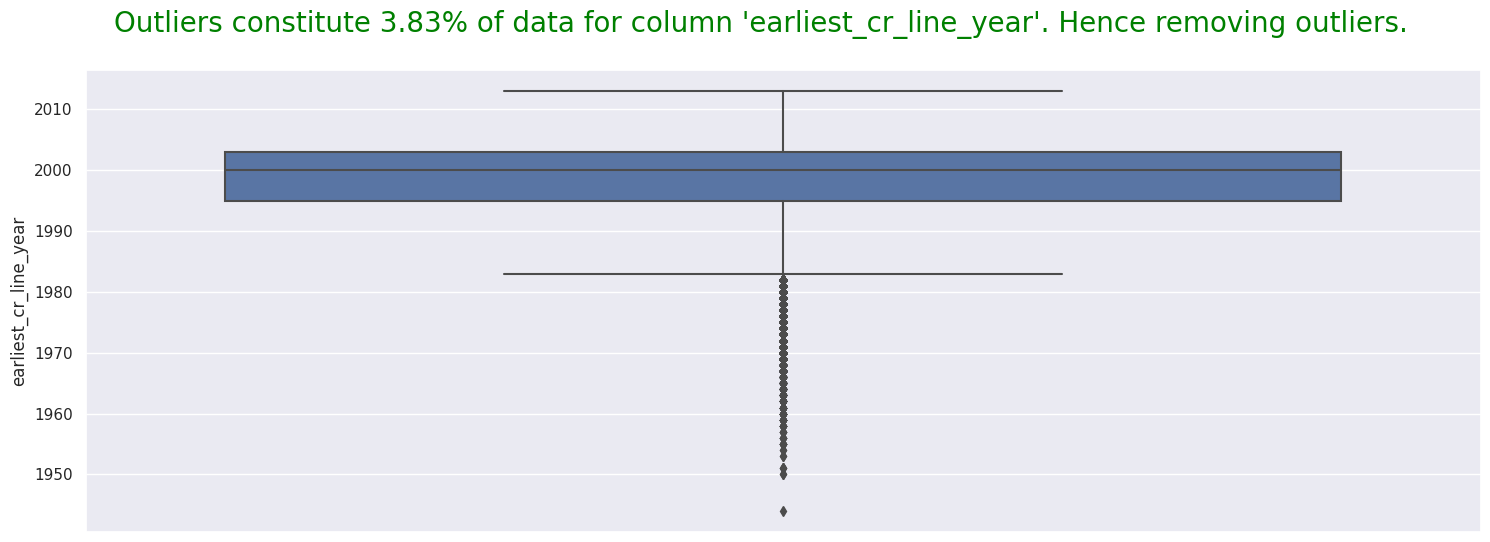

In [ ]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column, thresh=5)

In [ ]:
def outlier_remover(a,df):

    q1 = a.quantile(.25)
    q3 = a.quantile(.75)
    iqr = q3 - q1

    maxx = q3 + 1.5 * iqr
    minn = q1 - 1.5 * iqr

    return df.loc[(a>=minn) & (a<=maxx)]

In [ ]:
floats = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc','revol_bal', 'revol_util', 'total_acc']

In [ ]:
df.sample(3)

loan_amnt term  int_rate  installment  grade  sub_grade  emp_length home_ownership  annual_inc verification_status  loan_status             purpose    dti  open_acc  pub_rec  revol_bal  revol_util  total_acc application_type  mort_acc  pub_rec_bankruptcies  pin_code  issue_d_month  issue_d_year  earliest_cr_line_month  earliest_cr_line_year emp_title_primary emp_title_secondary
297482    20500.0   36     13.98       700.45      5         23           6           RENT     60000.0            Verified  Charged Off  debt_consolidation  11.82       8.0      0.0     9643.0        31.0       11.0       INDIVIDUAL       0.0                   0.0     93700              5          2014                      10                   2004       hoesekeeper                  NA
323477    15000.0   60     12.29       335.87      5         25          10       MORTGAGE    108000.0            Verified   Fully Paid  debt_consolidation   1.21       5.0      1.0     4368.0        32.4       22.0       INDIVIDUAL       6.0                   1.0      5113              7          2015                       9                   1996        Detective                   NA
193836    24950.0   60     14.64       588.86      5         23           8       MORTGAGE     65000.0     Source Verified   Fully Paid         credit_card  20.72      14.0      0.0    29424.0        47.6       32.0       INDIVIDUAL       1.0                   0.0      5113              4          2014                       8                   2002    Branch Manager                  NA

In [ ]:
for i in floats:
    df = outlier_remover(df[i],df)

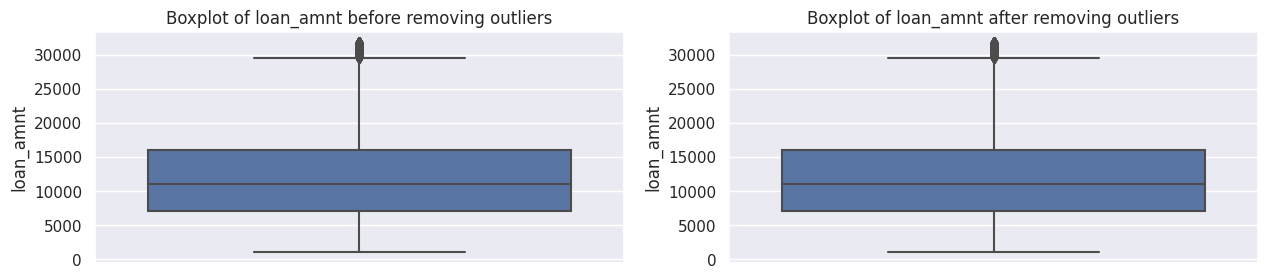

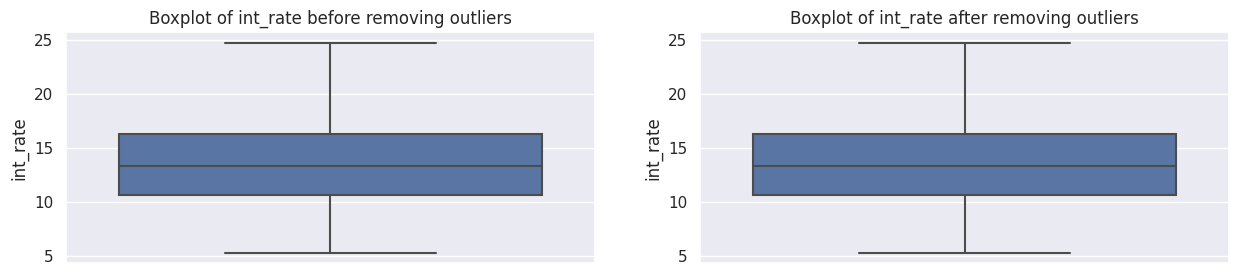

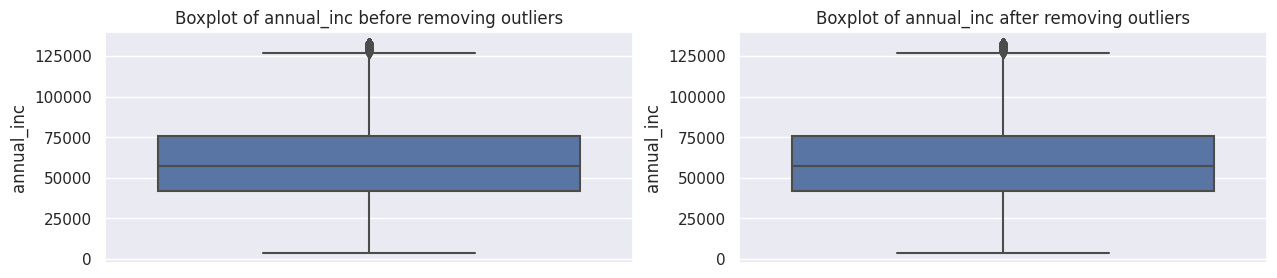

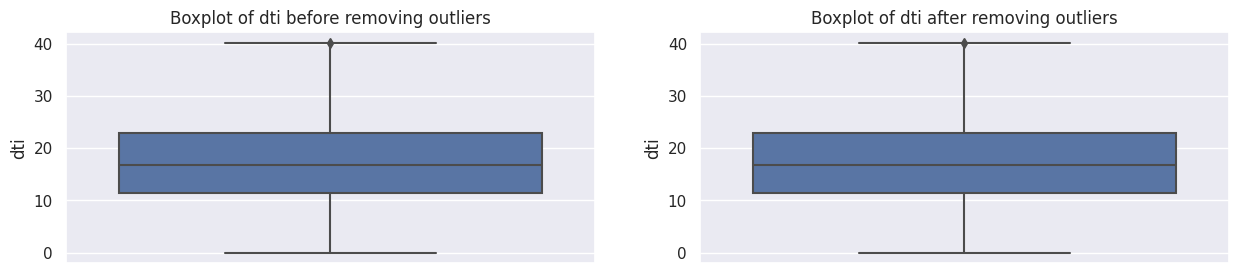

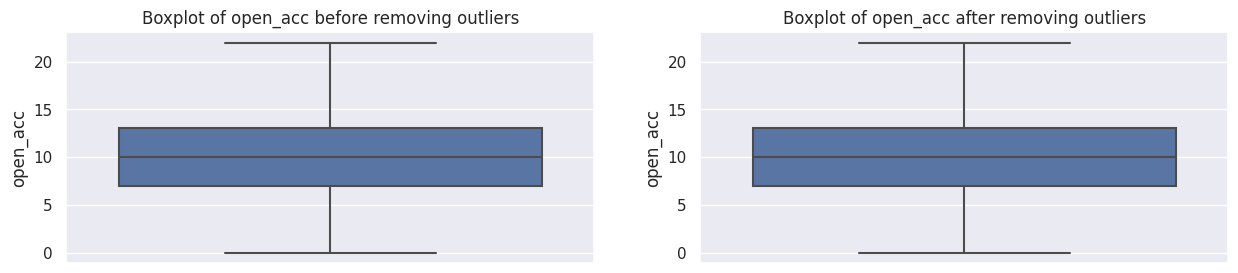

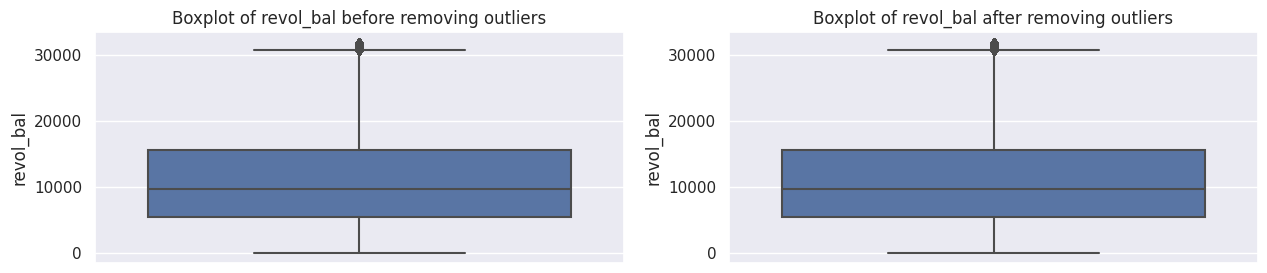

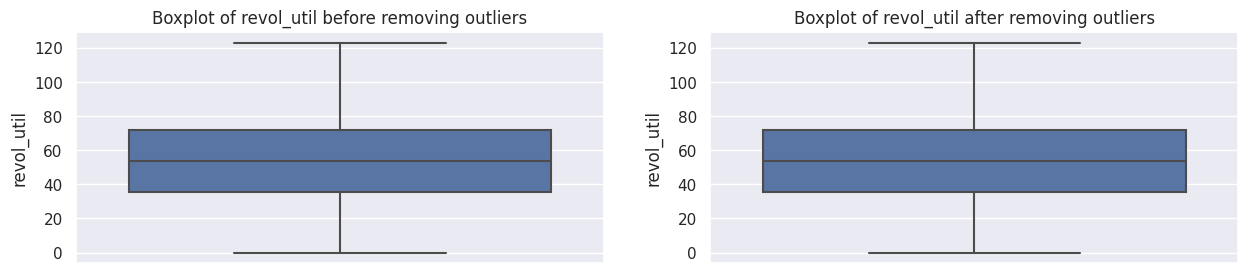

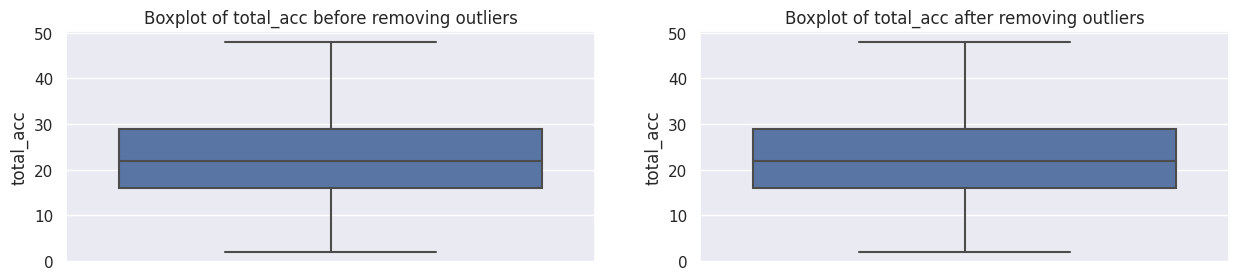

In [ ]:
for i in floats:
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    sns.boxplot(y=df[i])
    plt.title(f"Boxplot of {i} before removing outliers")
    plt.subplot(122)
    sns.boxplot(y=df[i])
    plt.title(f"Boxplot of {i} after removing outliers")

    plt.show()

## 6. Missing value check :

In [ ]:
def missing_df(data):
    total_missing_df = data.isna().sum().sort_values(ascending = False)
    percentage_missing_df = ((data.isna().sum()/len(data)*100)).sort_values(ascending = False)
    missingDF = pd.concat([total_missing_df, percentage_missing_df],axis = 1, keys=['Total', 'Percent'])
    return missingDF


missing_data = missing_df(df)
missing_data[missing_data["Total"]>0]


Empty DataFrame
Columns: [Total, Percent]
Index: []

In [ ]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'pin_code', 'issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year', 'emp_title_primary', 'emp_title_secondary'], dtype='object')

In [ ]:
df.drop(["mort_acc","pub_rec_bankruptcies"],axis = 1 , inplace=True)

In [ ]:
df.drop(["pub_rec"],axis = 1 , inplace=True)

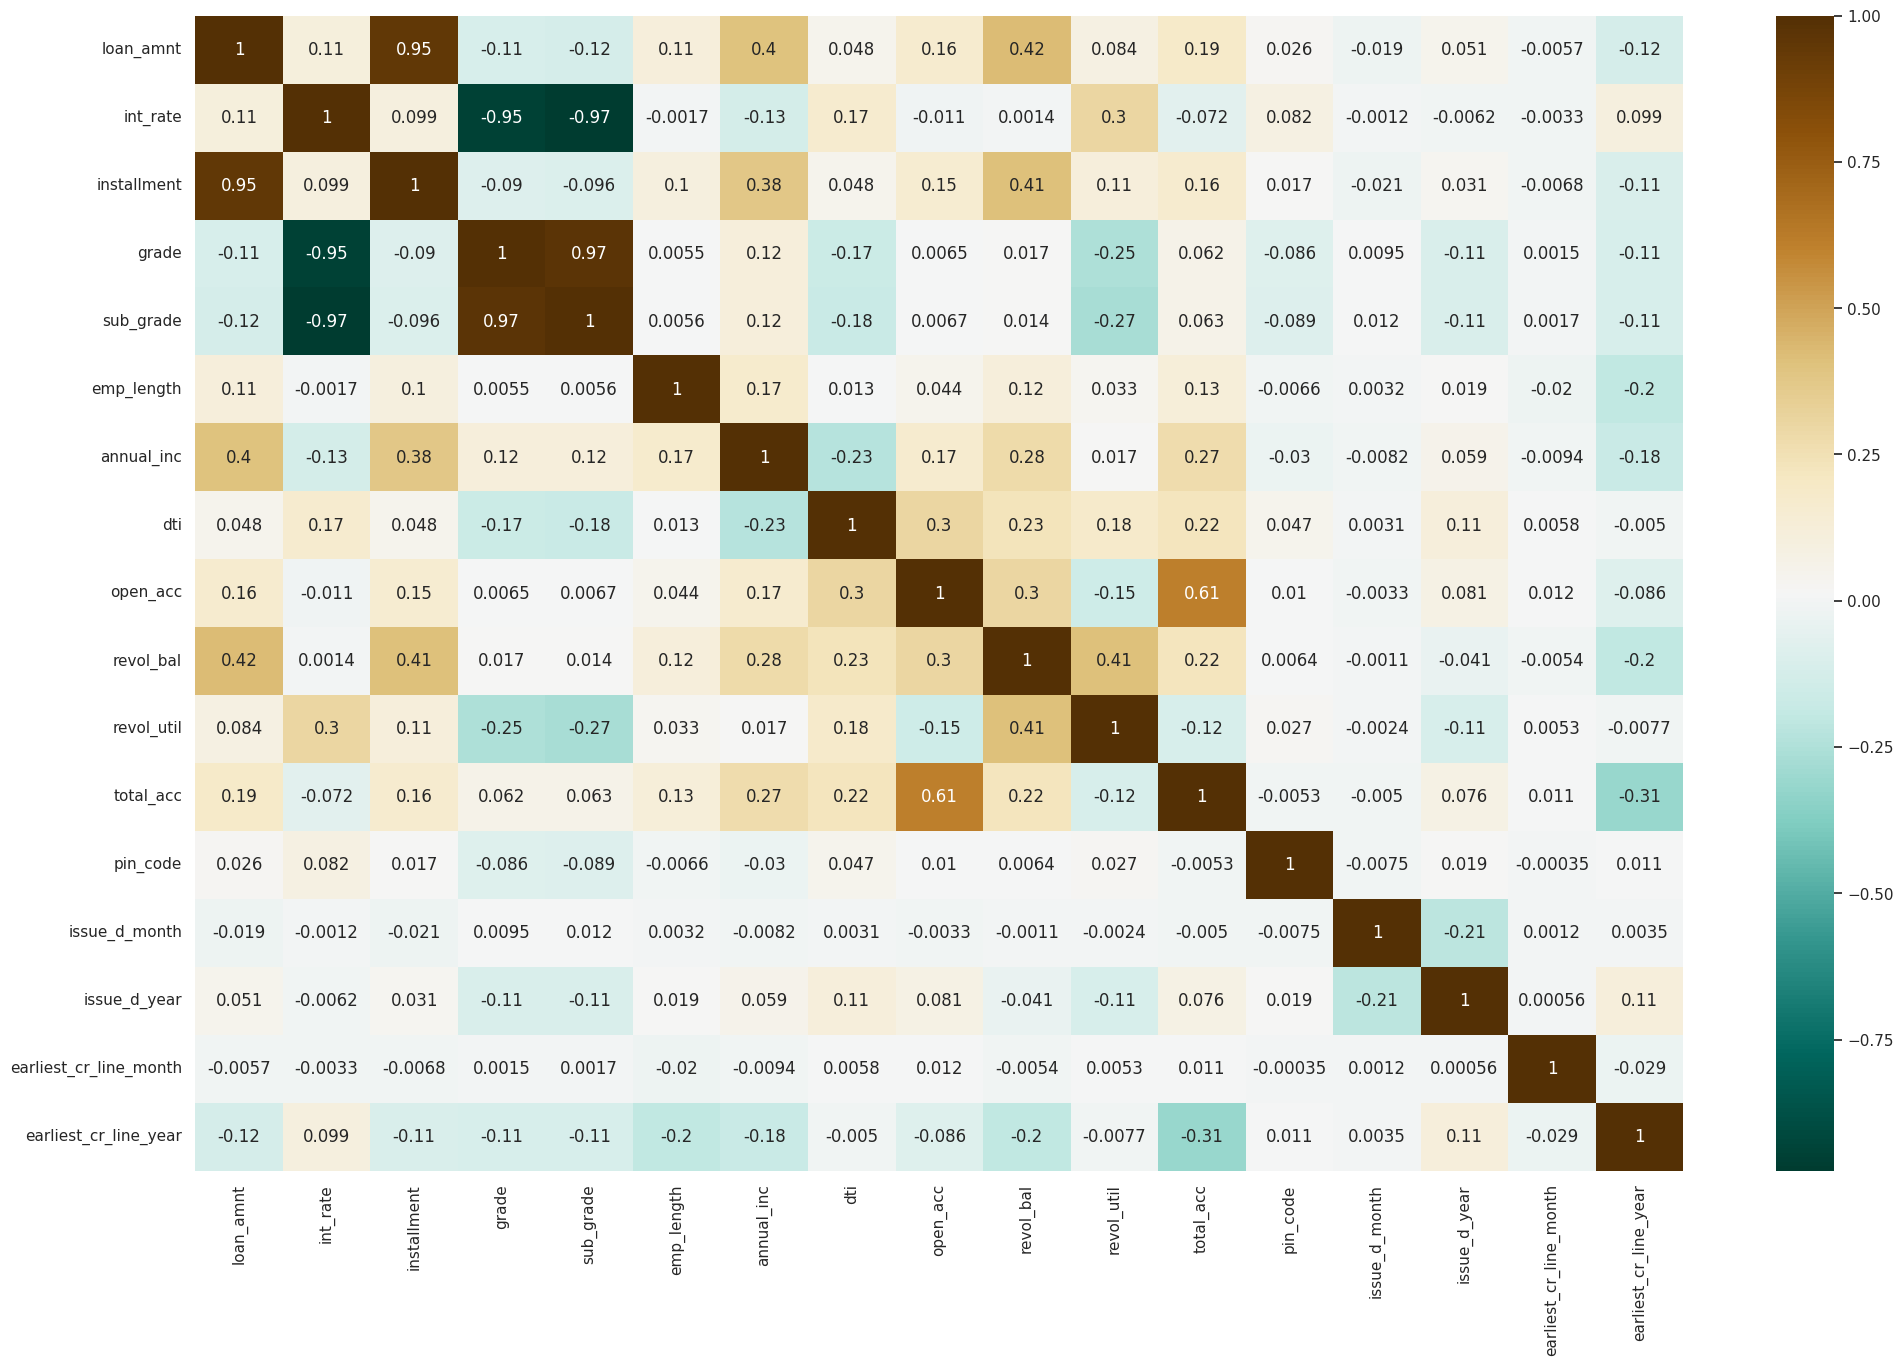

In [ ]:
plt.figure(figsize=(24,15))
sns.heatmap(df.corr(),annot=True,cmap='BrBG_r')

plt.show()

## 7. Univariate and Bivariate Analysis

### 7.1 Univariate Analysis (Categorical Data).

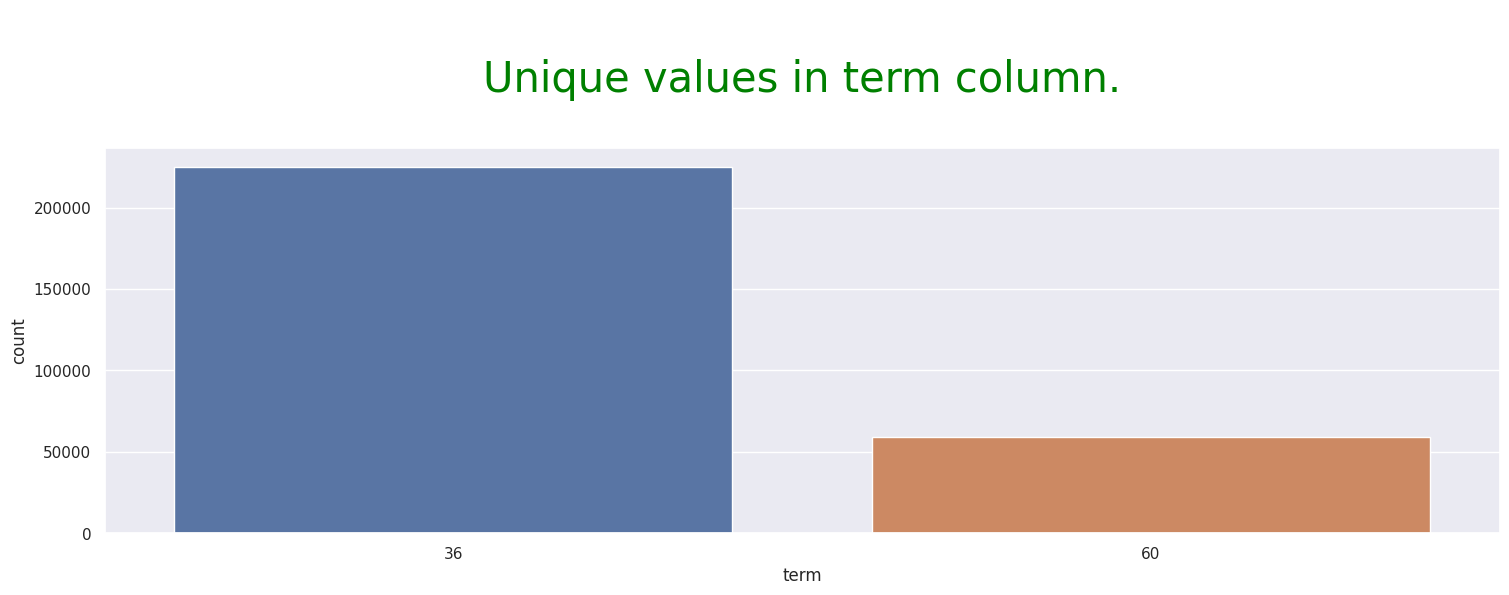

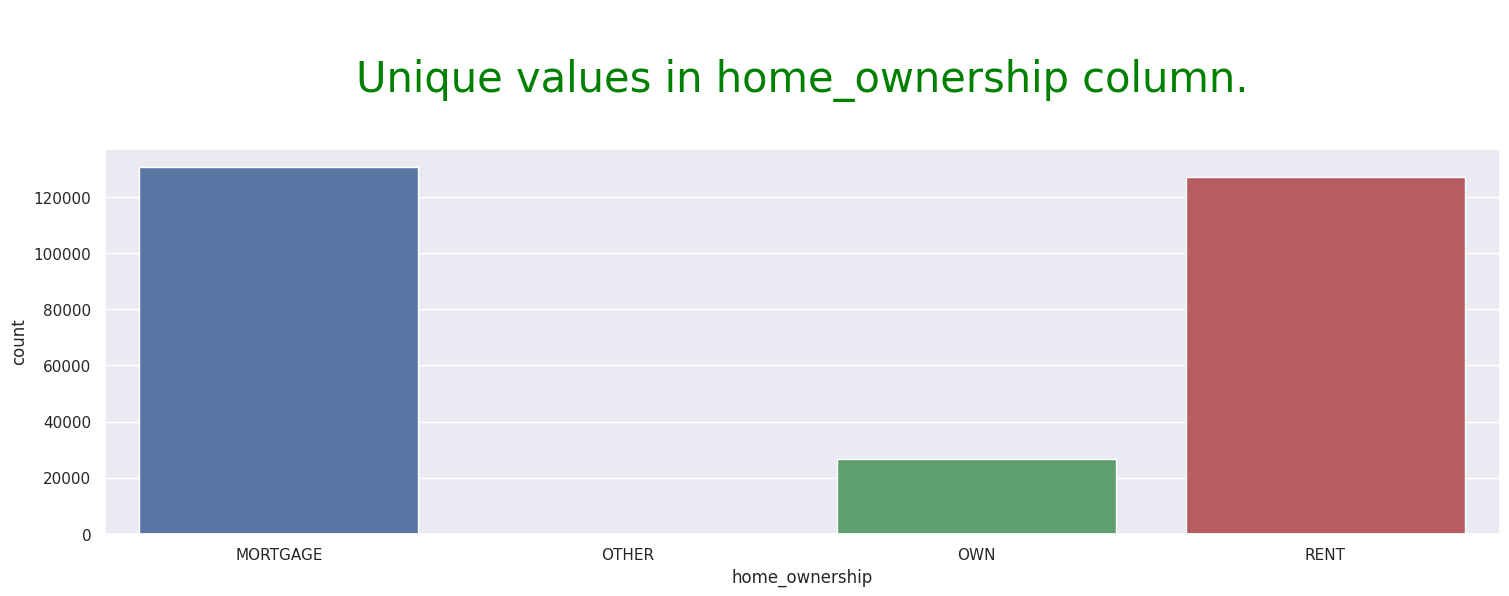

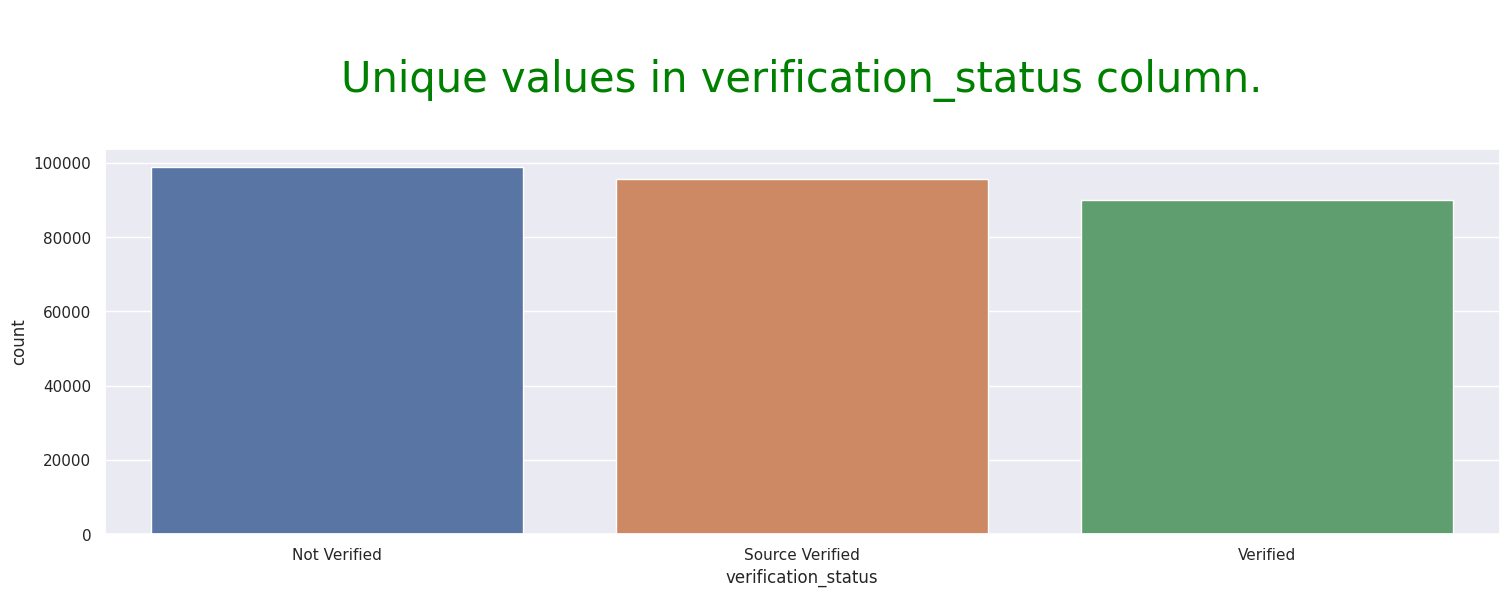

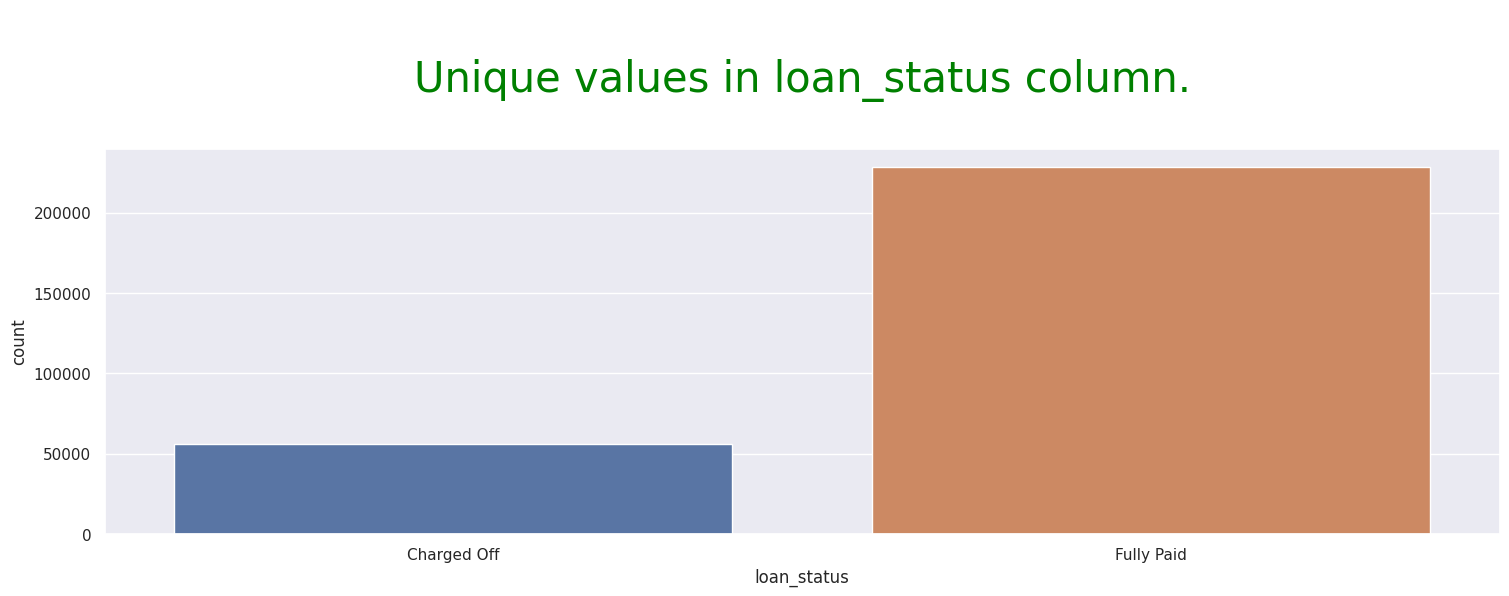

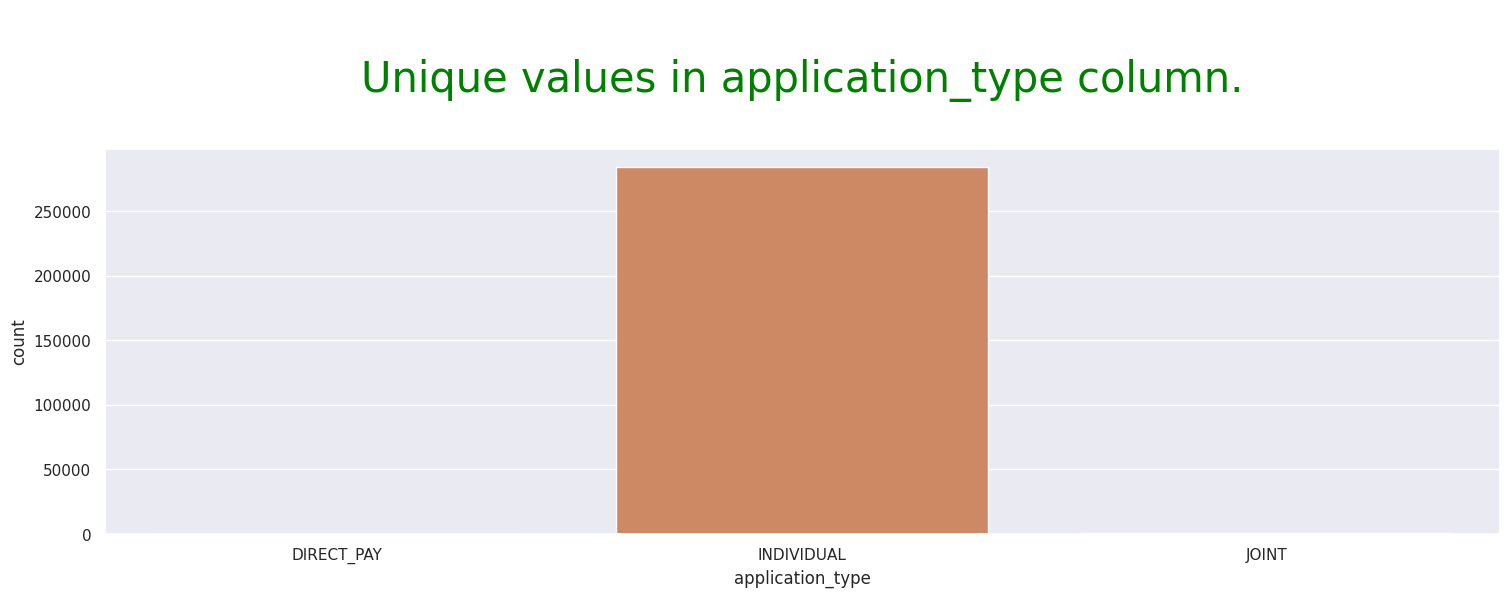

In [ ]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

### 7.2 Univariate Analysis (Discrete Data)

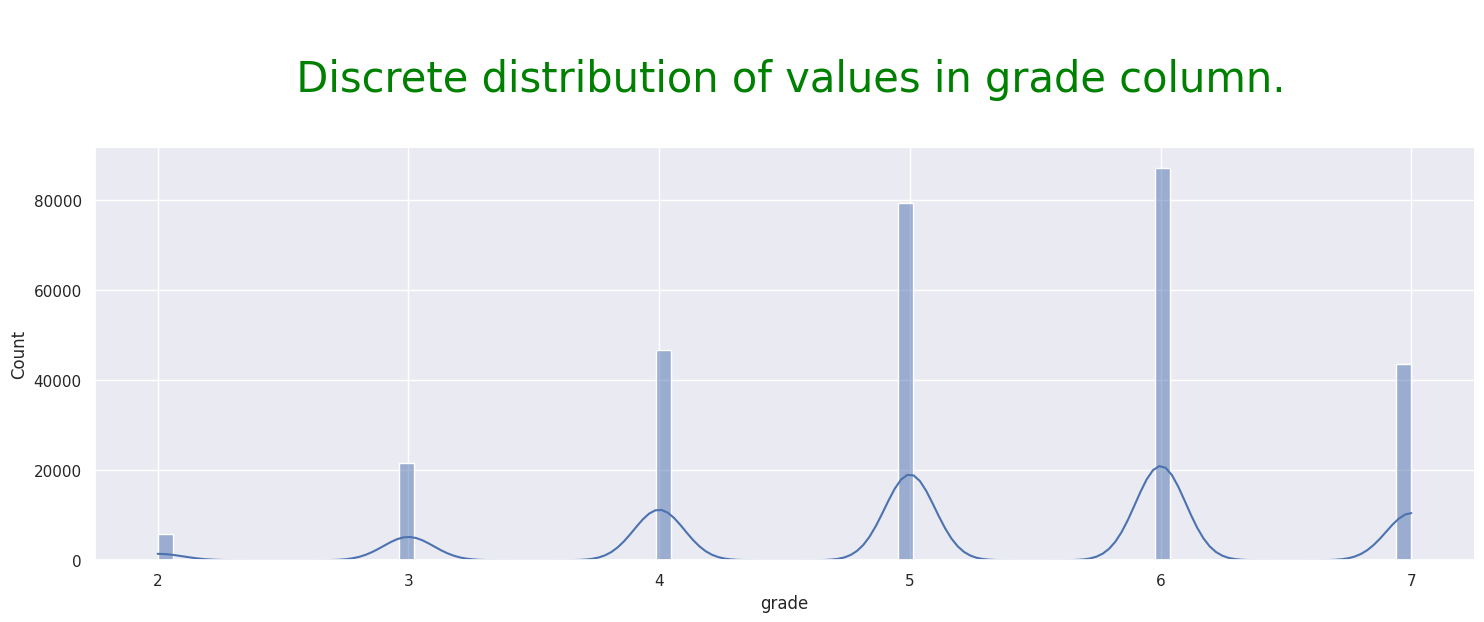

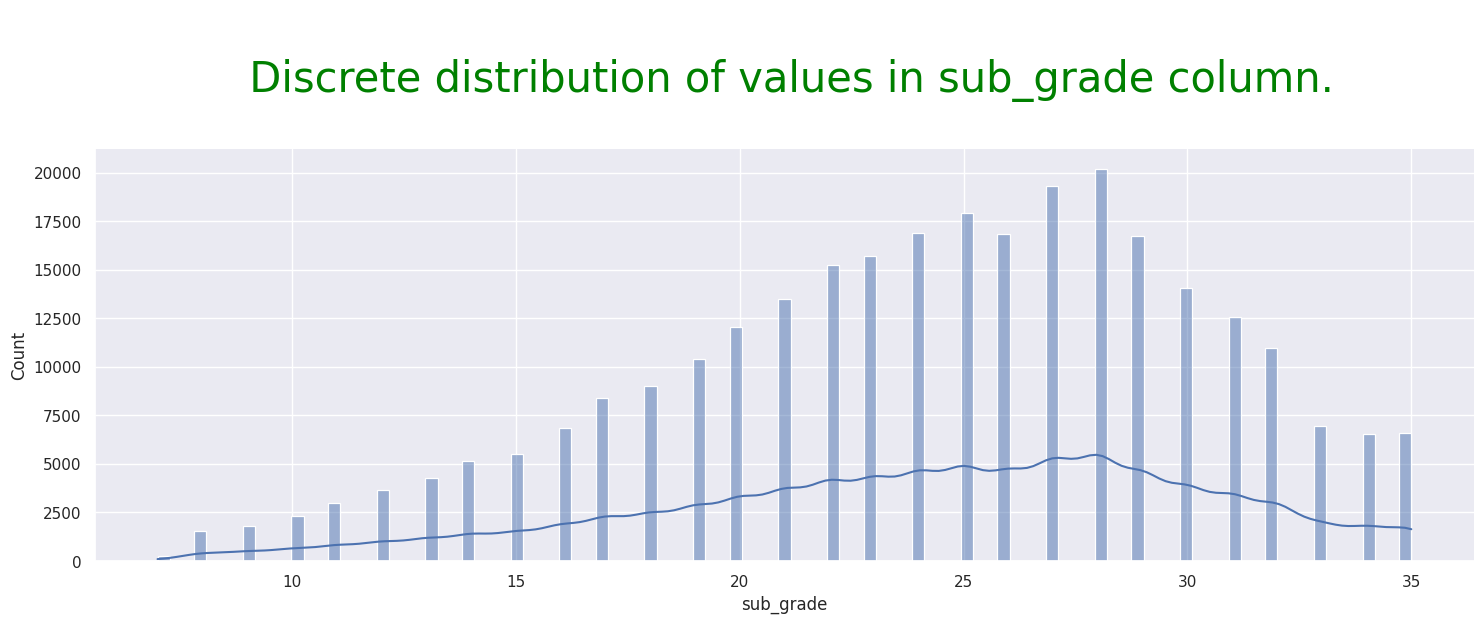

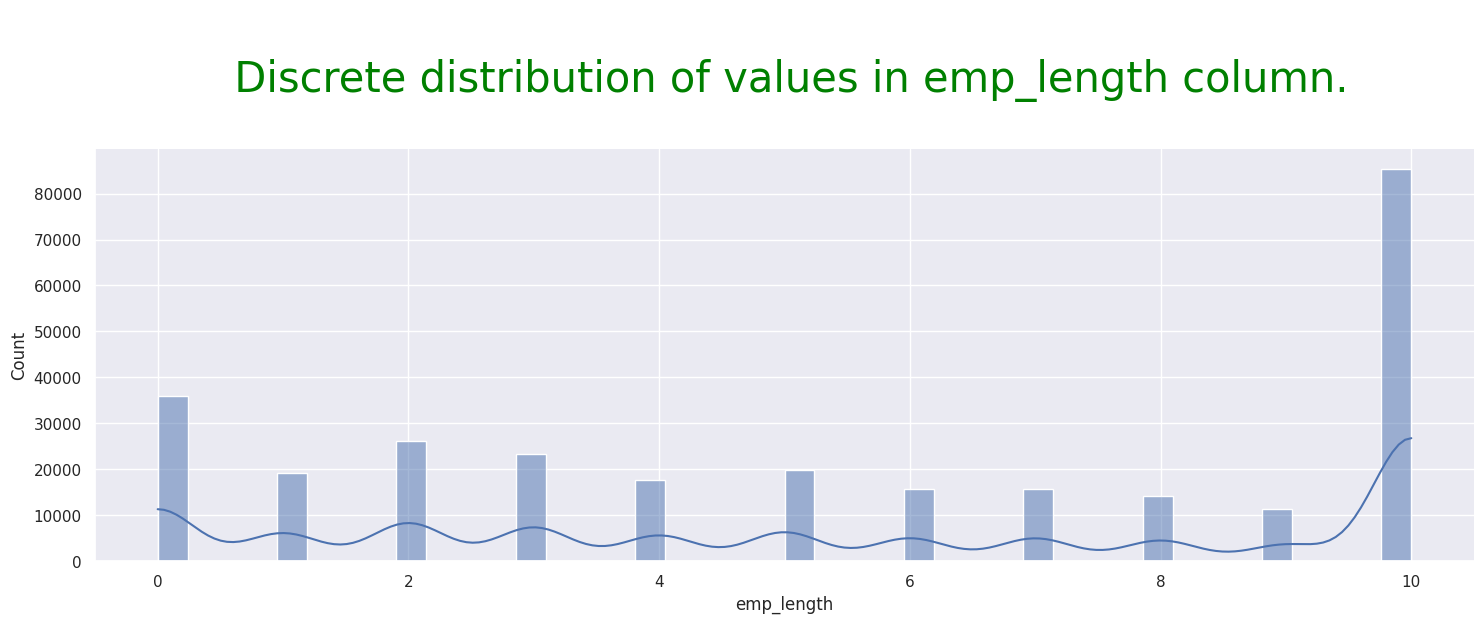

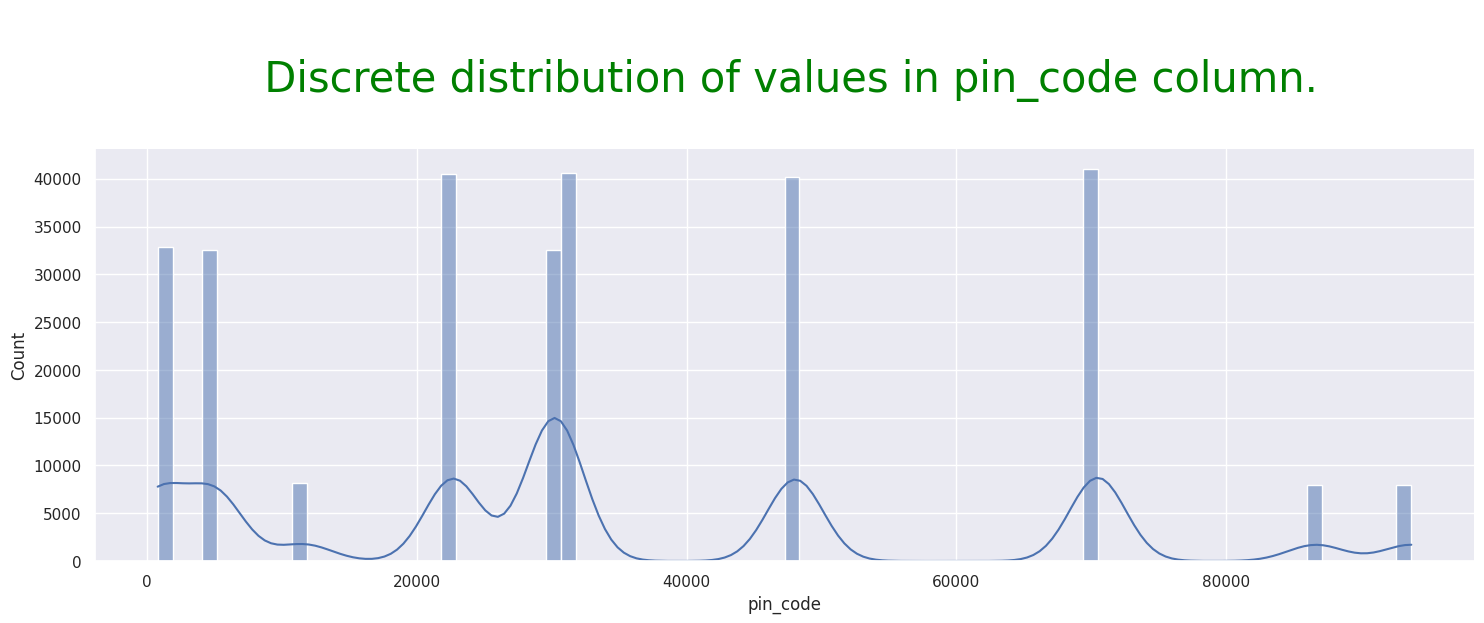

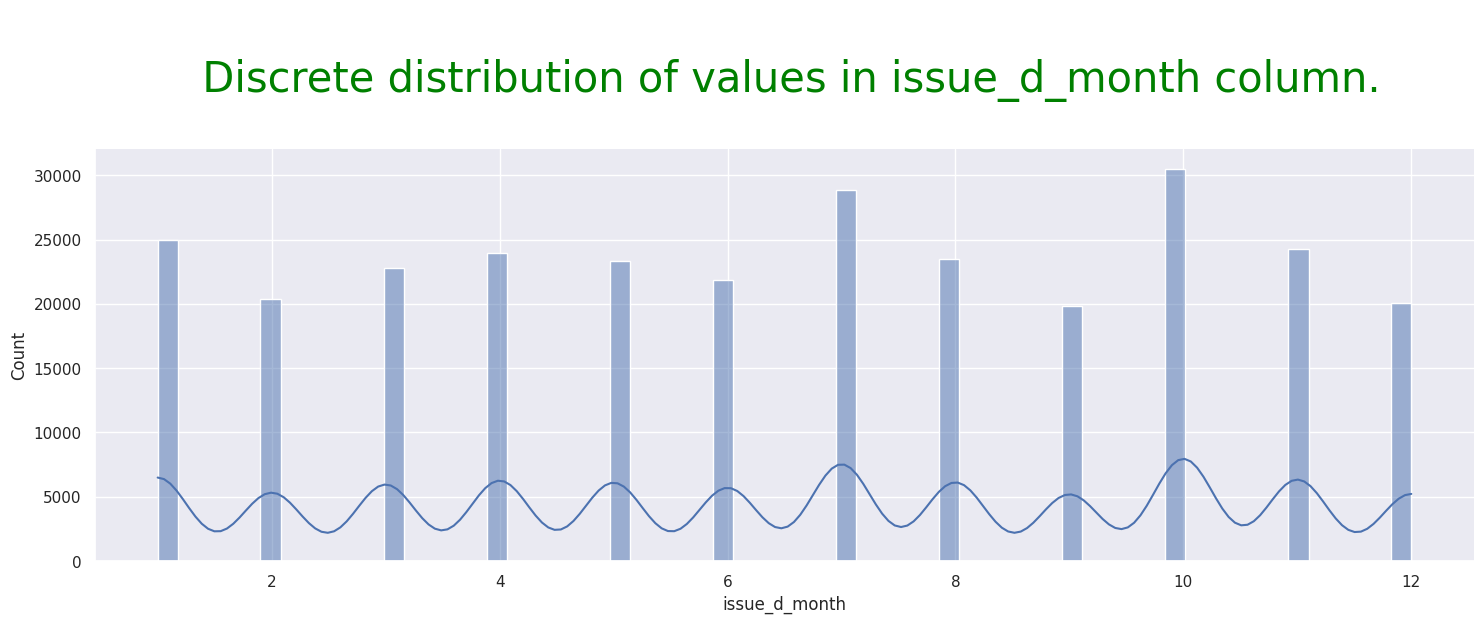

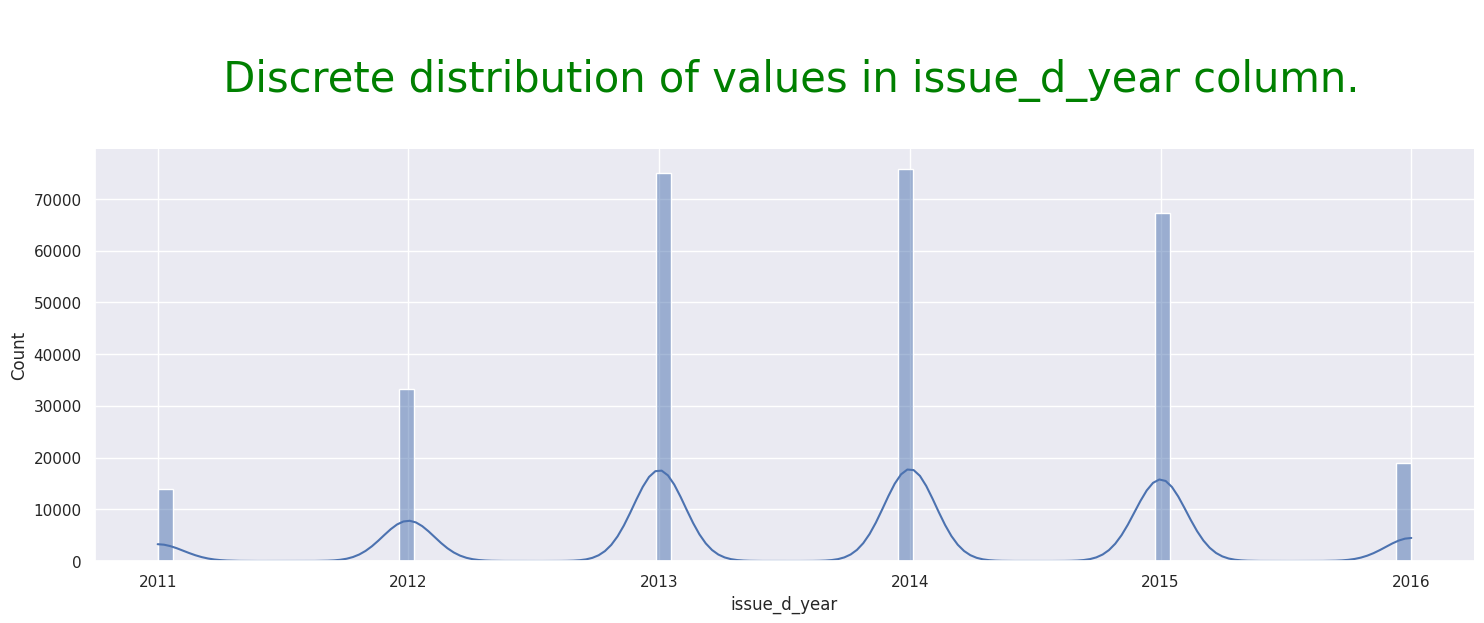

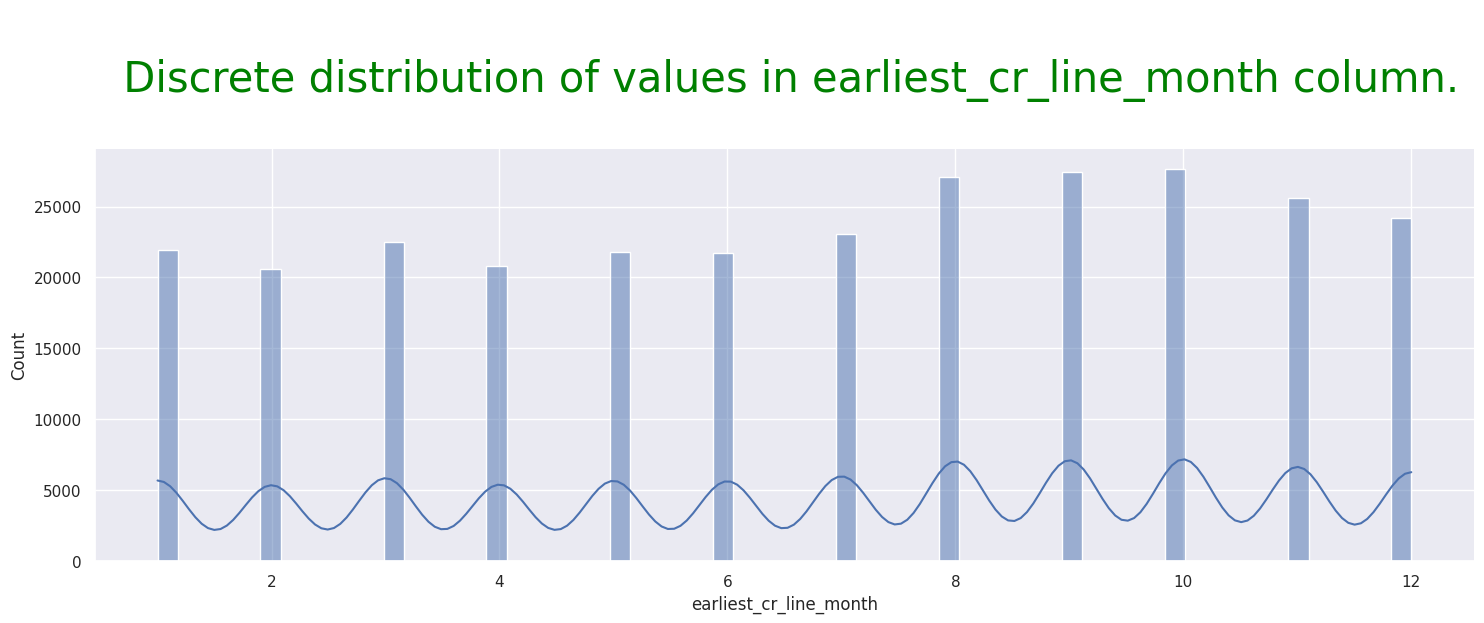

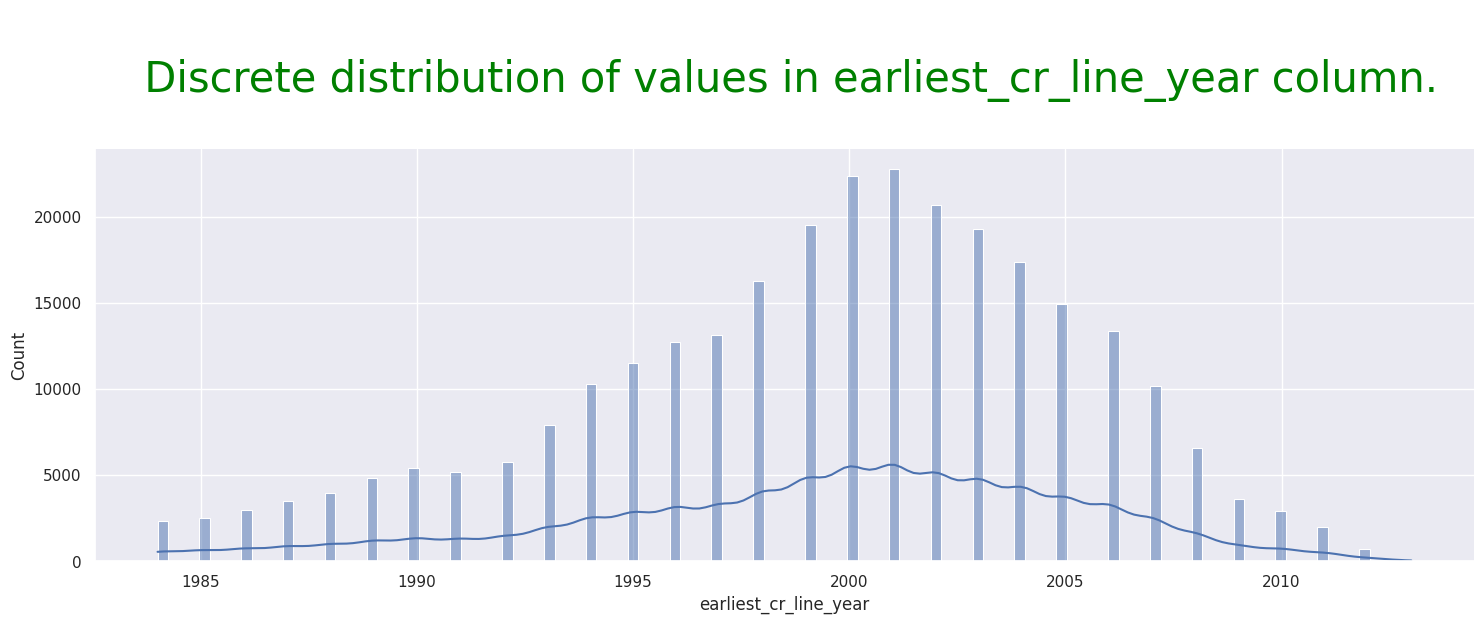

In [ ]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

### 7.3 Univariate Analysis (Continuous Data)

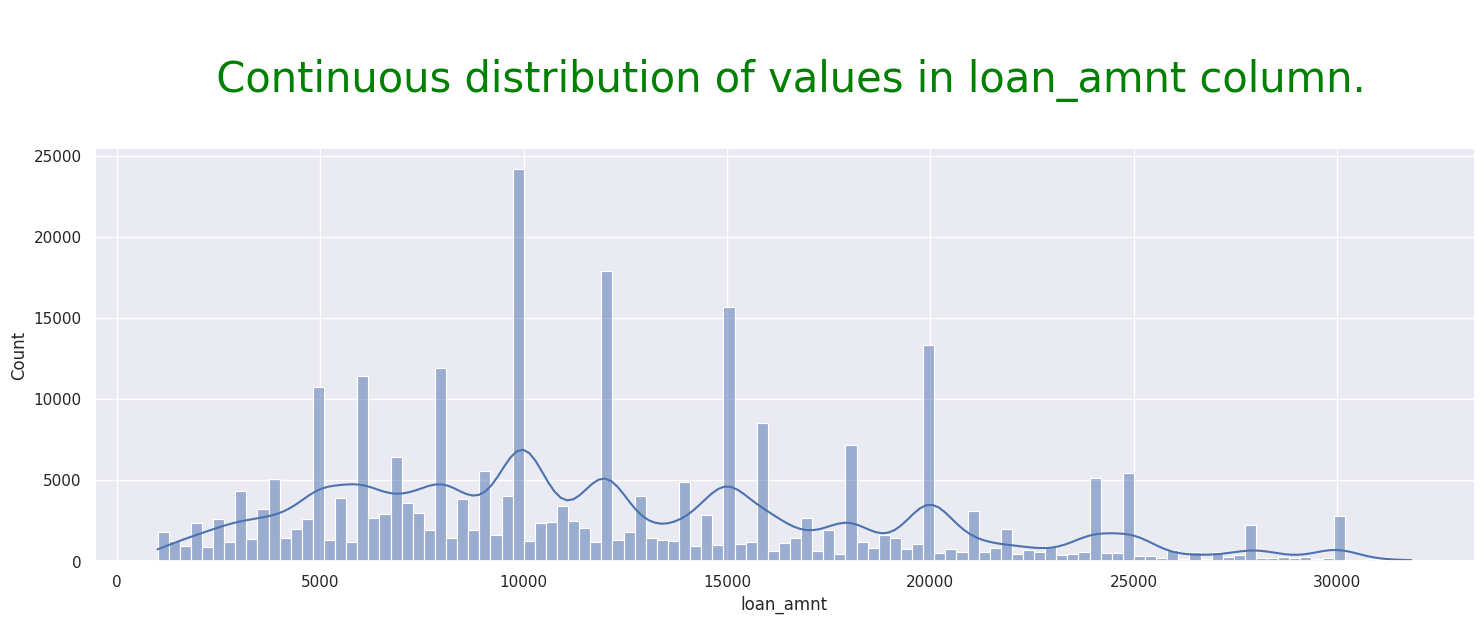

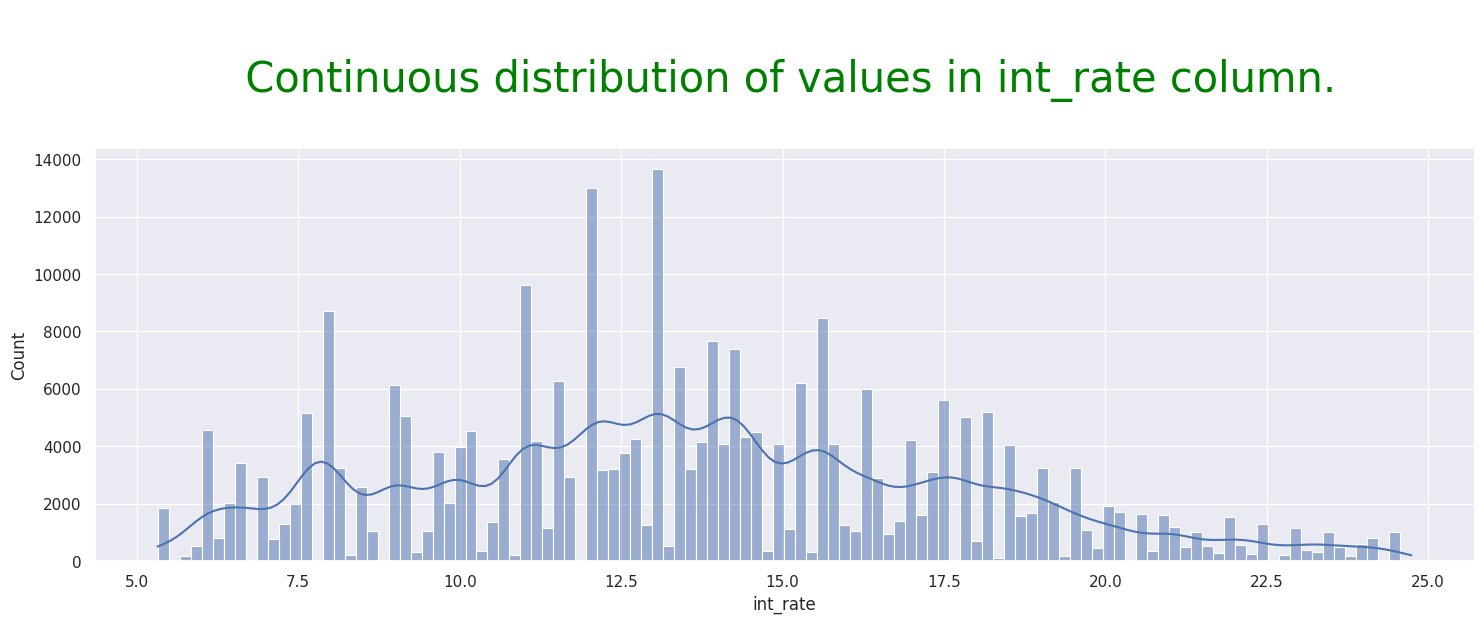

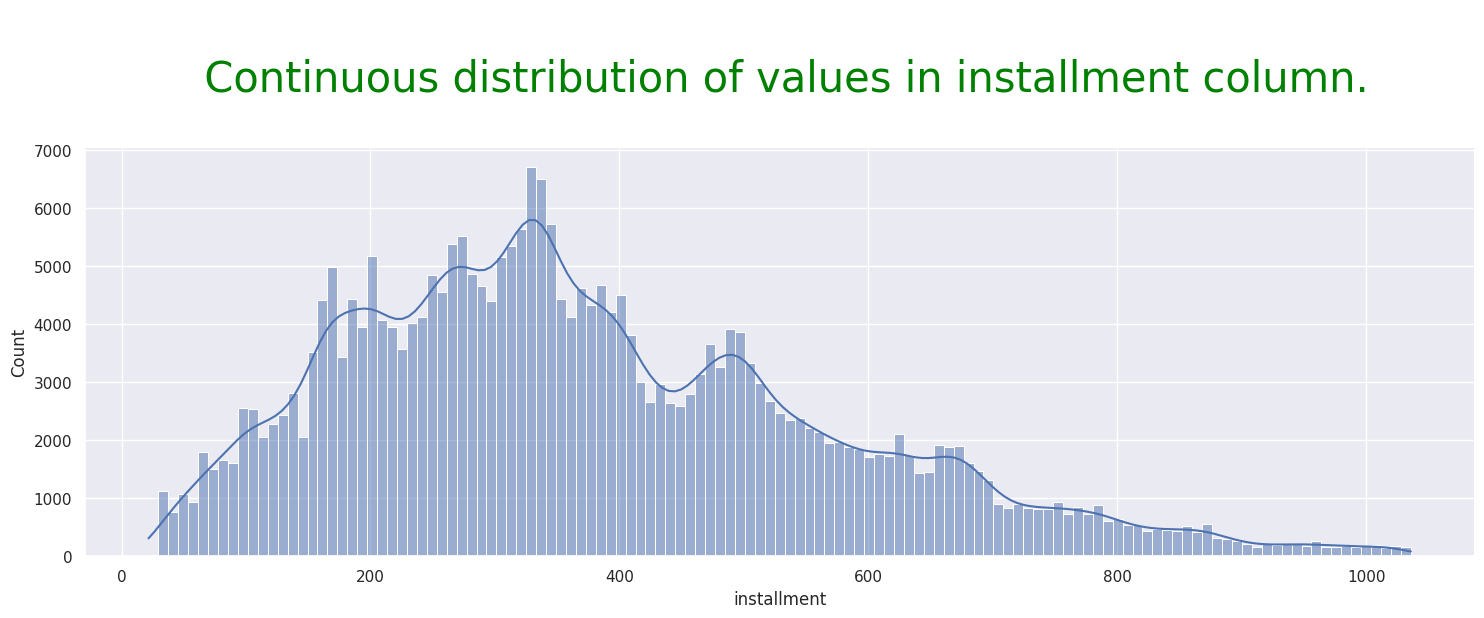

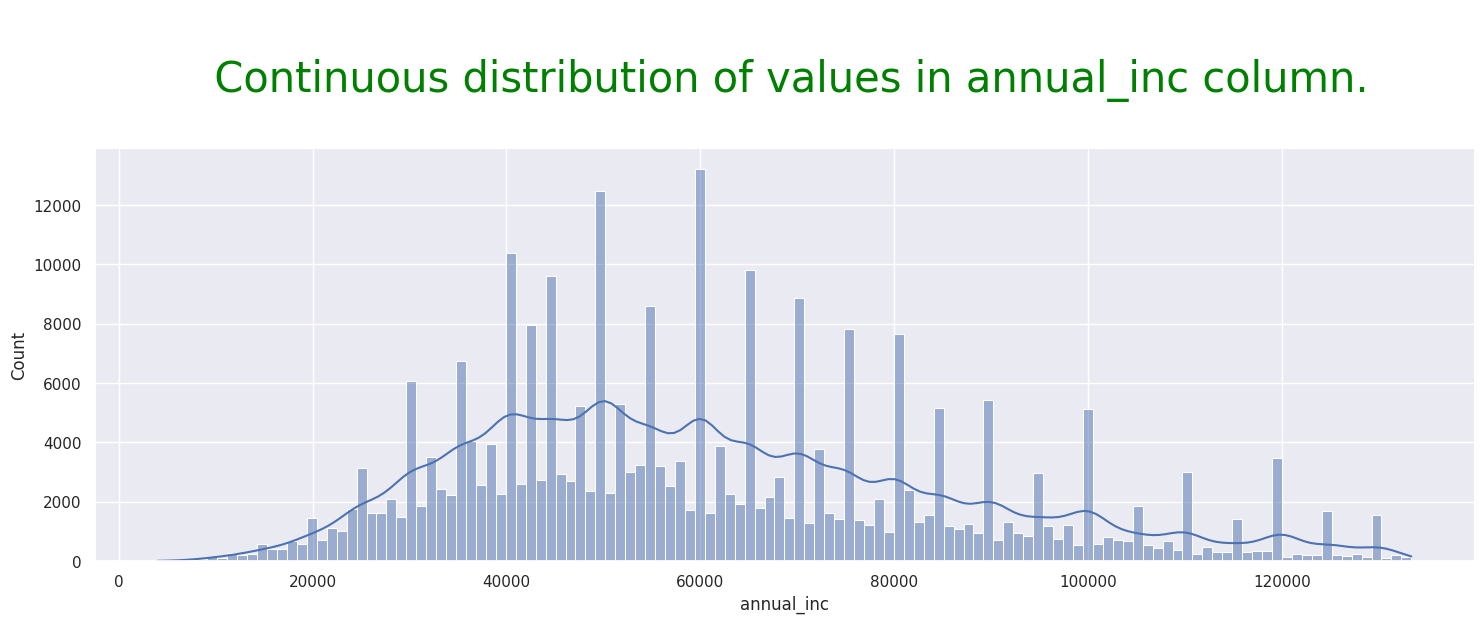

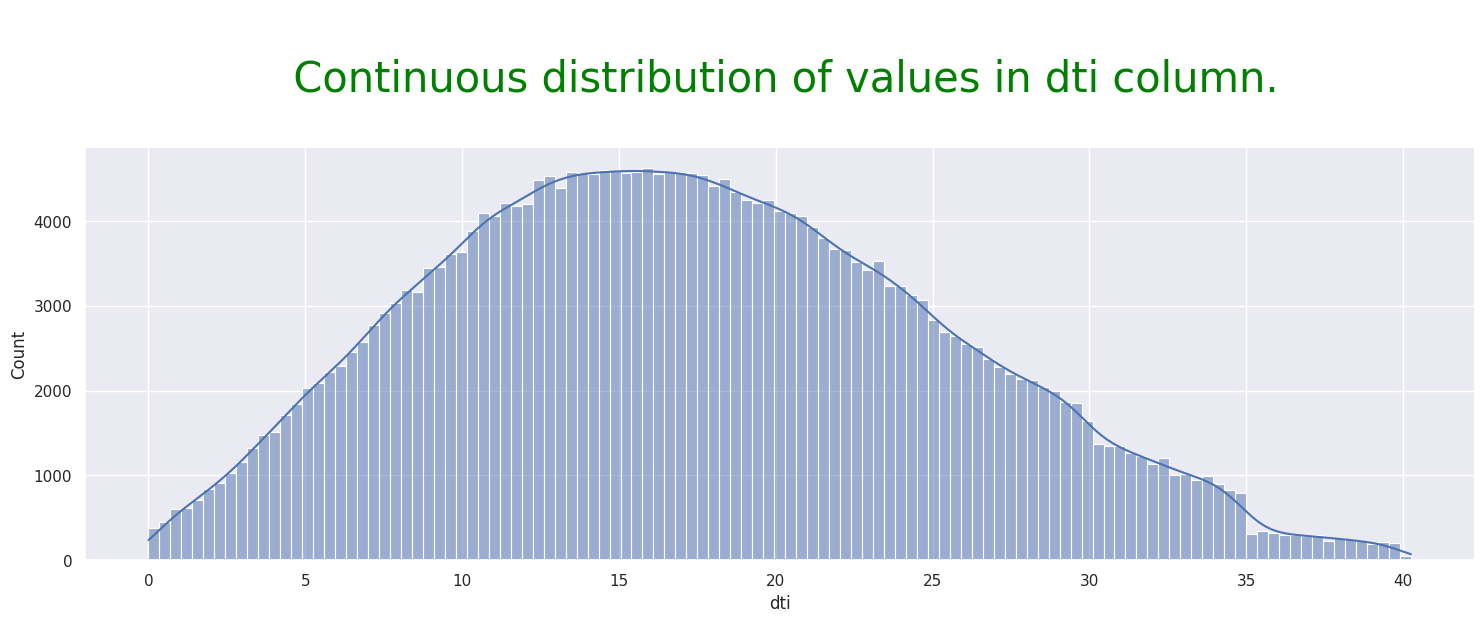

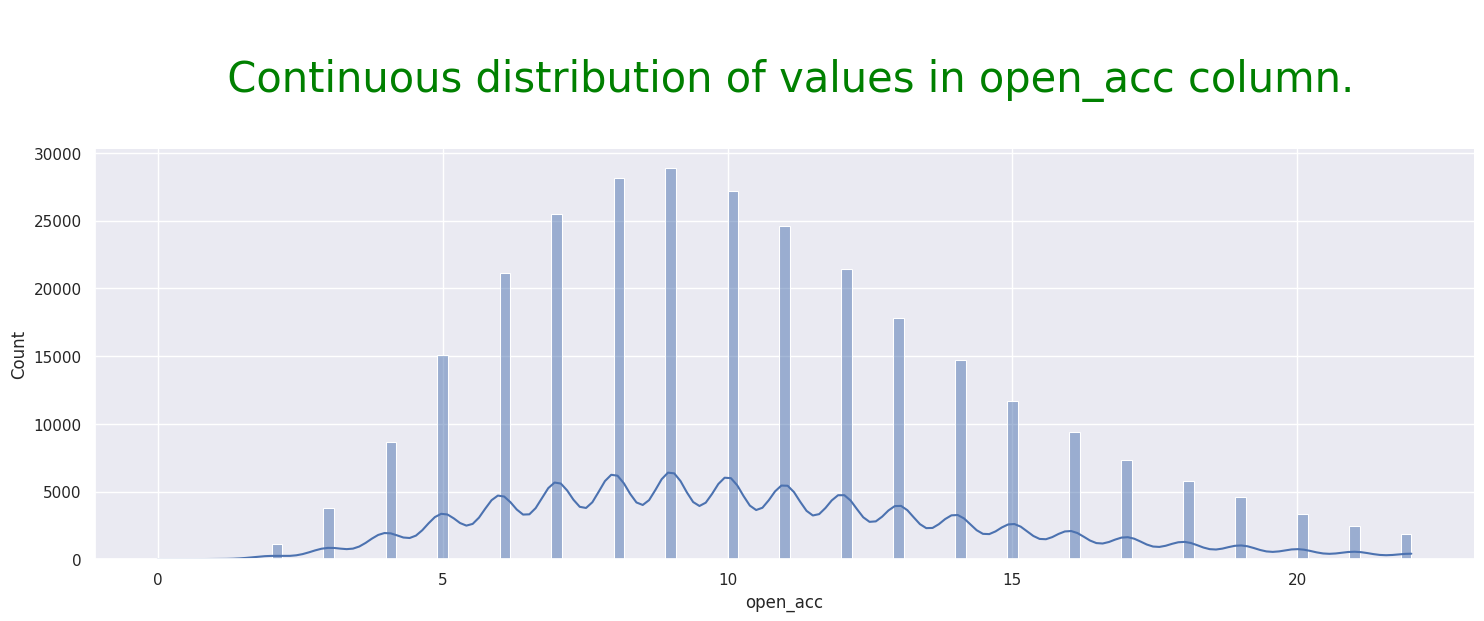

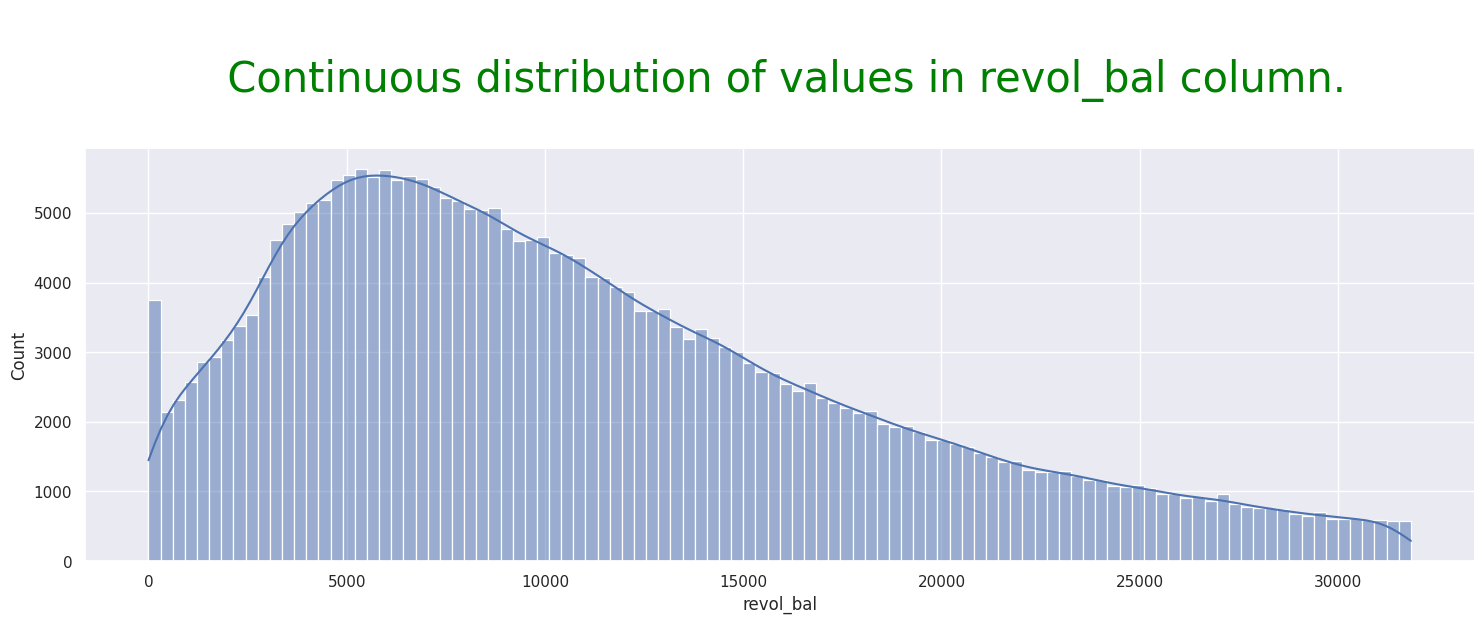

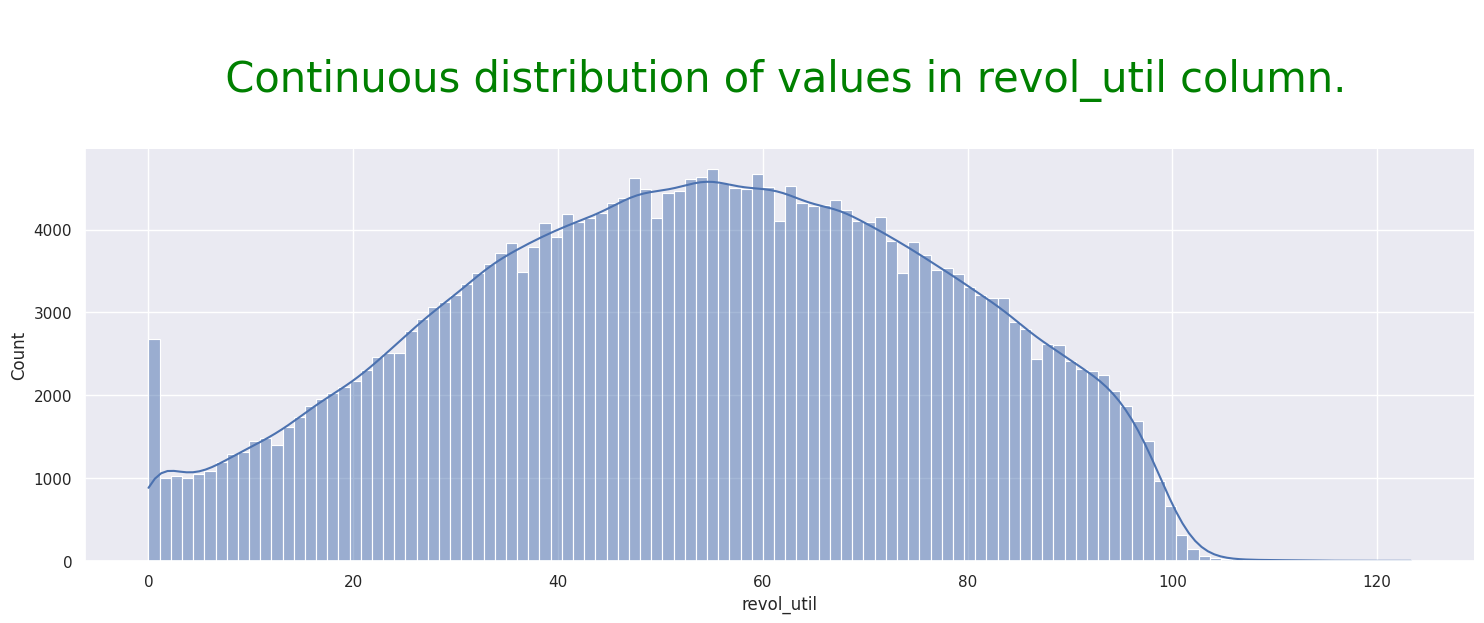

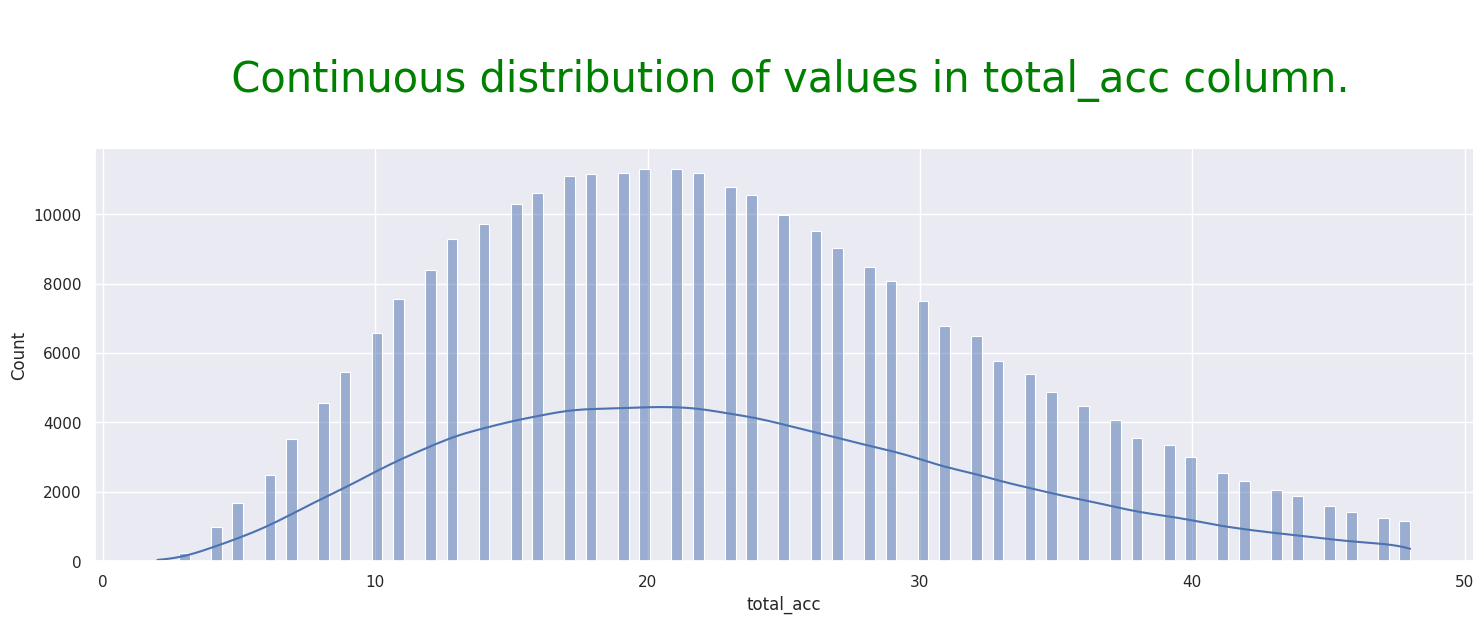

In [ ]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

### 7.4 Bivariate Analysis

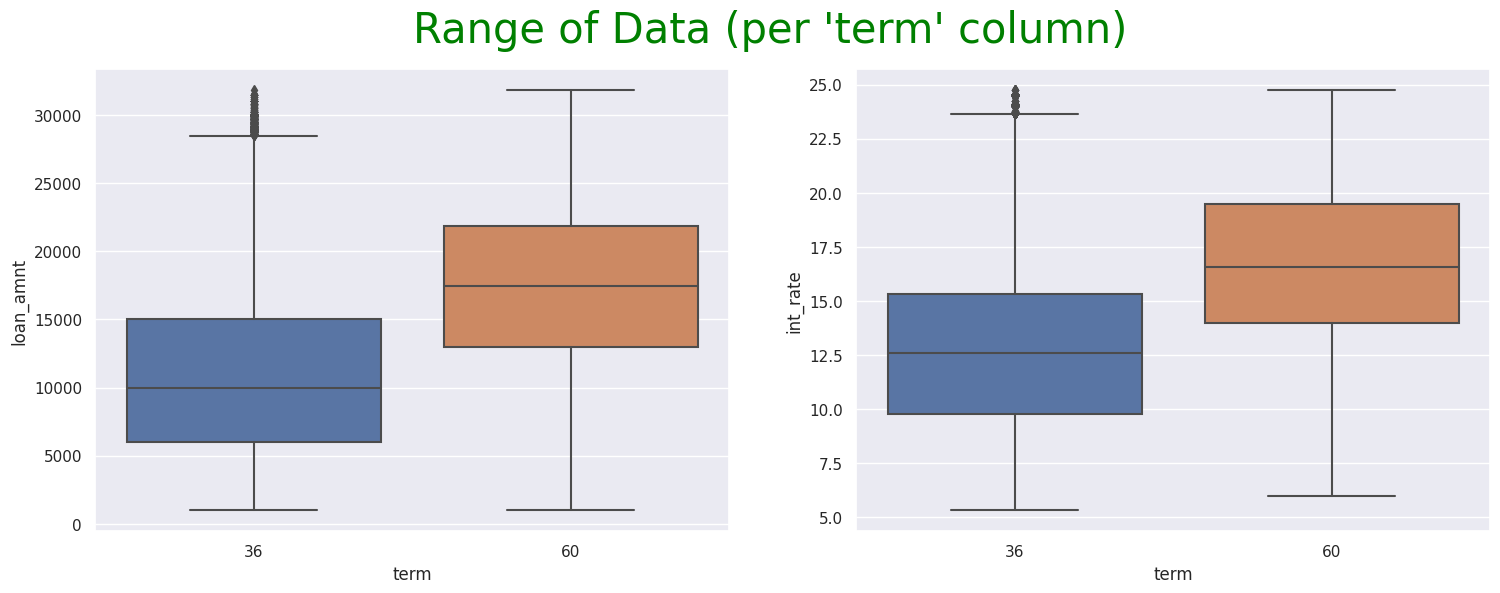

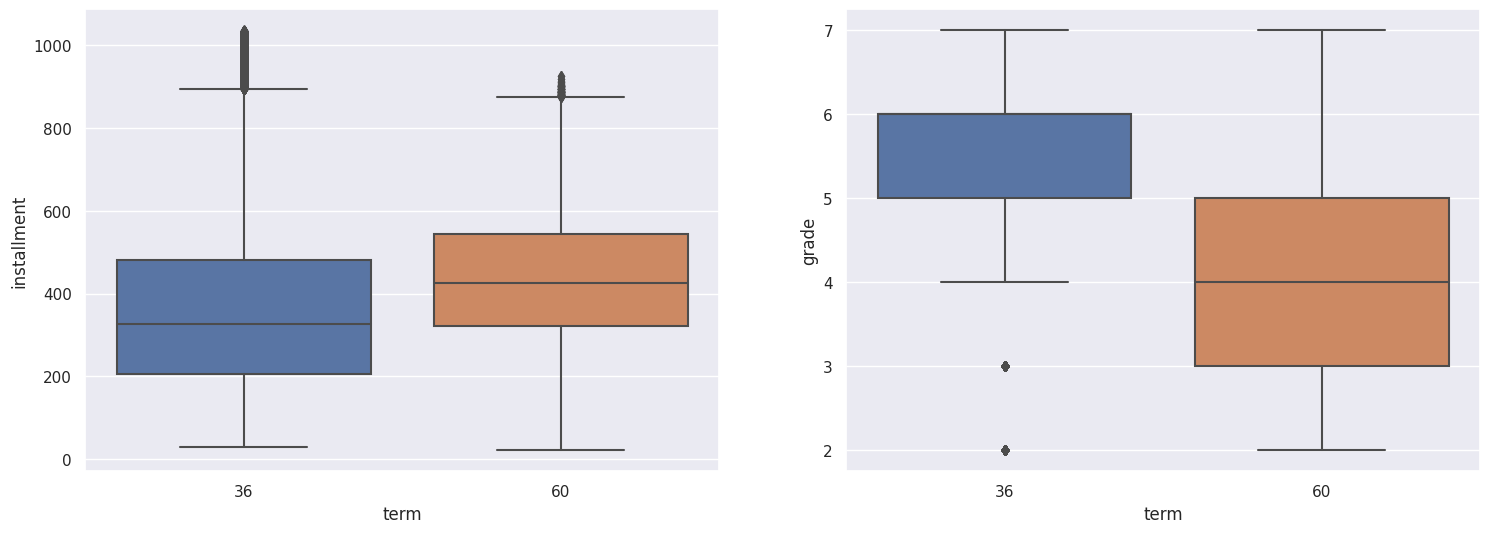

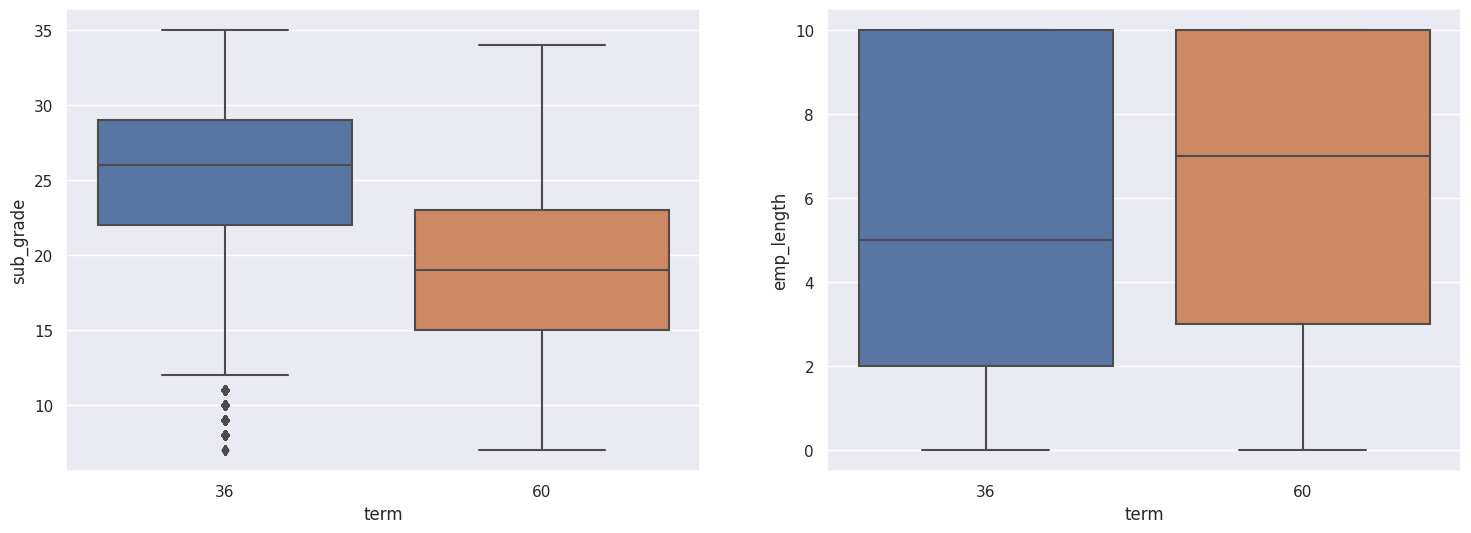

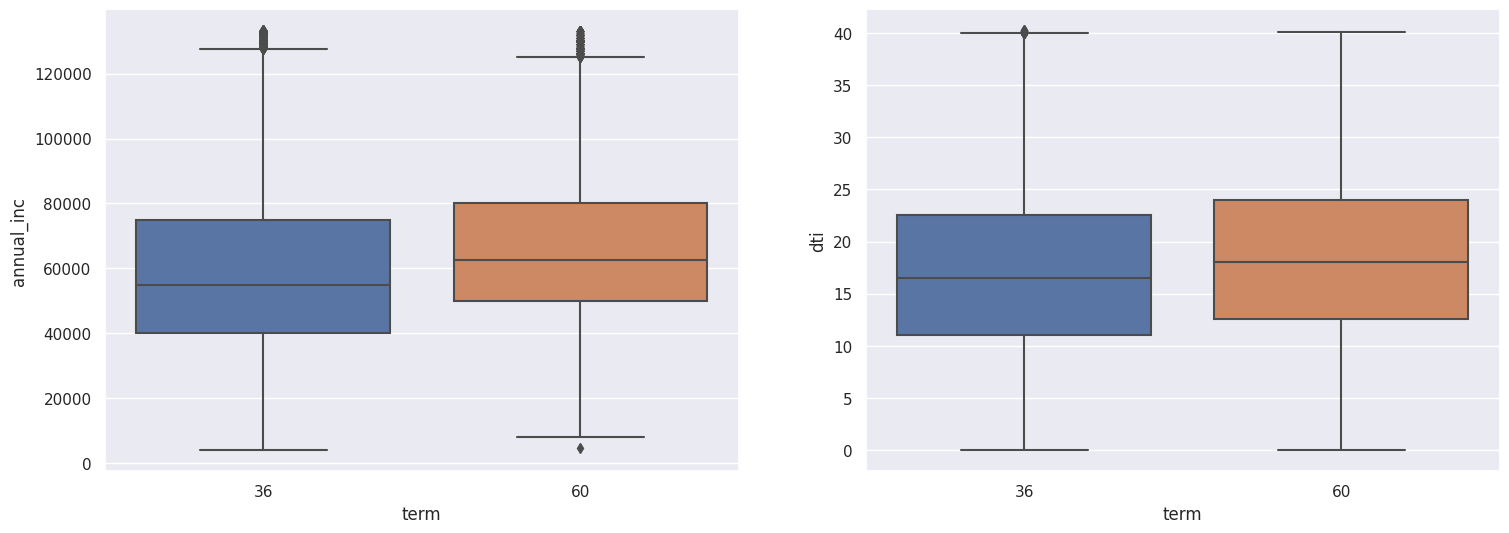

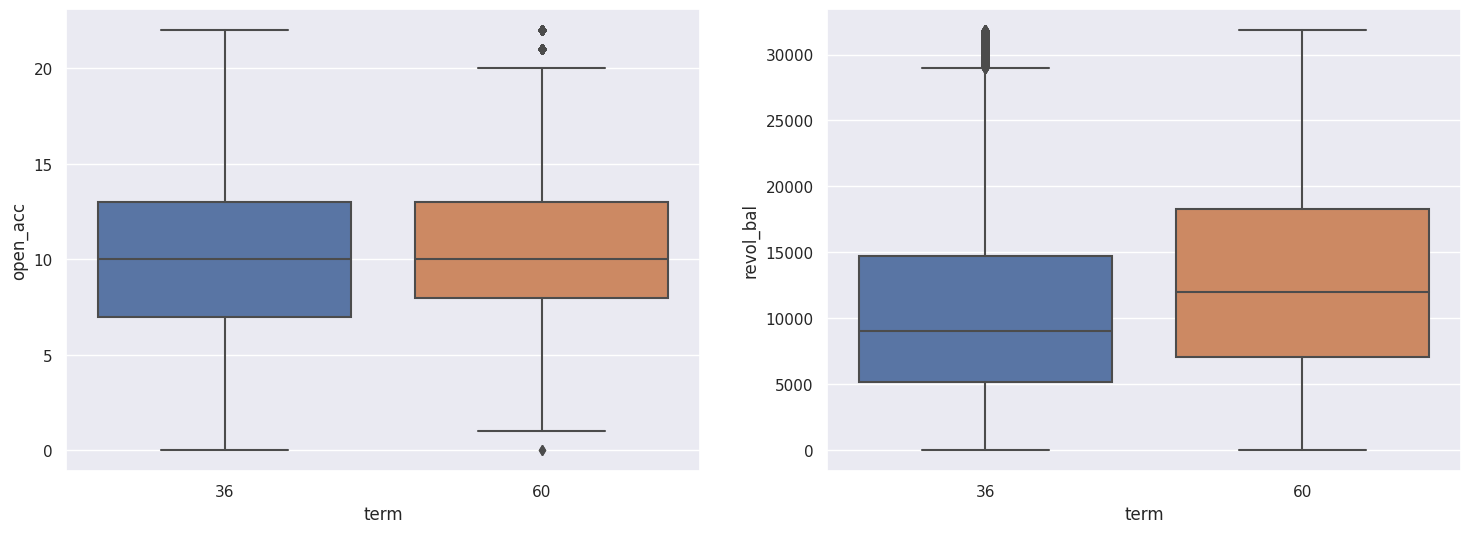

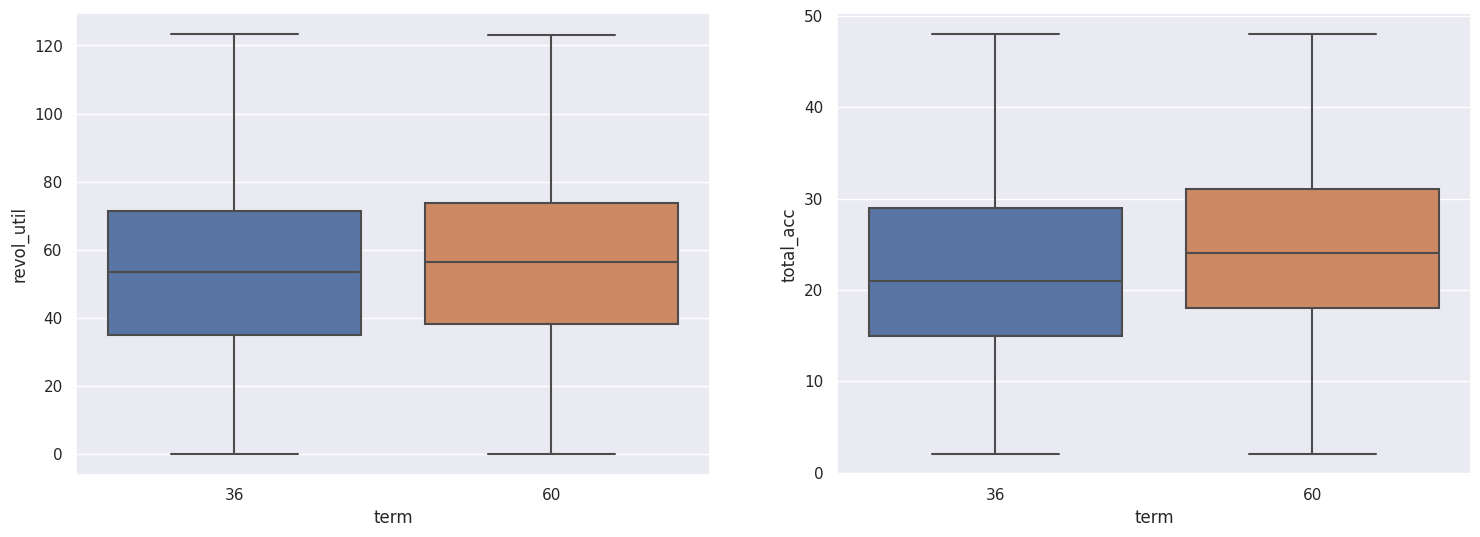

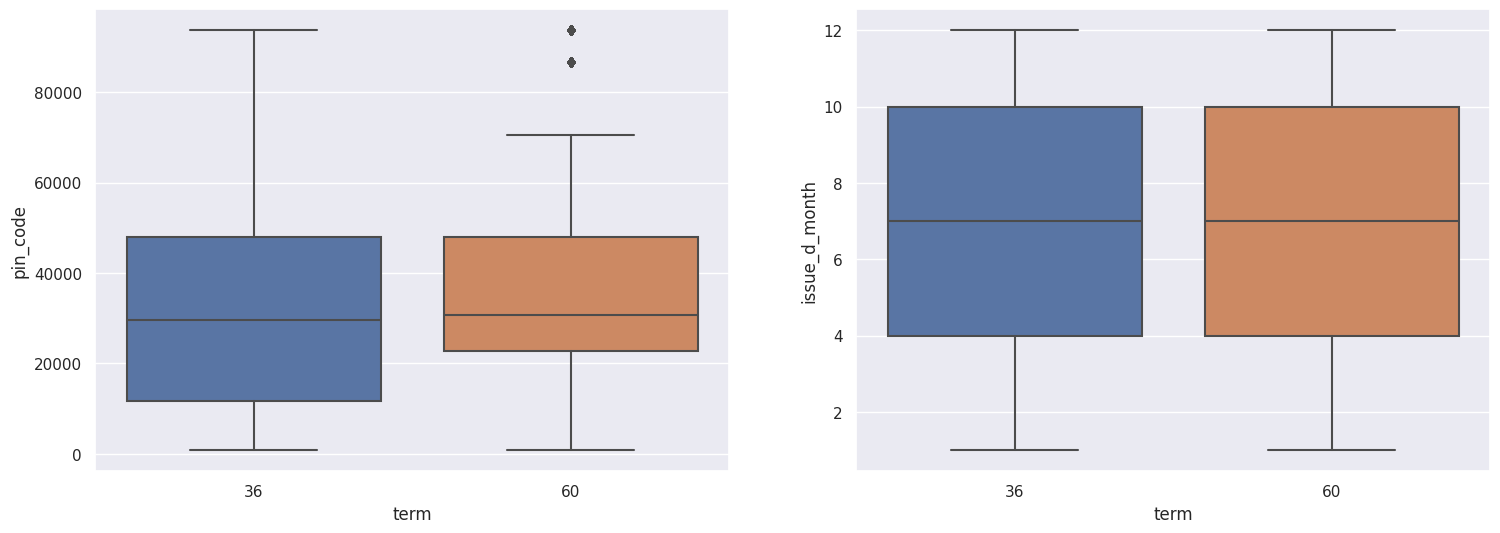

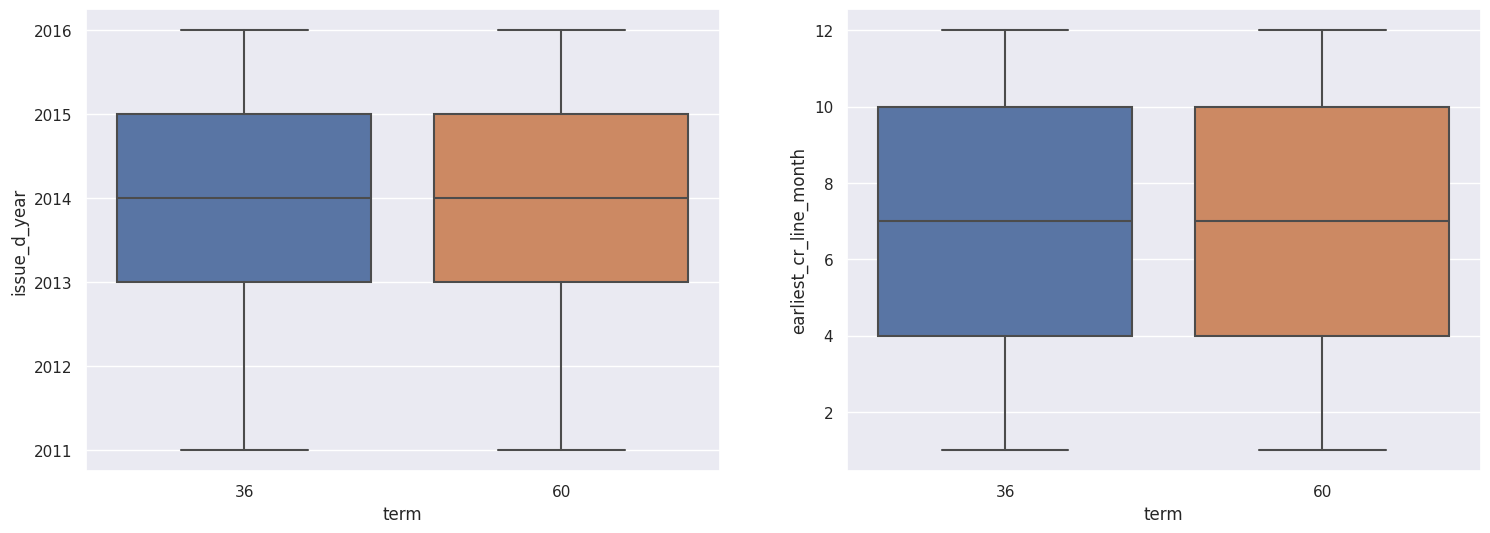

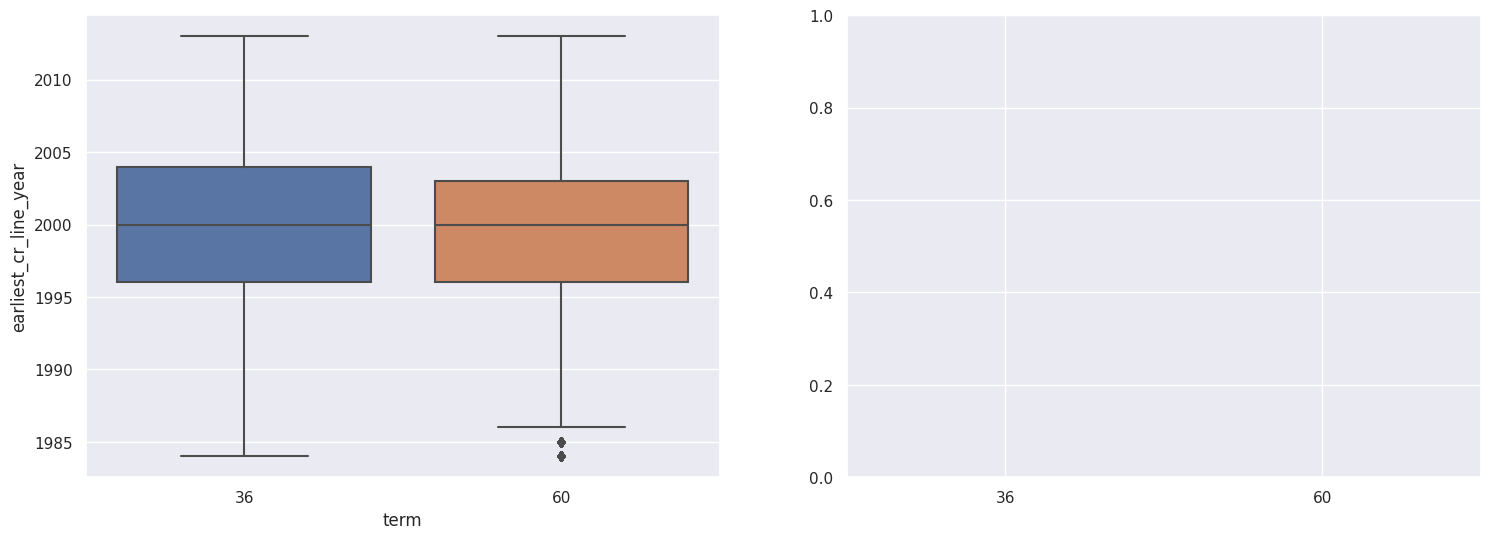

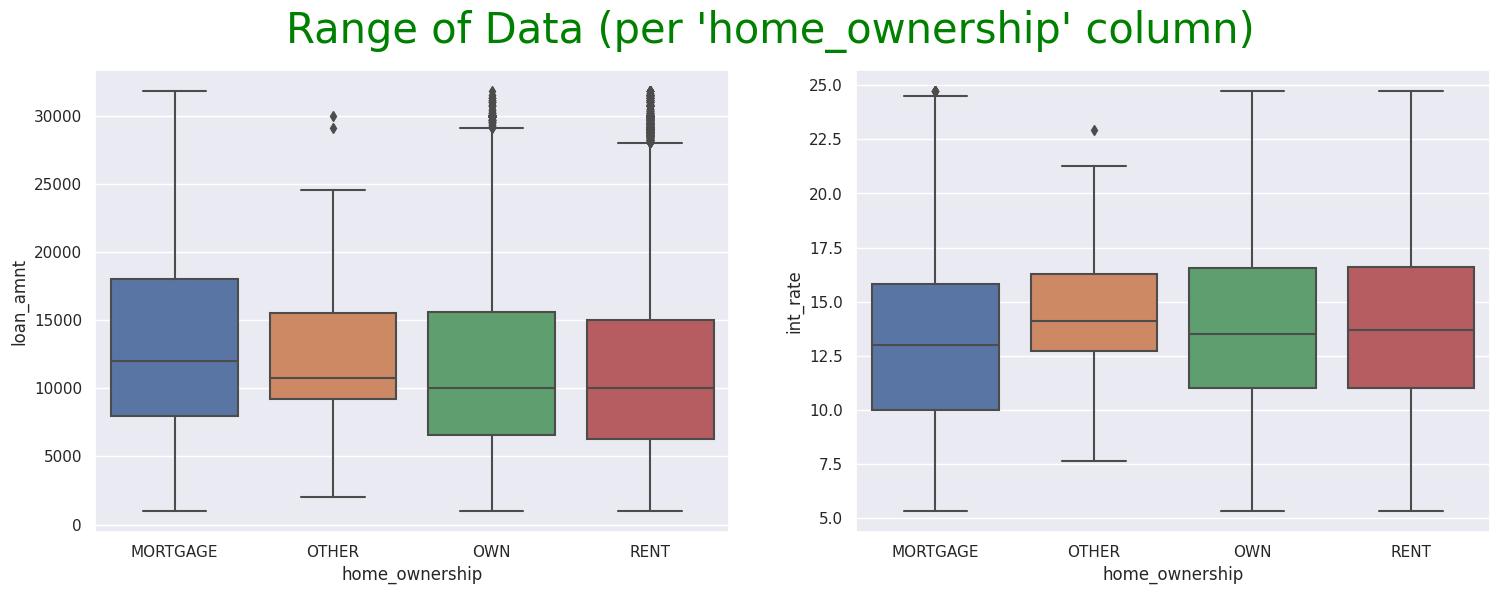

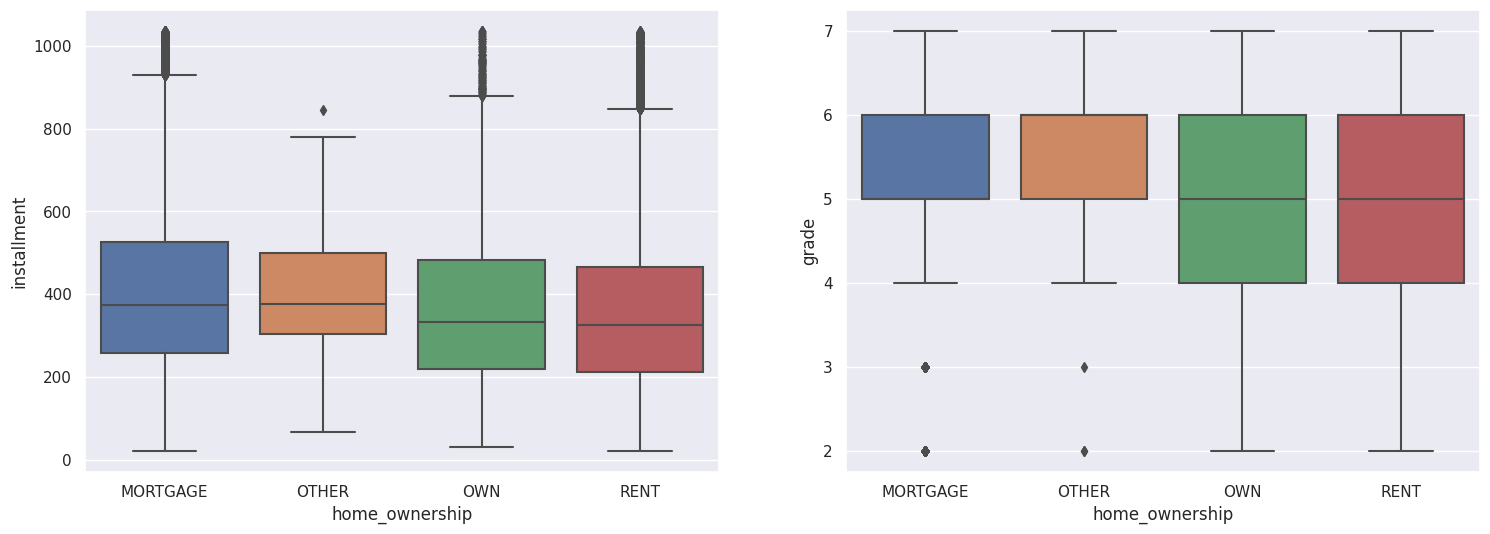

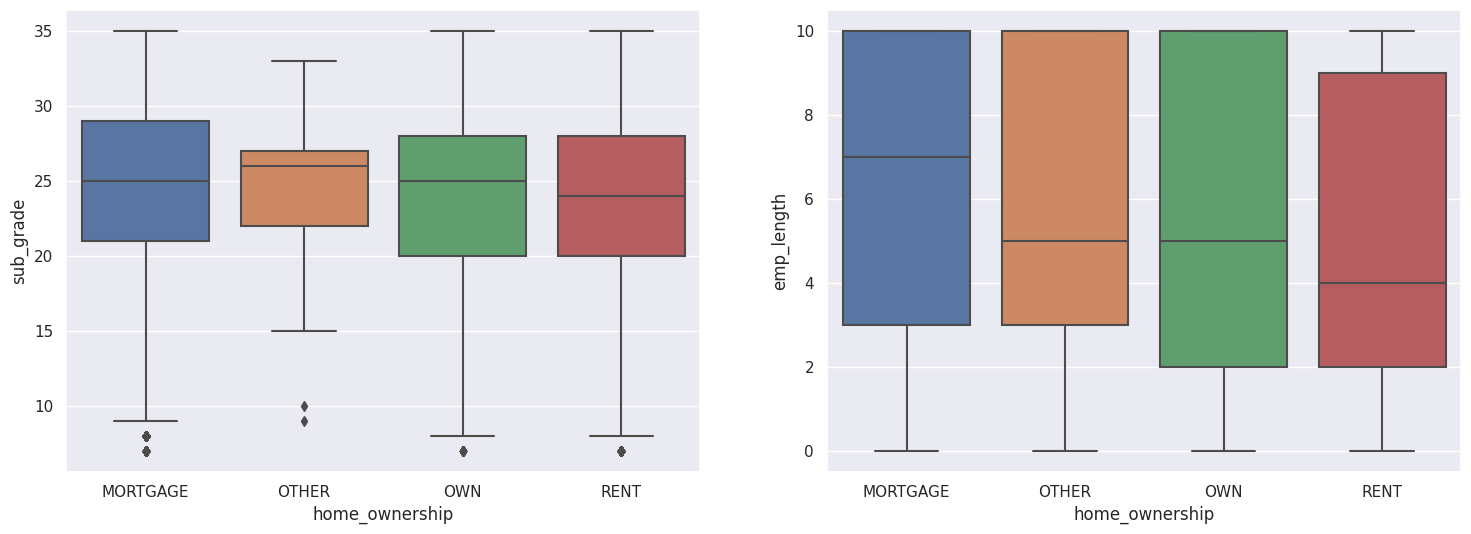

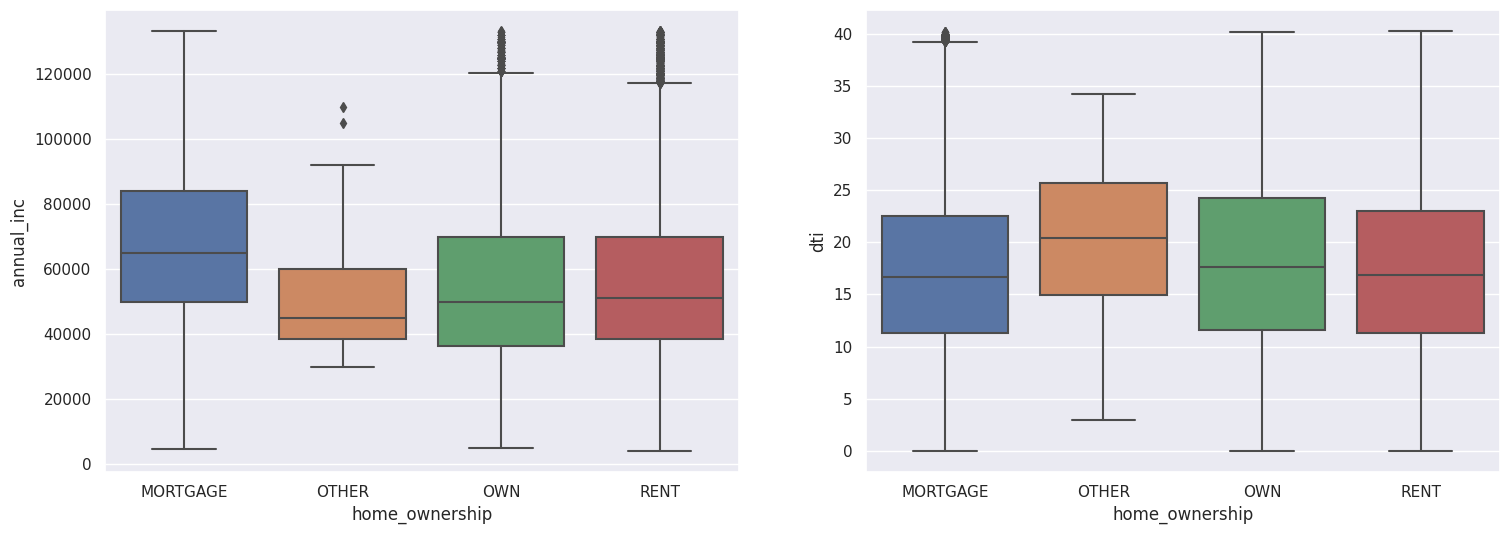

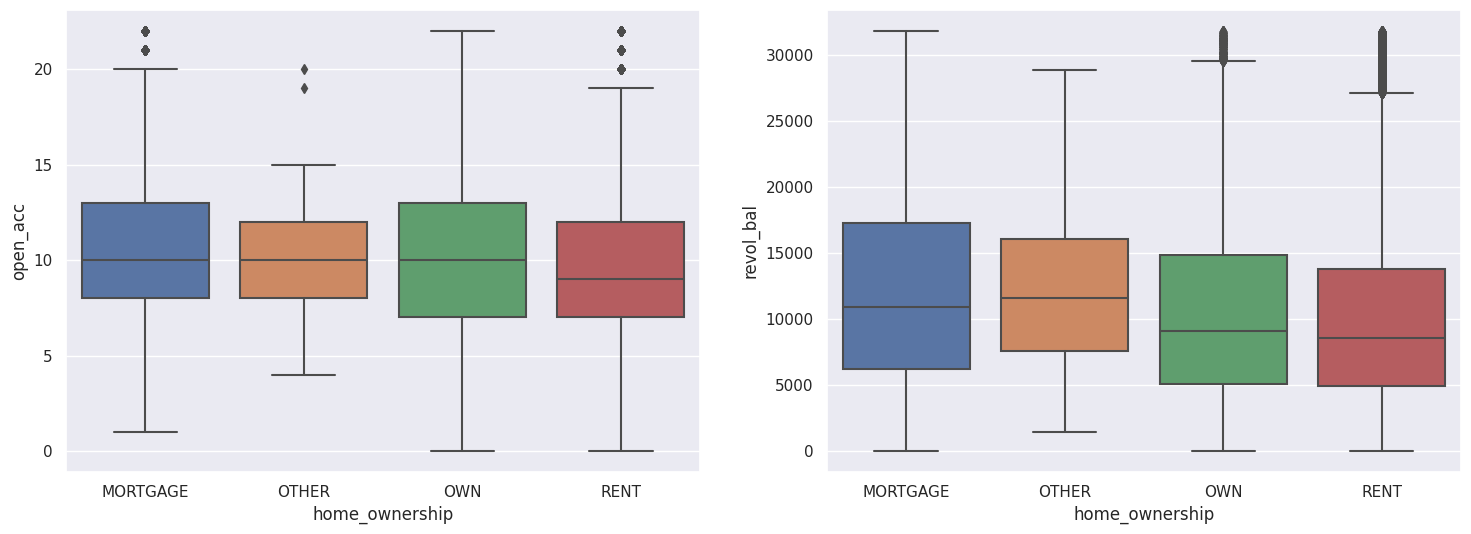

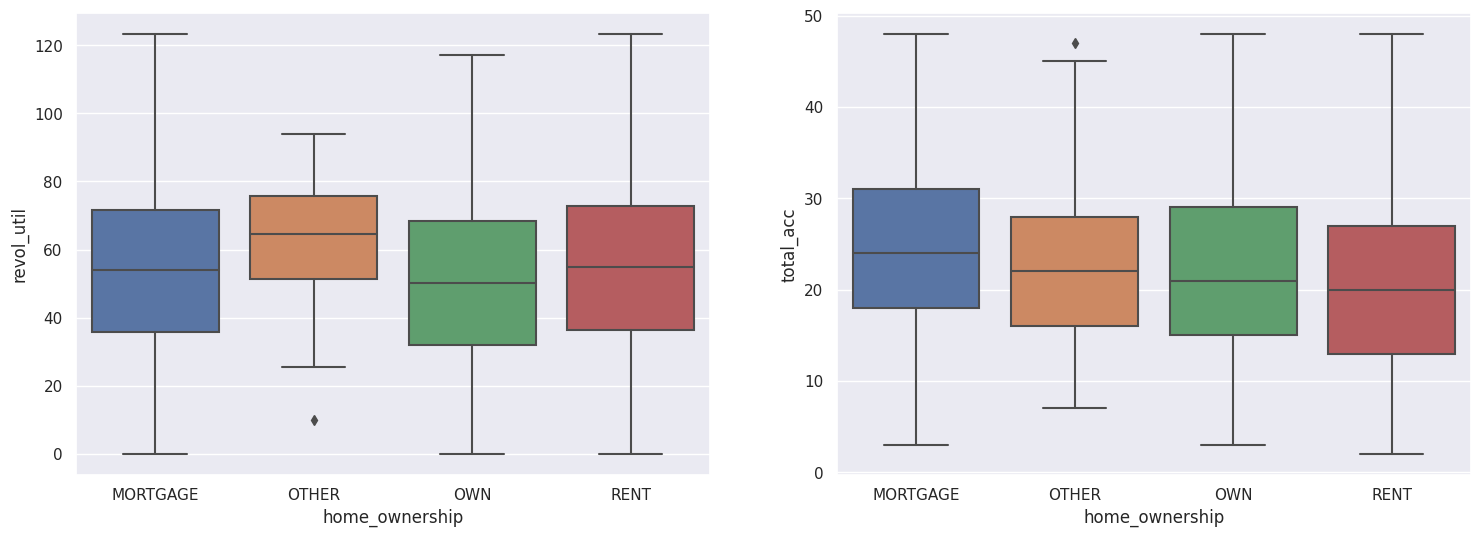

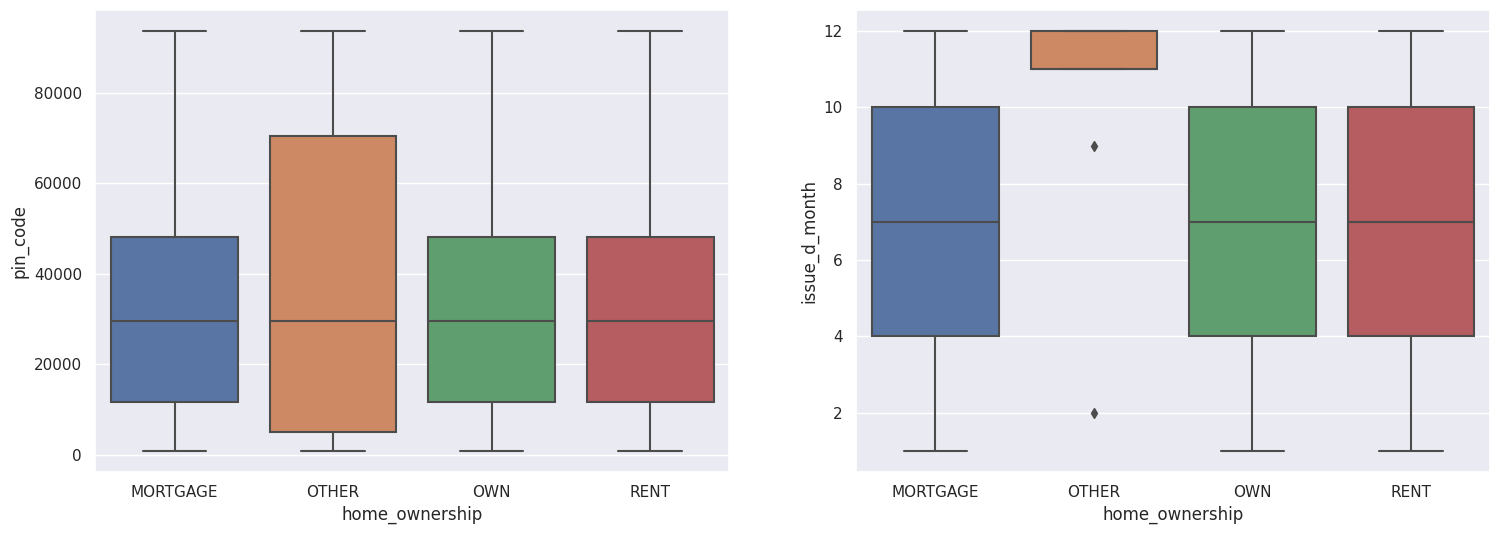

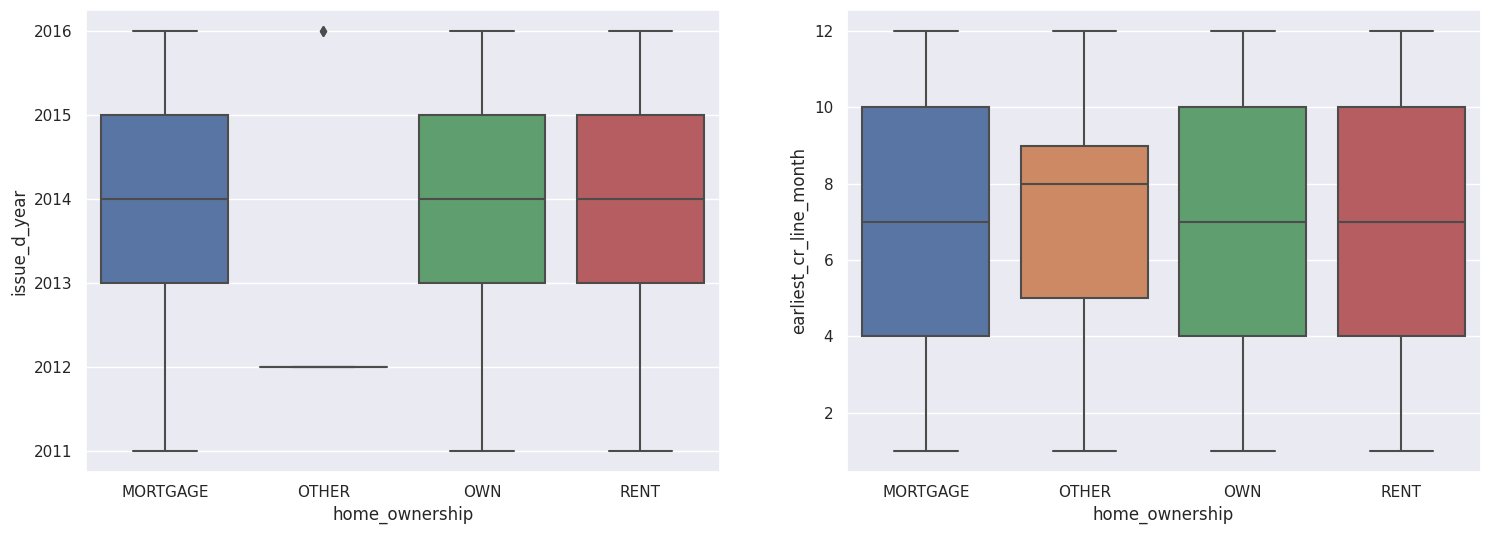

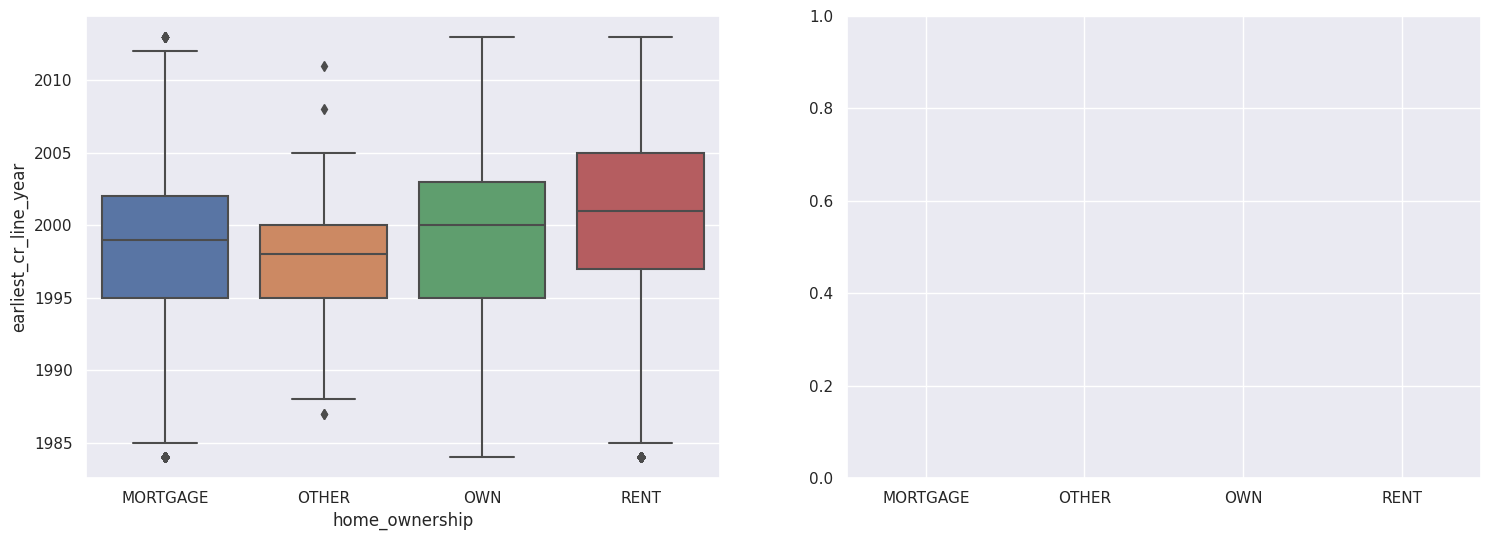

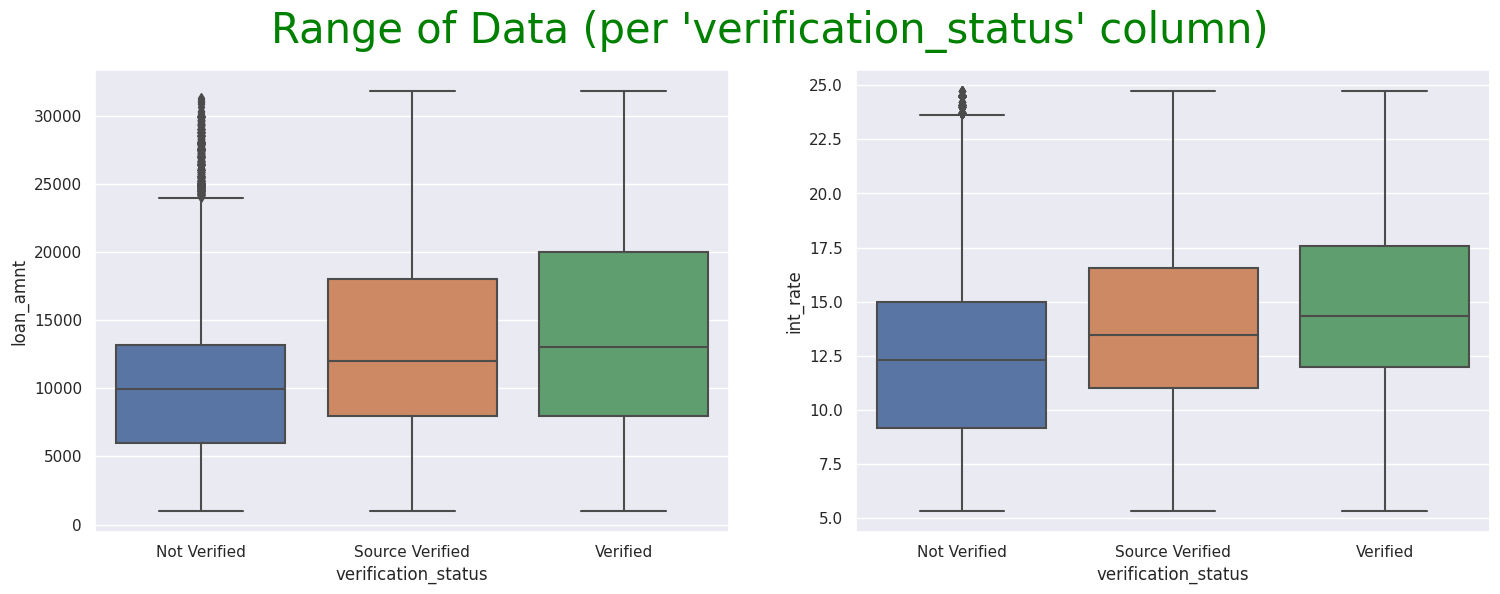

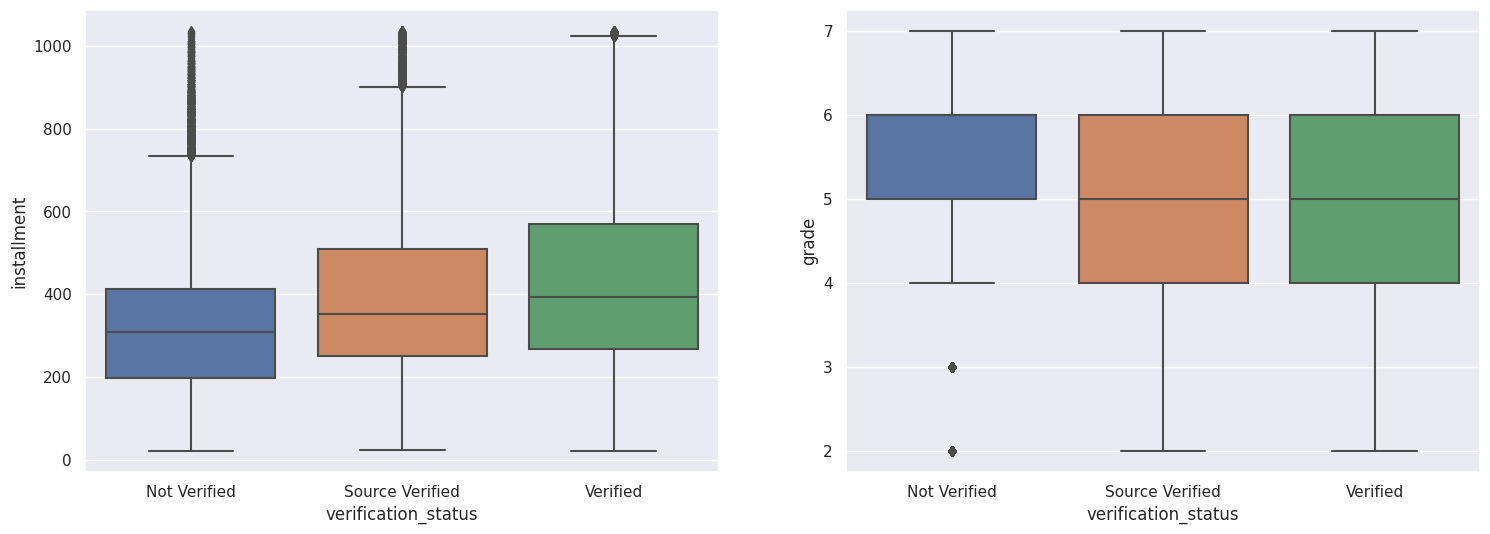

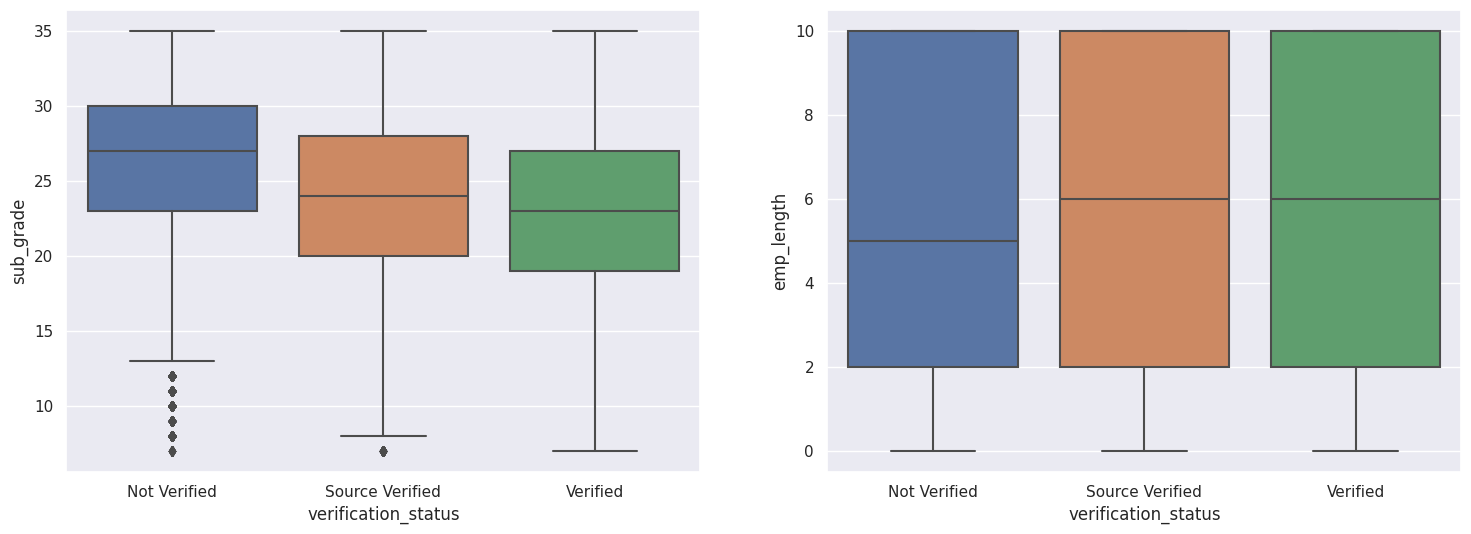

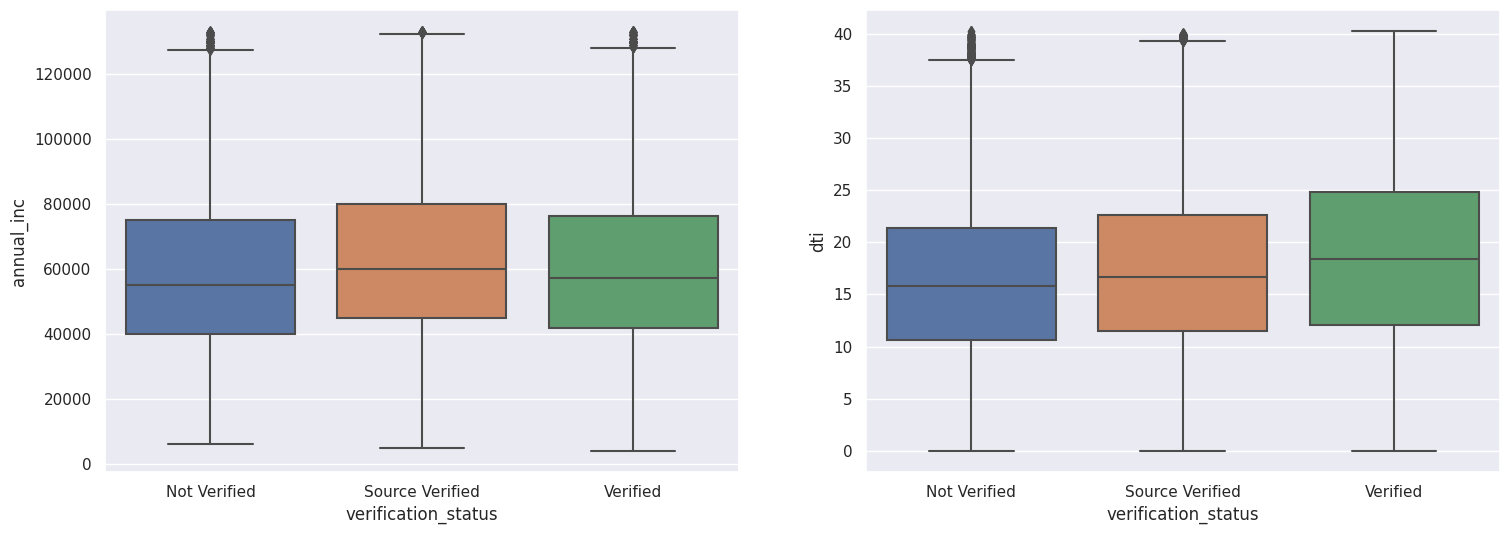

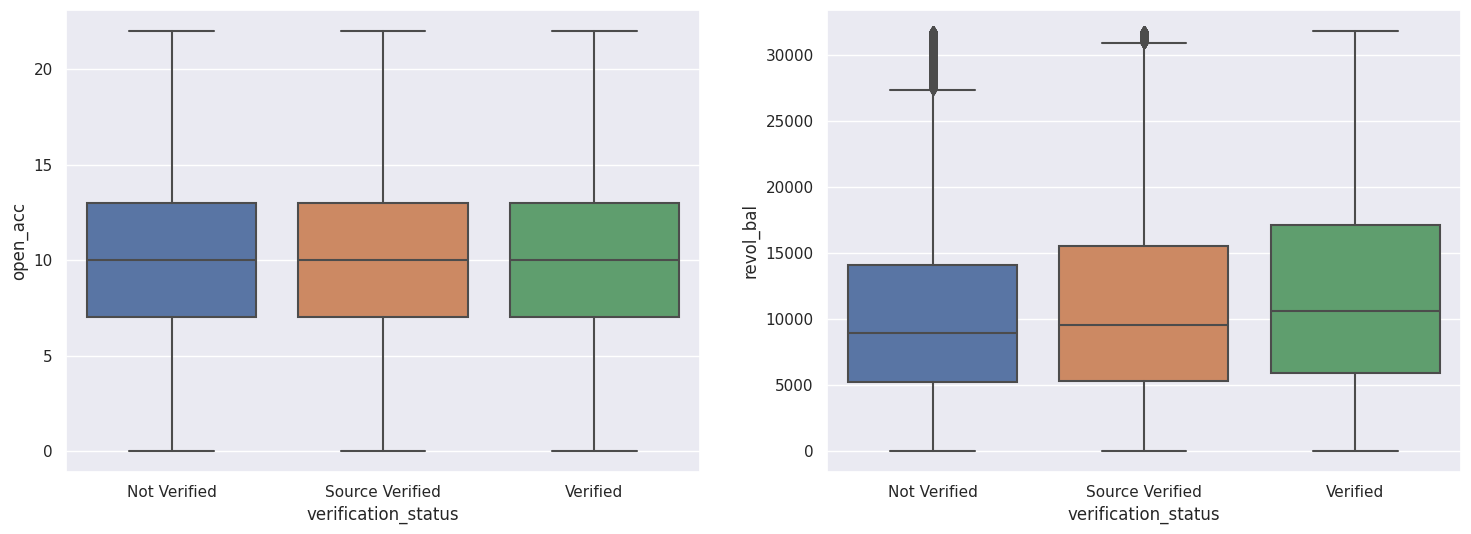

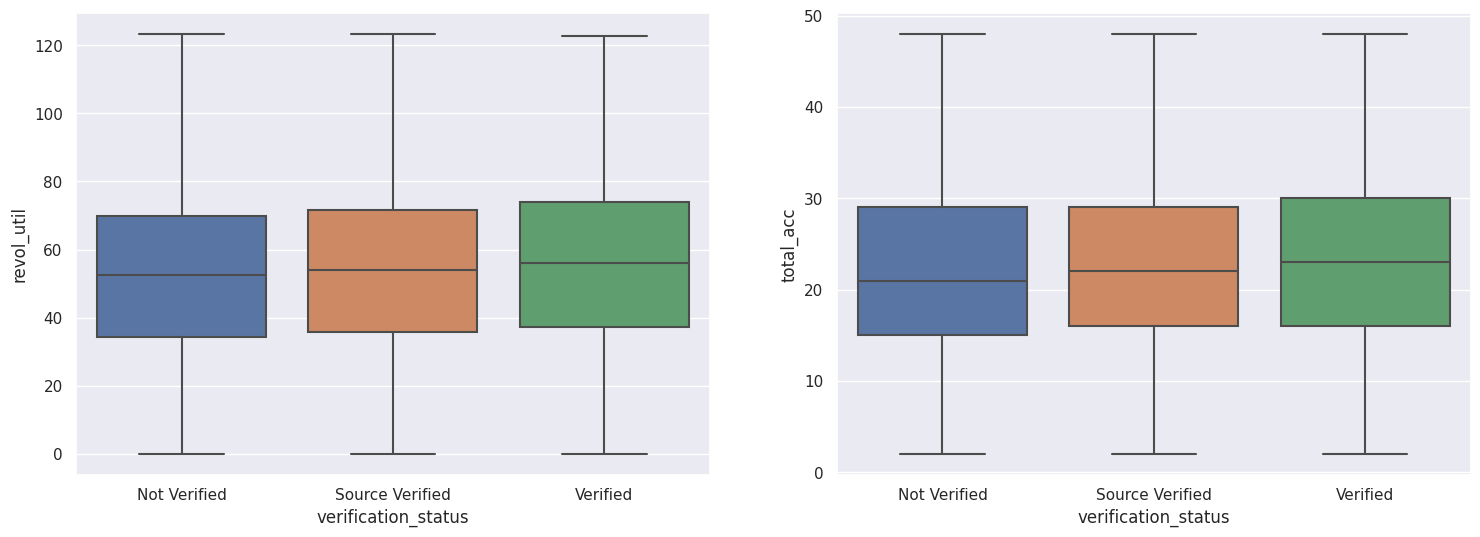

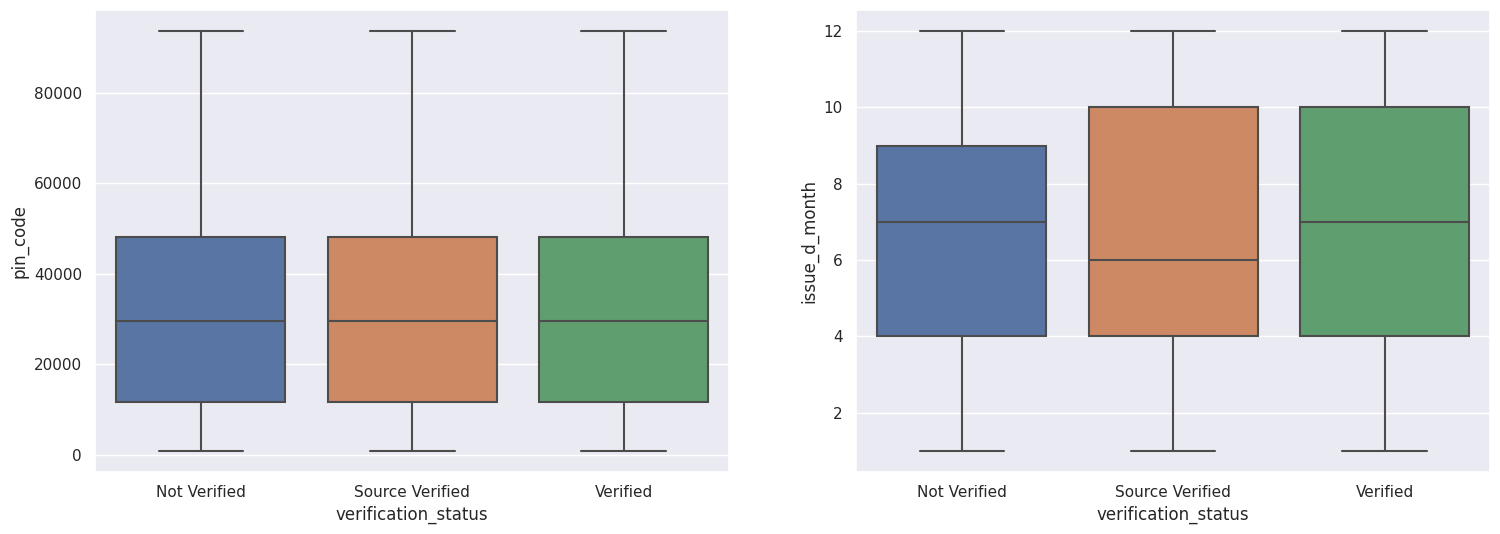

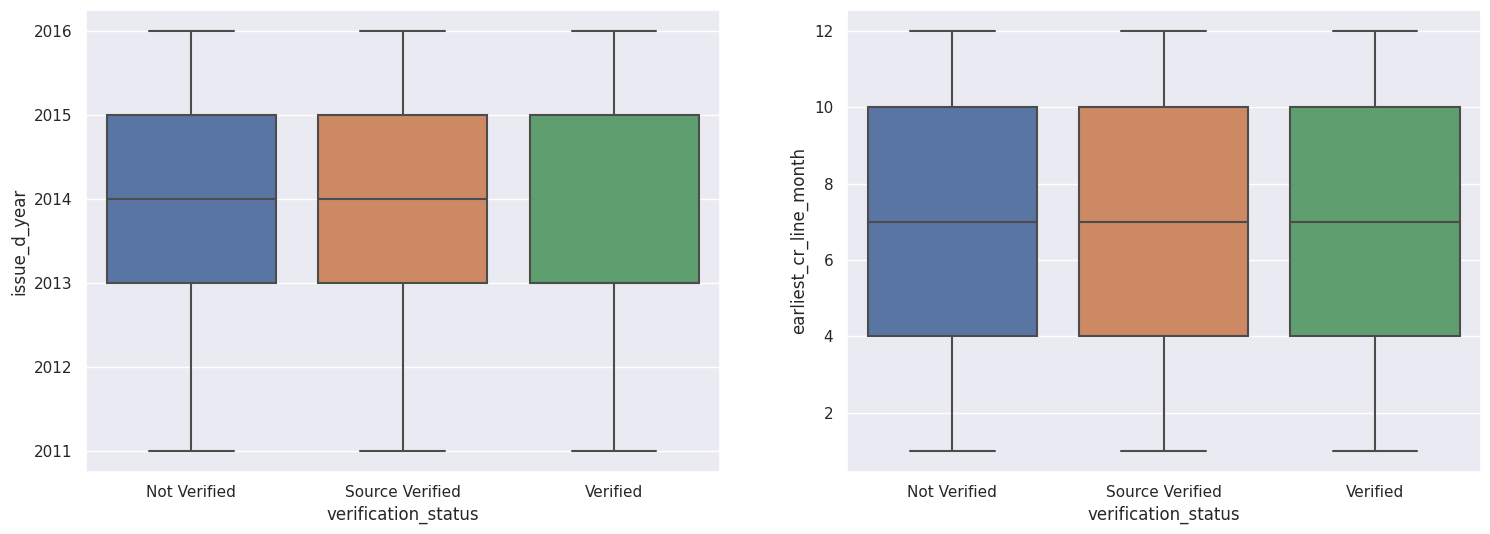

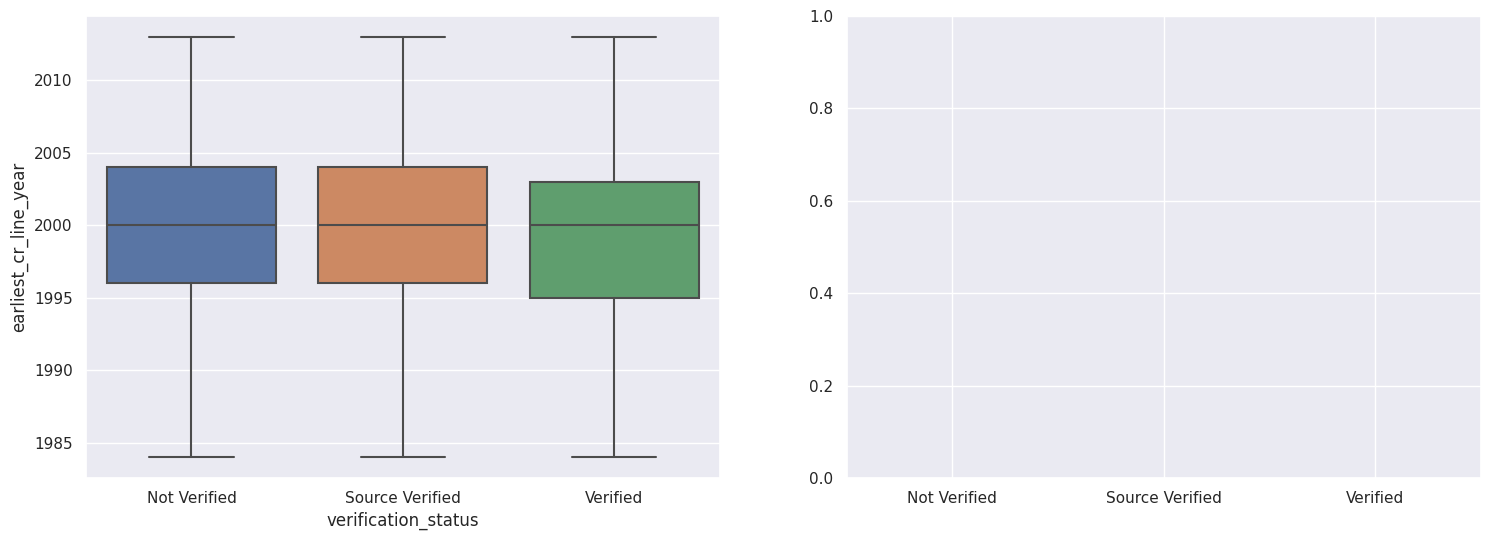

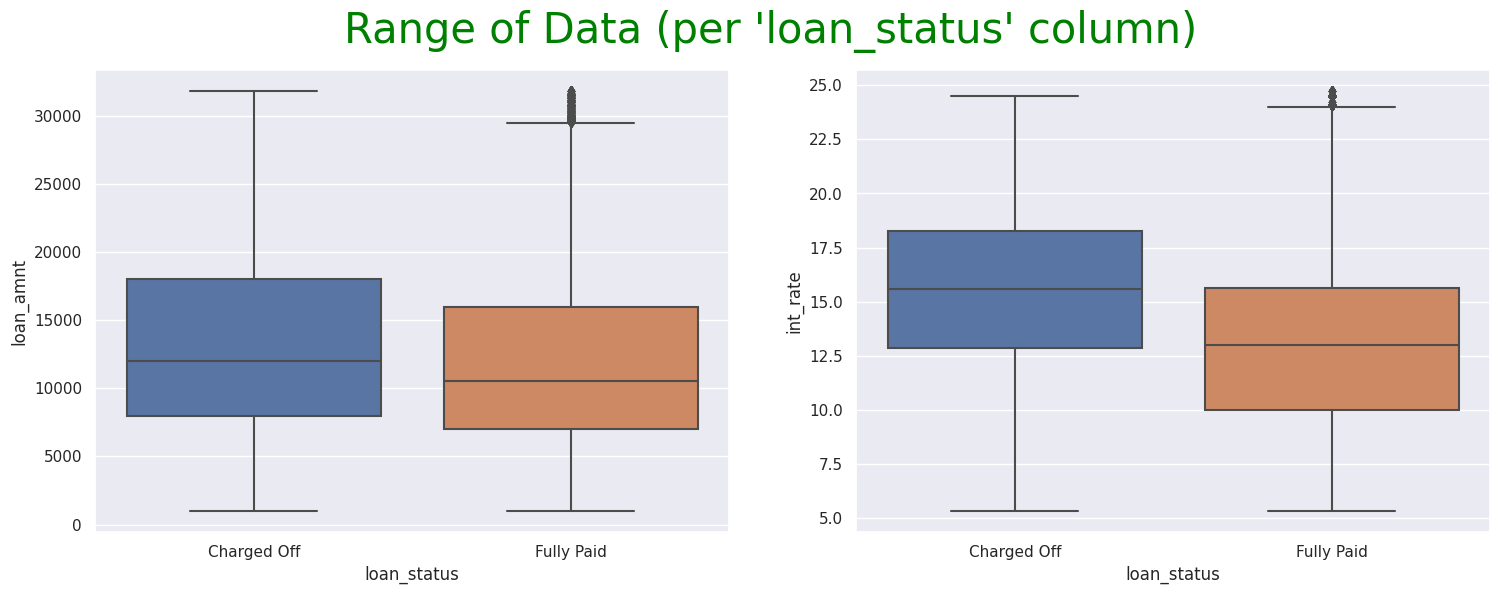

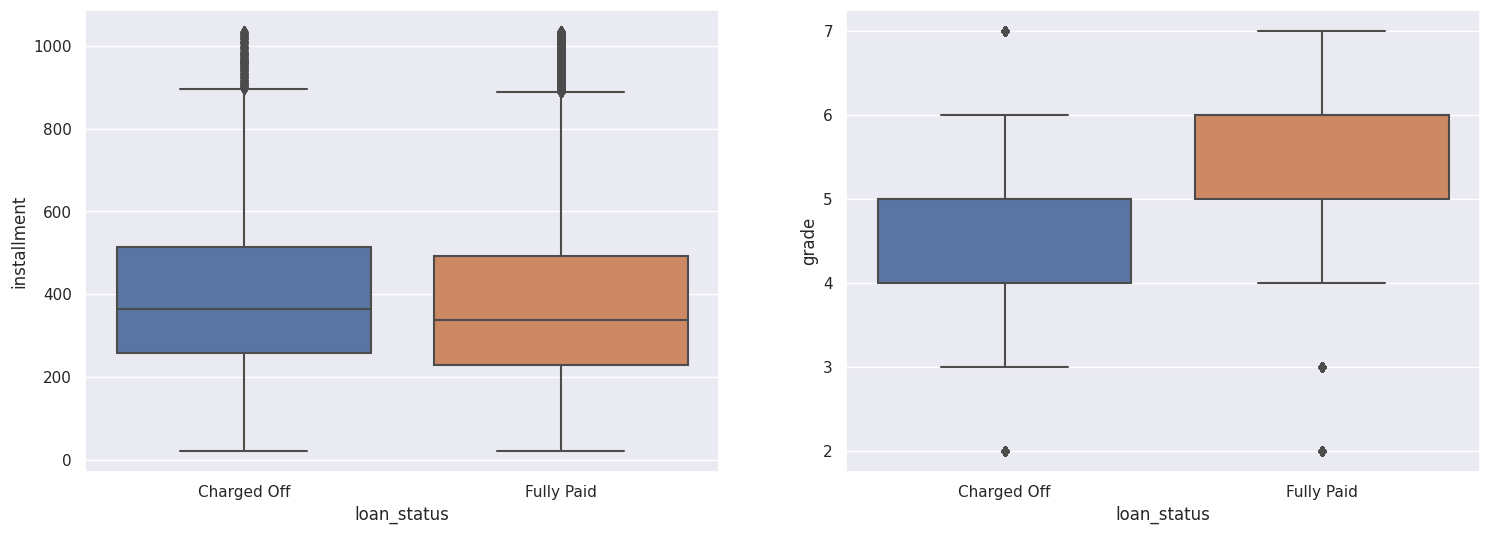

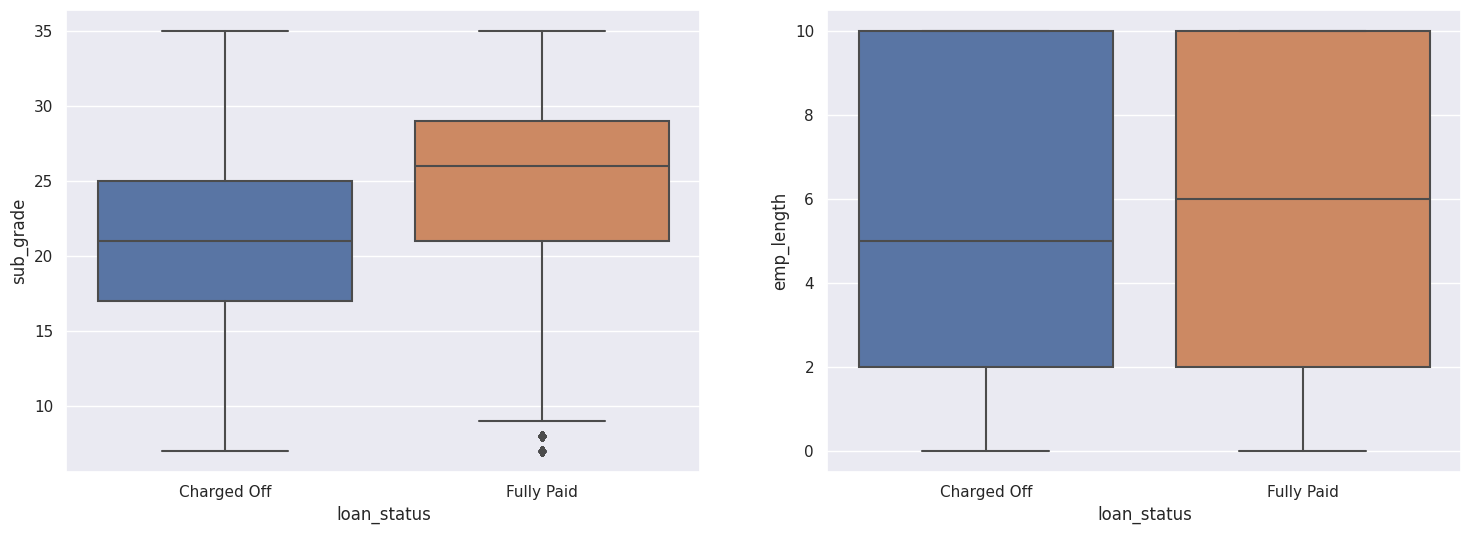

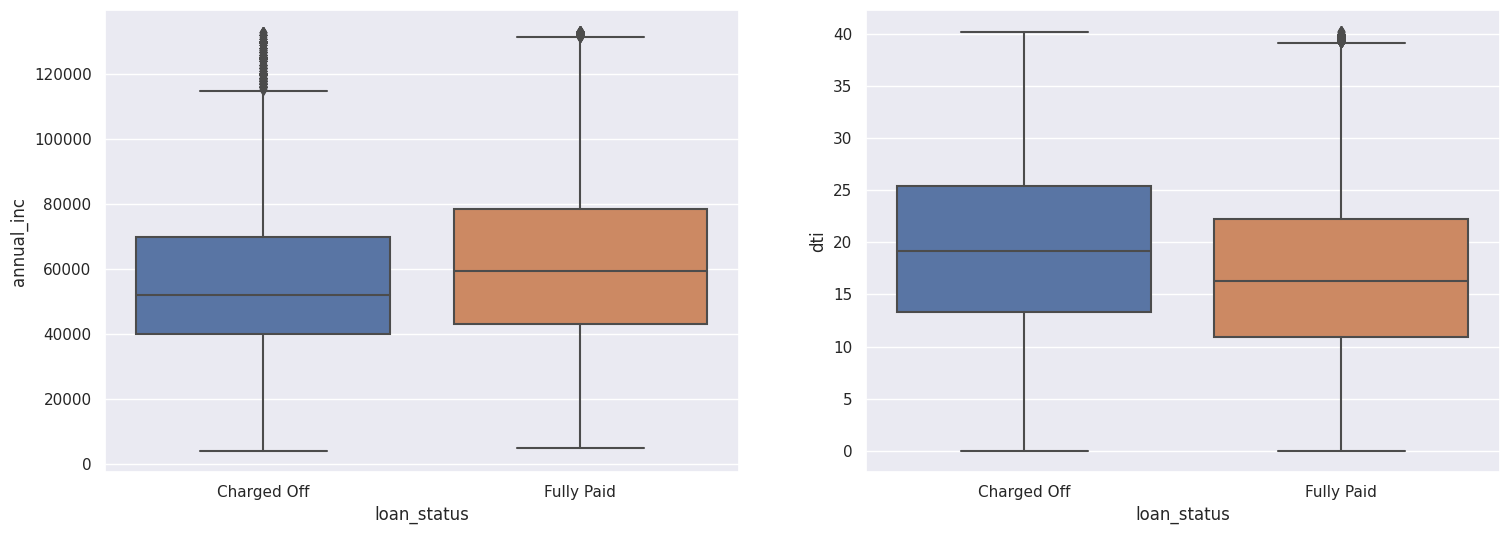

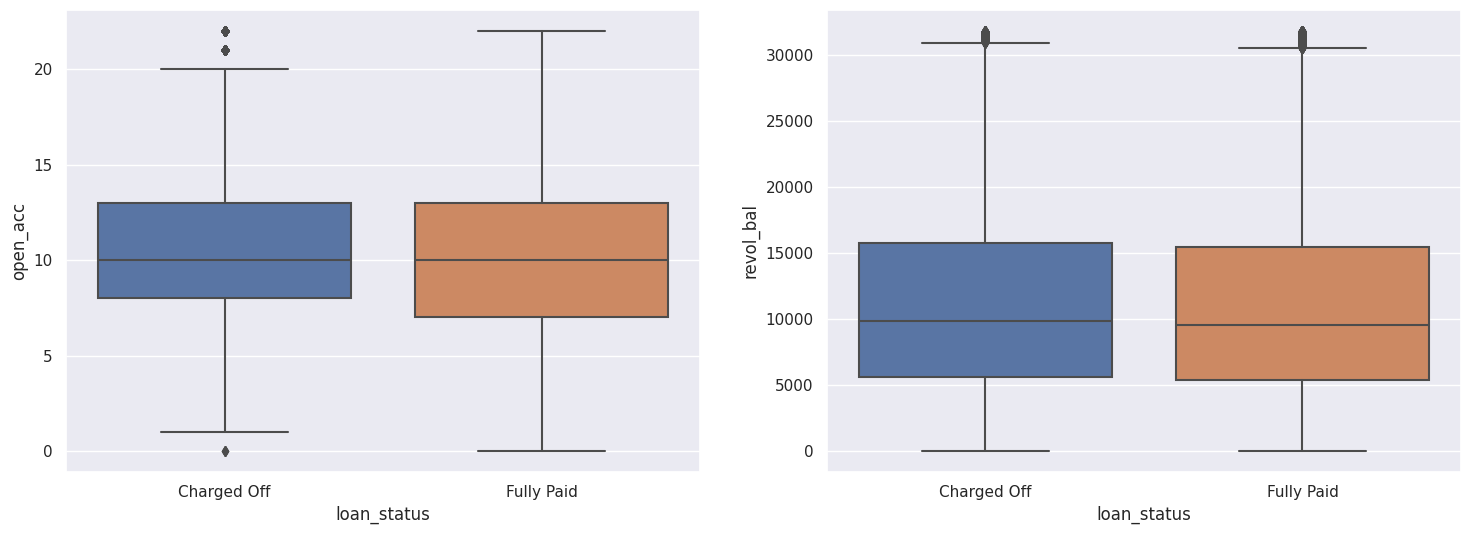

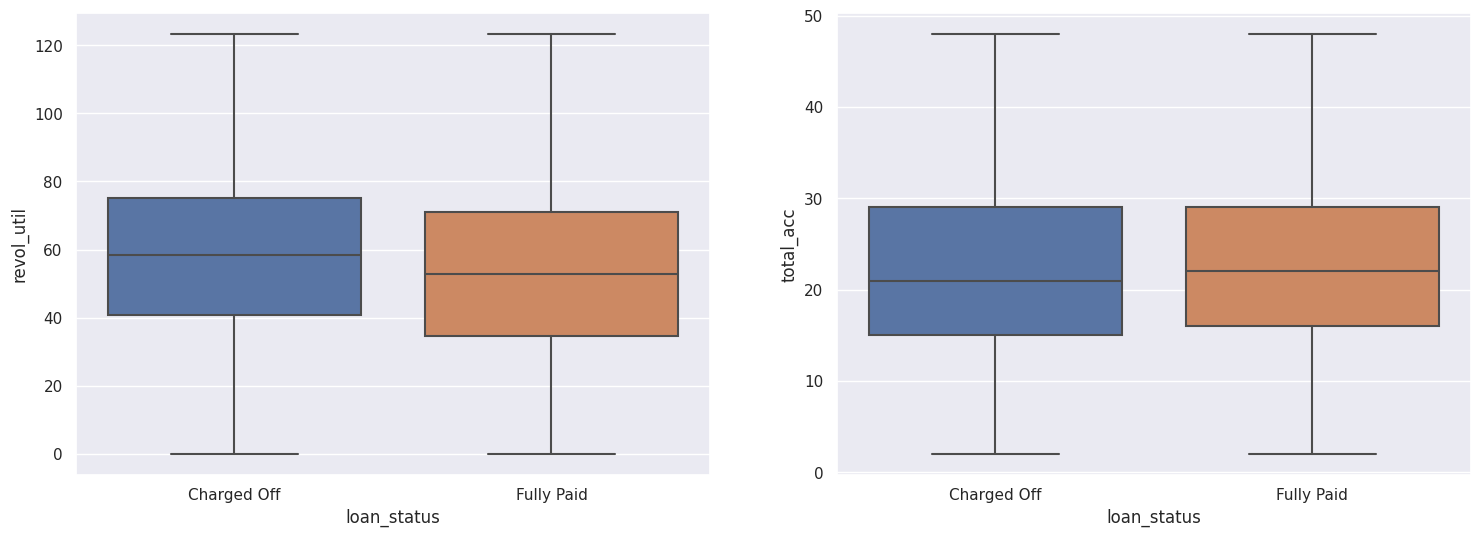

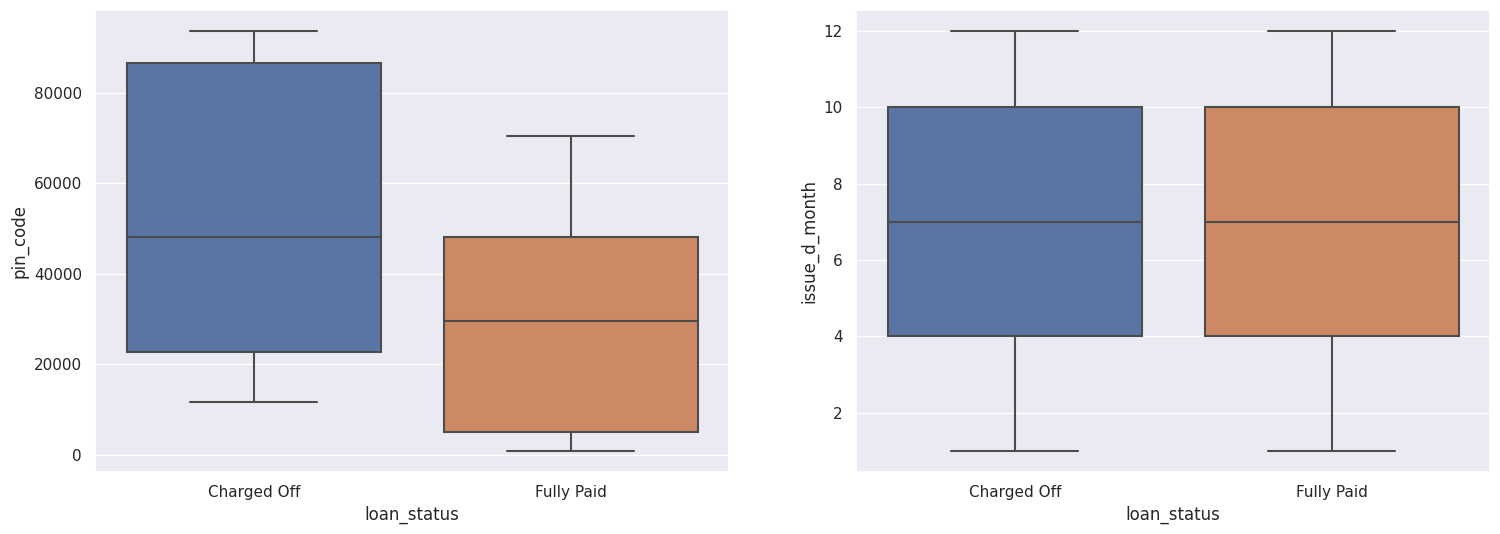

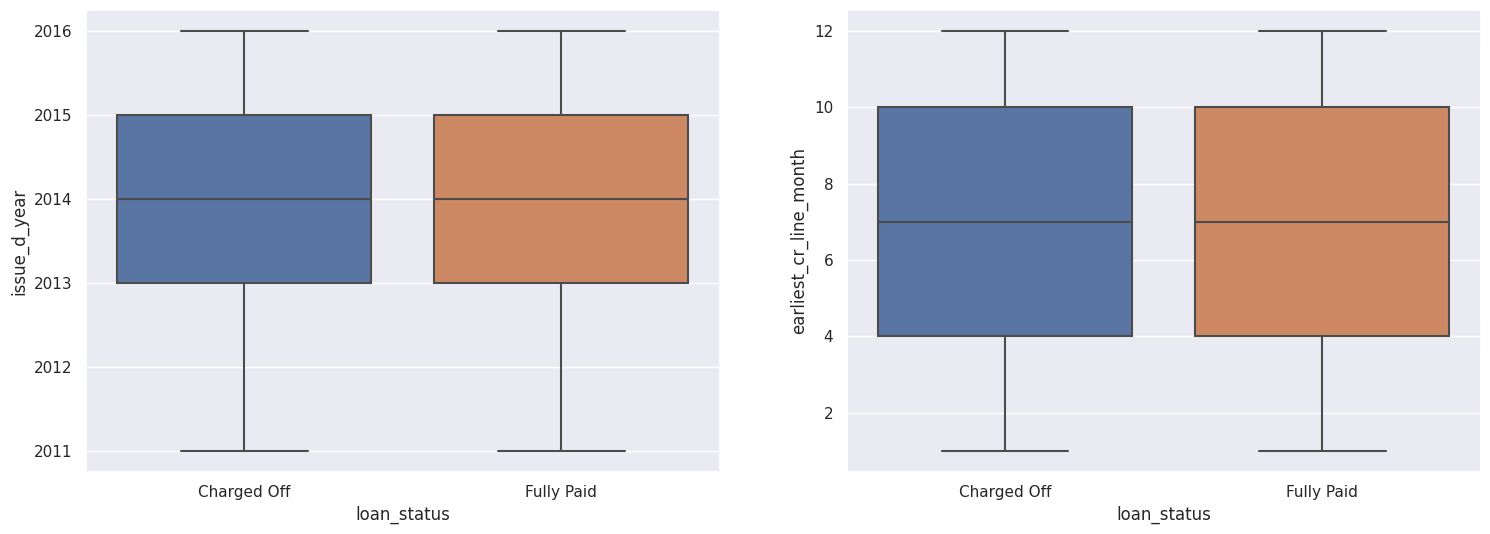

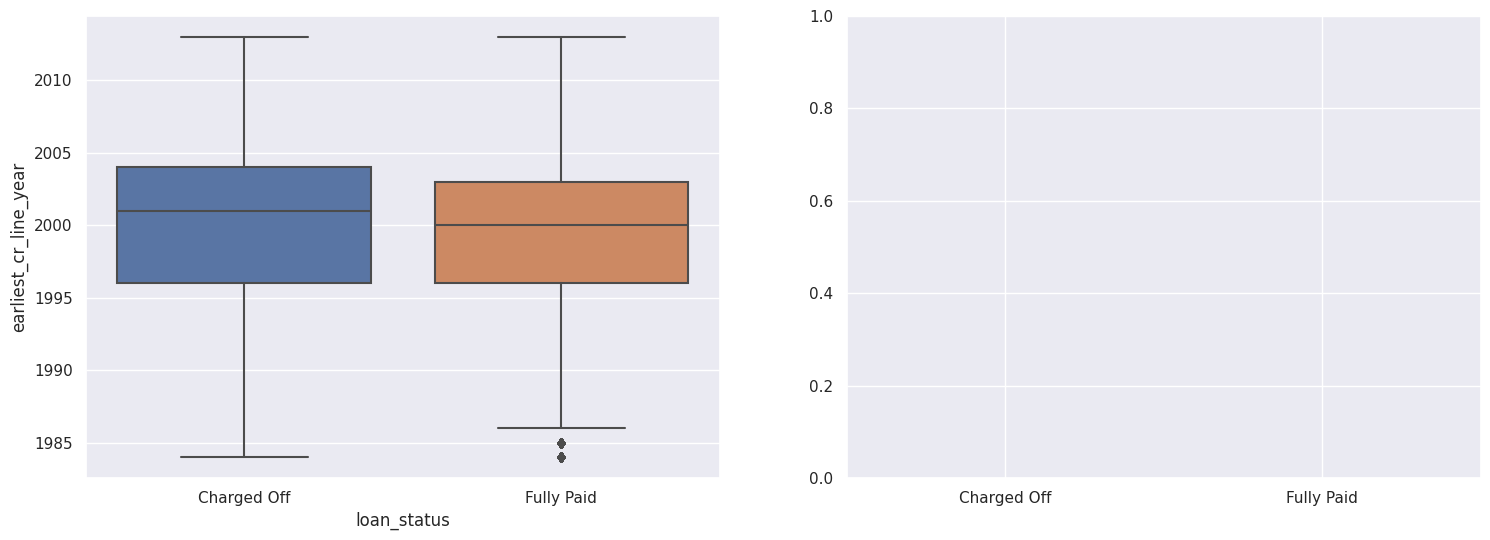

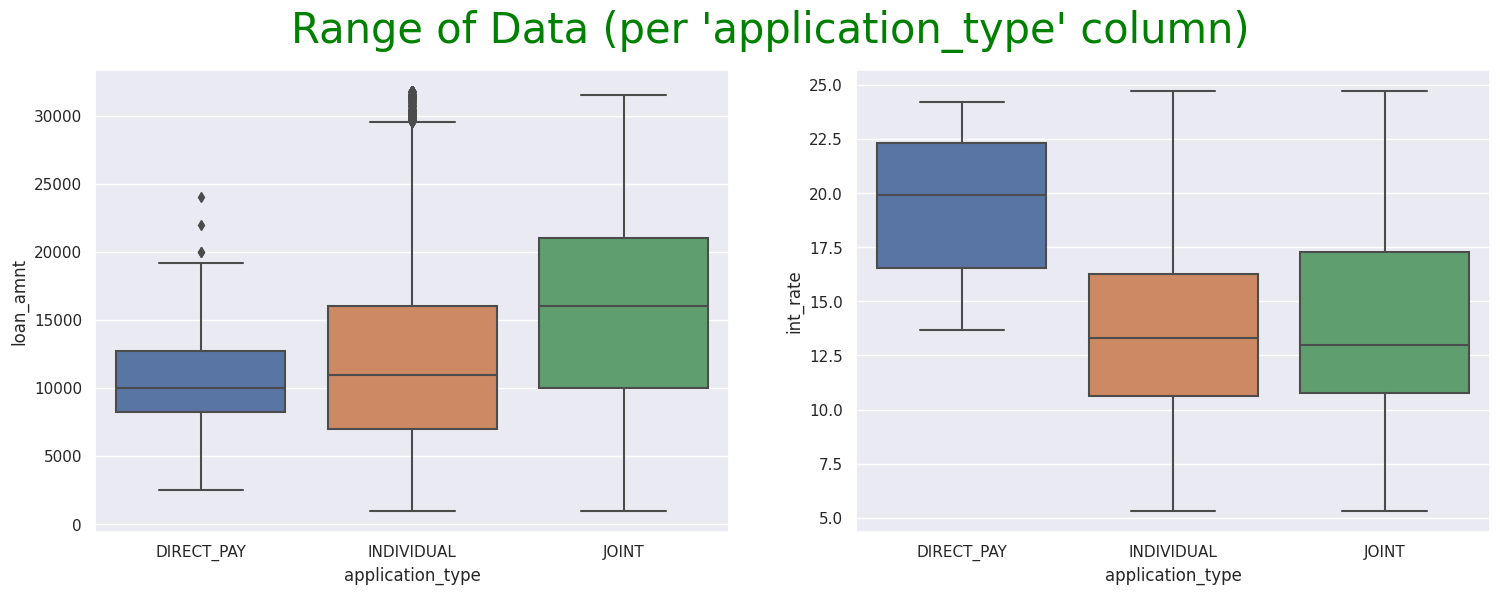

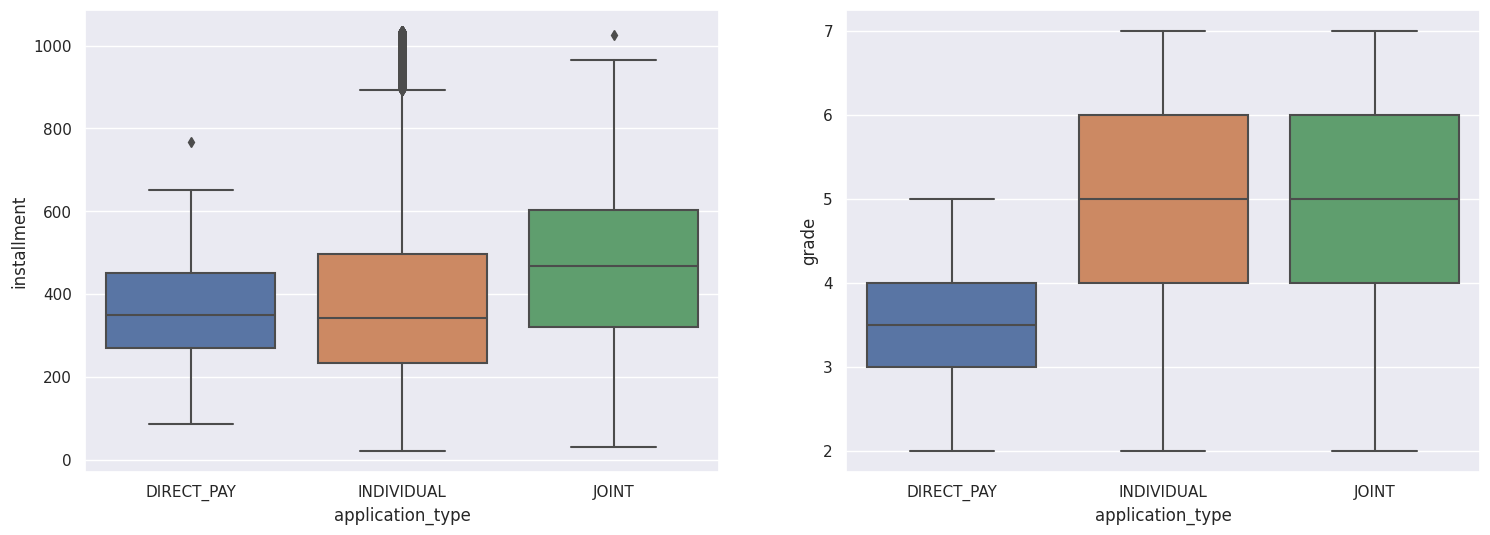

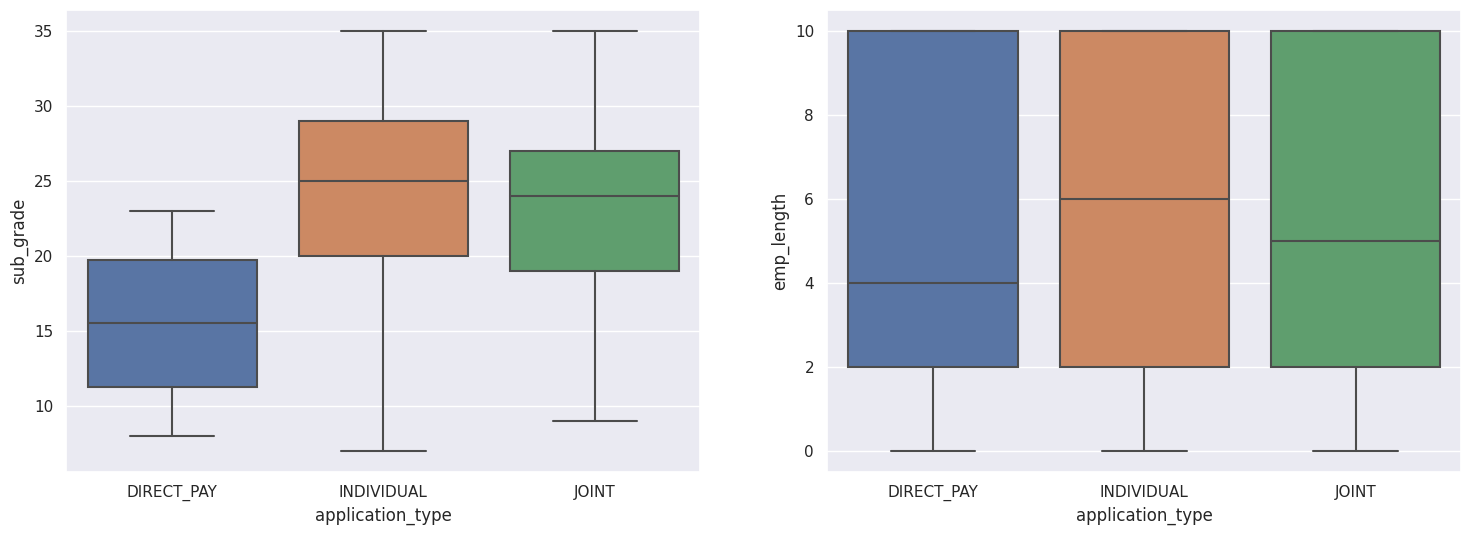

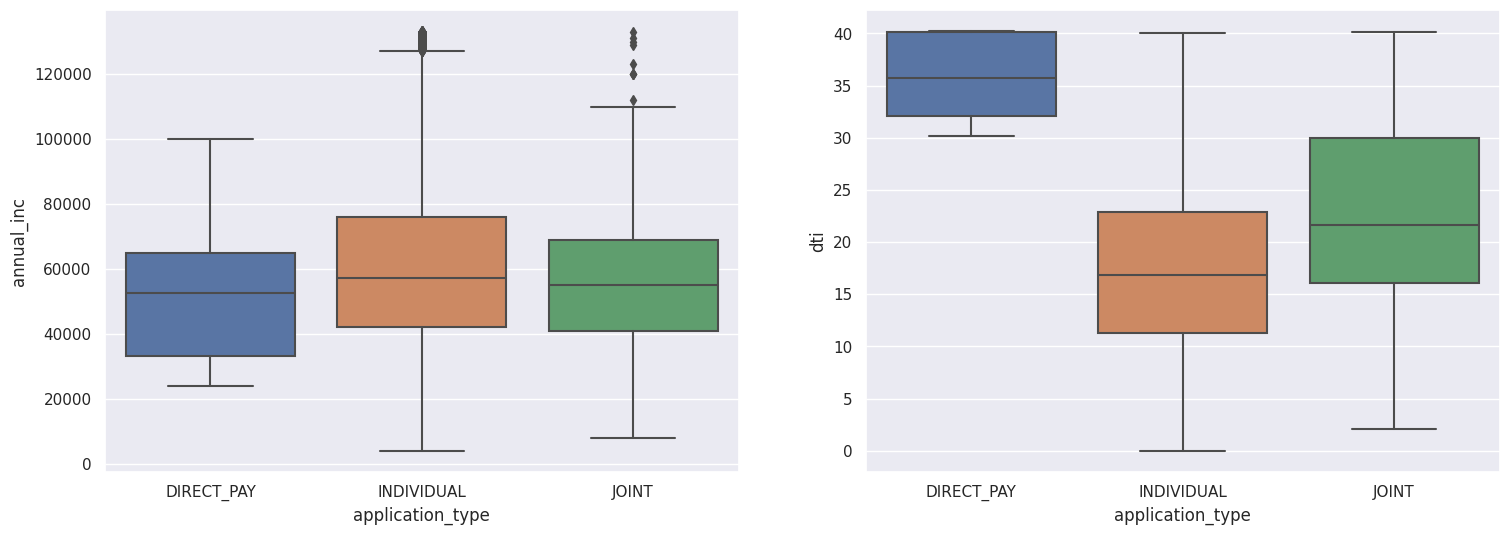

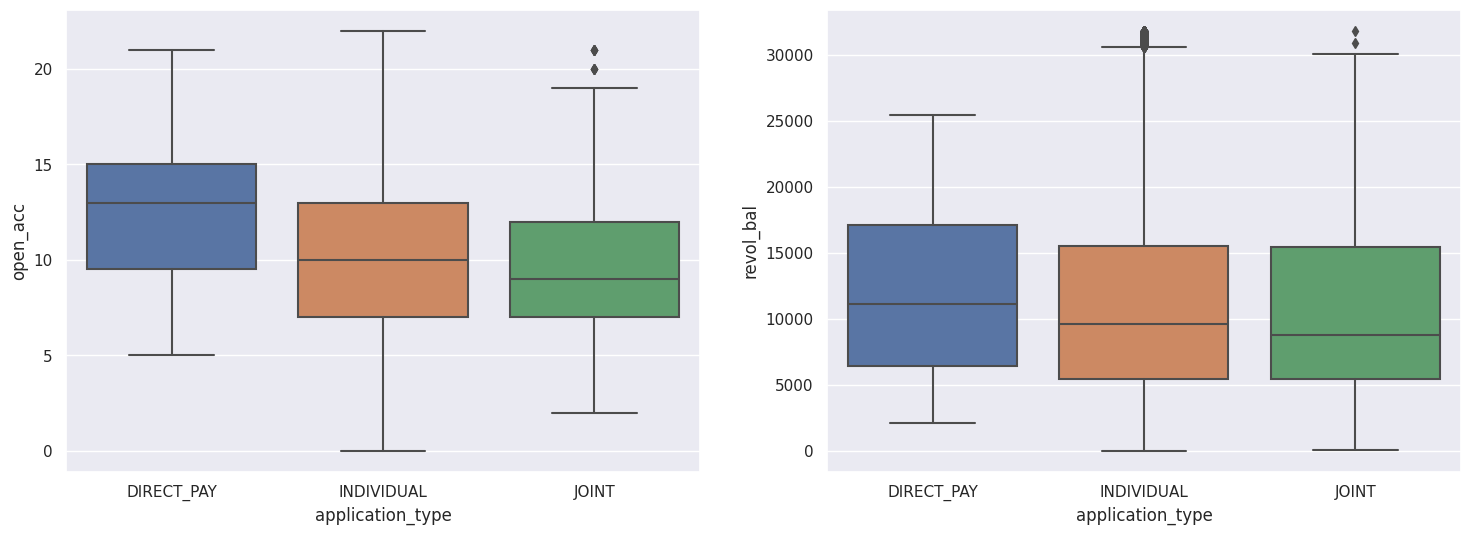

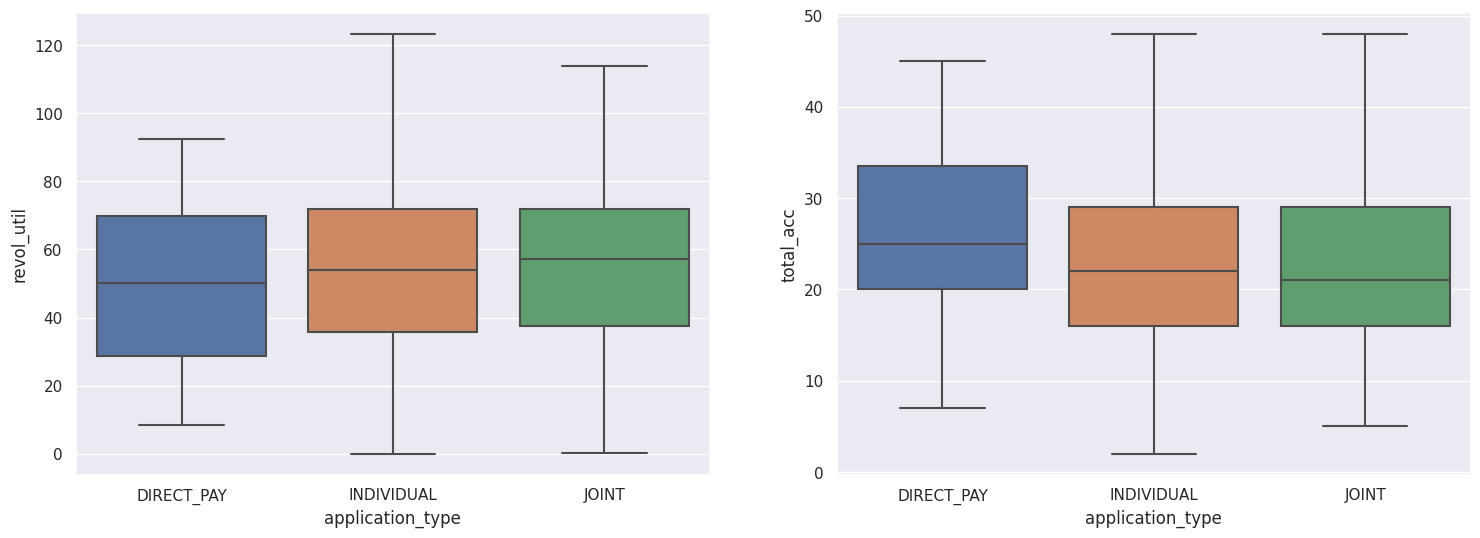

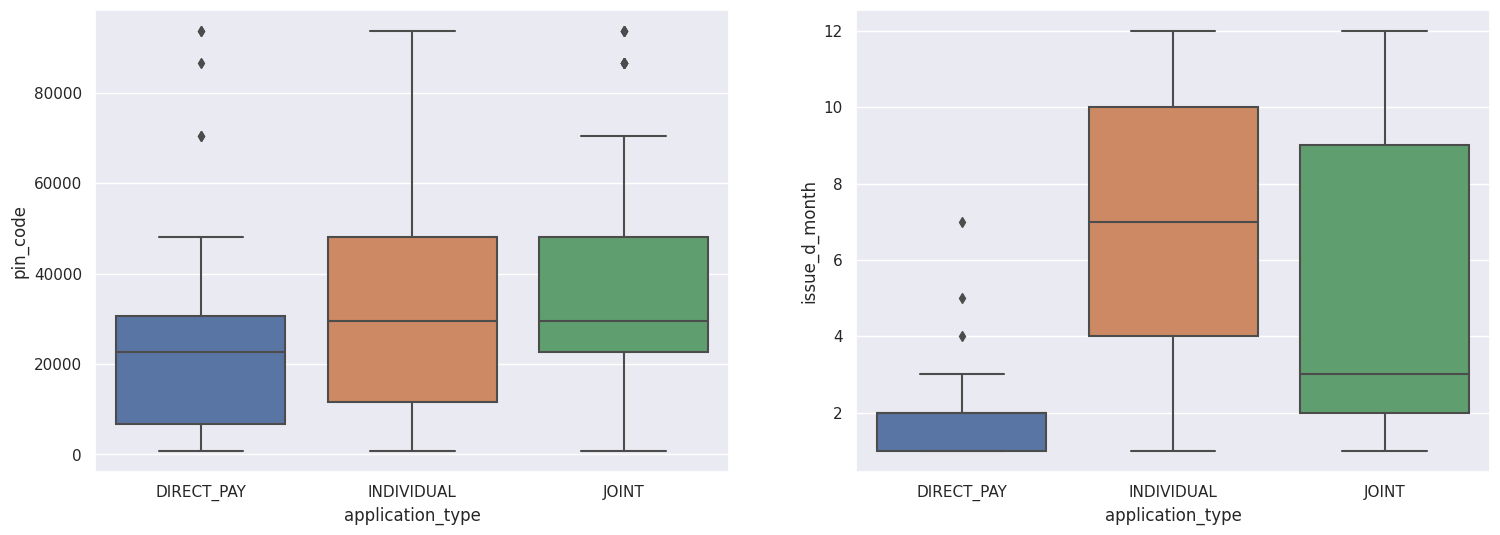

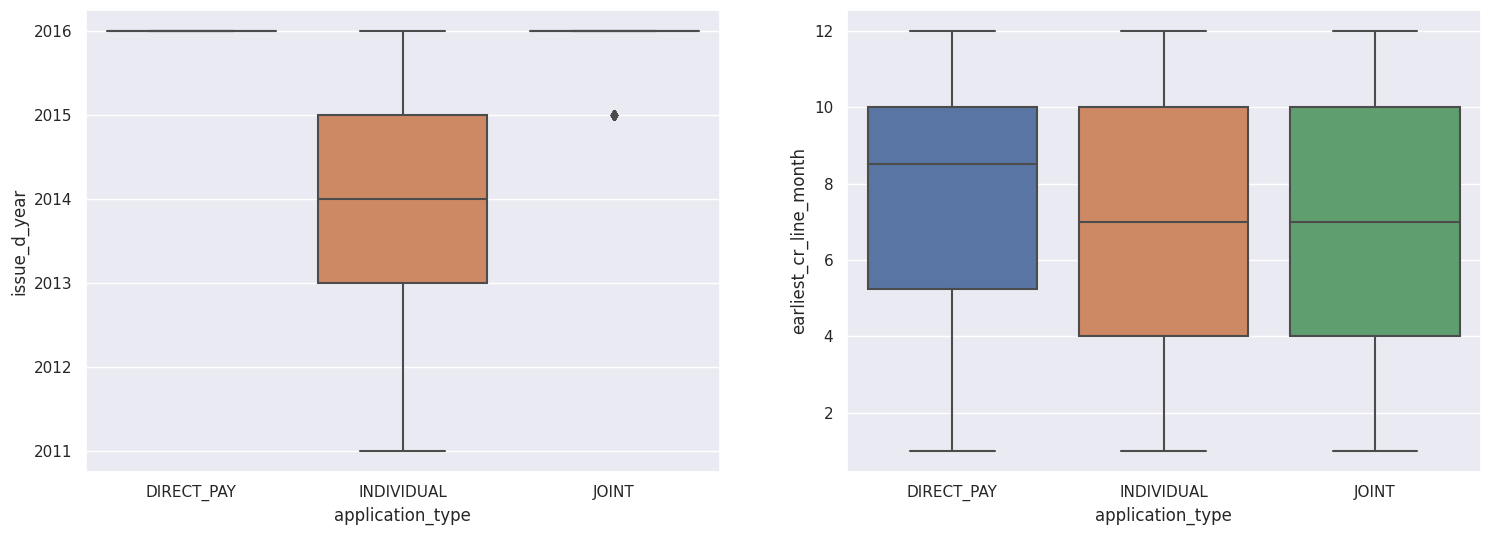

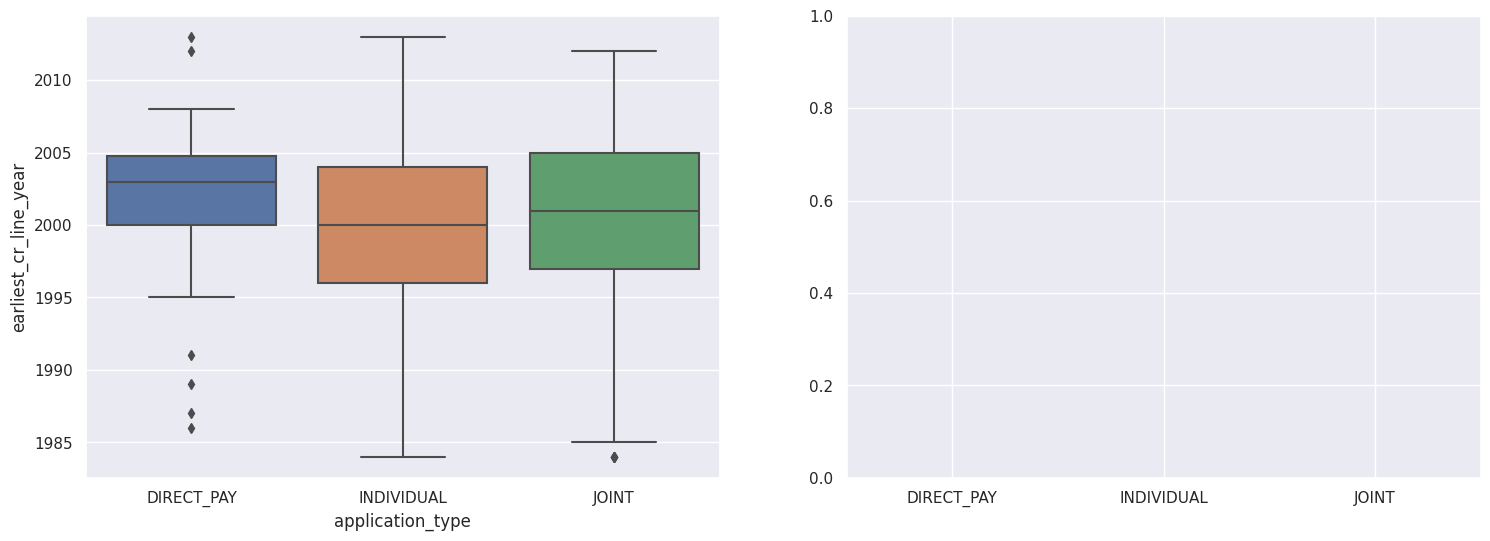

In [ ]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

### 7.5 Analysis of Correlation Between *Data*

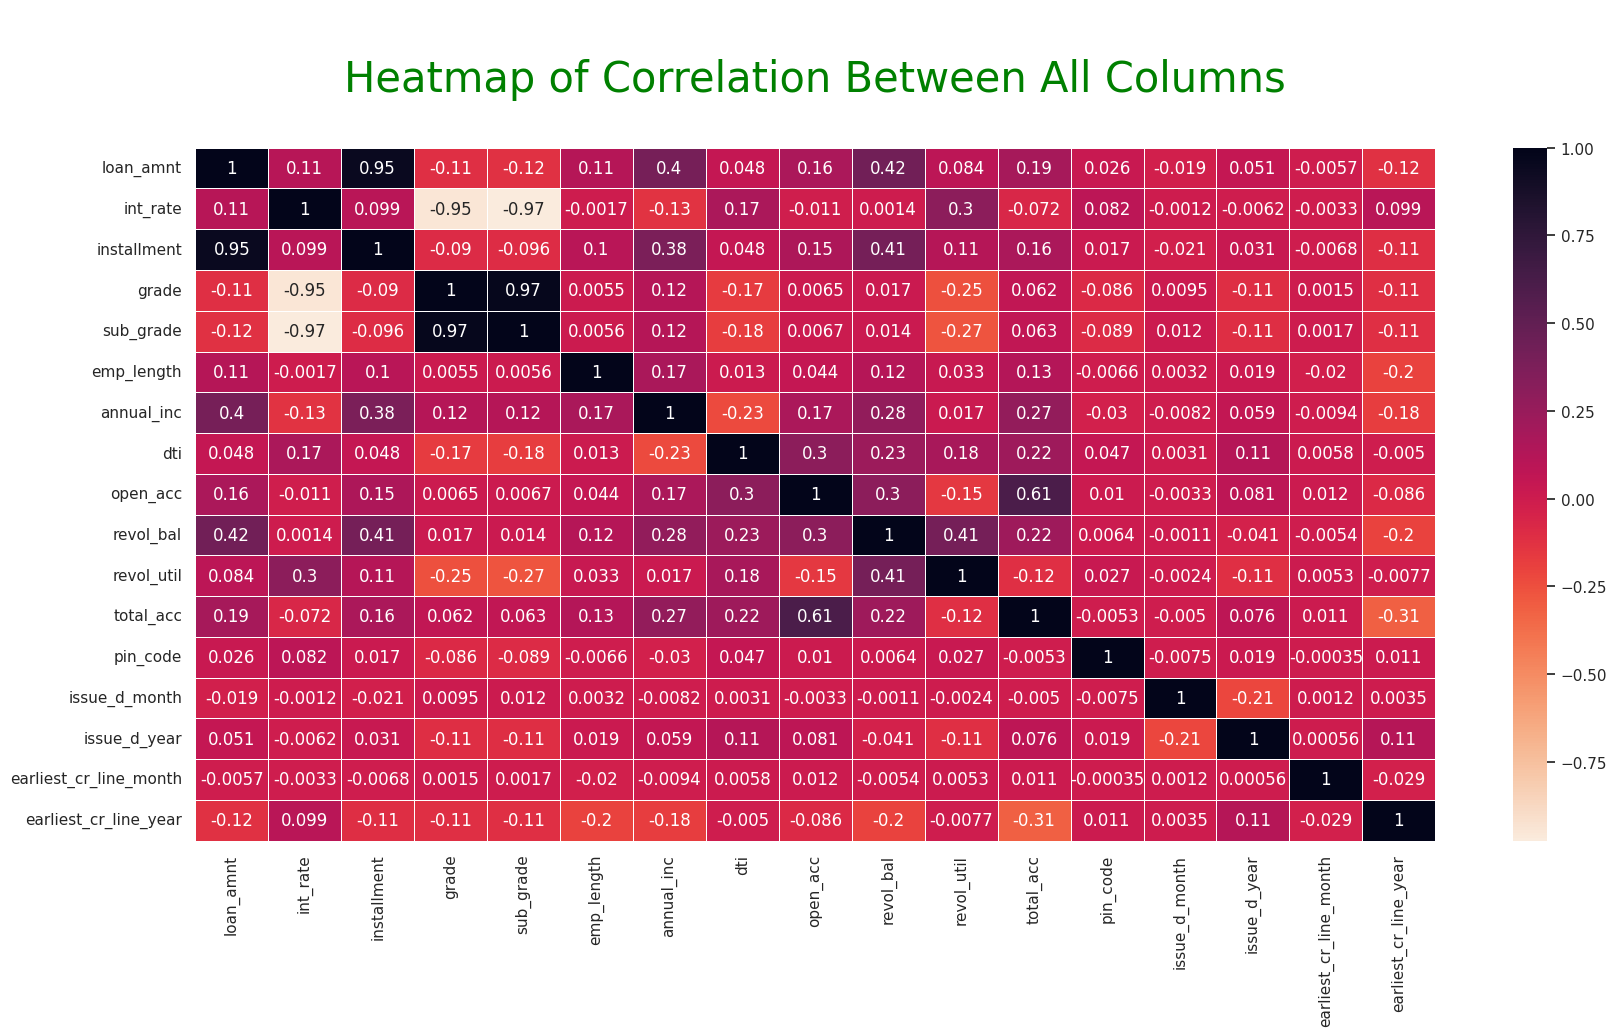

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

## 8 Hypothesis Testing to identify Significant Factors impacting the Loan status

In [ ]:
charged_off = df[df['loan_status']=='Charged Off']
fully_paid = df[df['loan_status']=='Fully Paid']

### 8.1 Comparison of Loan status for different Interest Rates

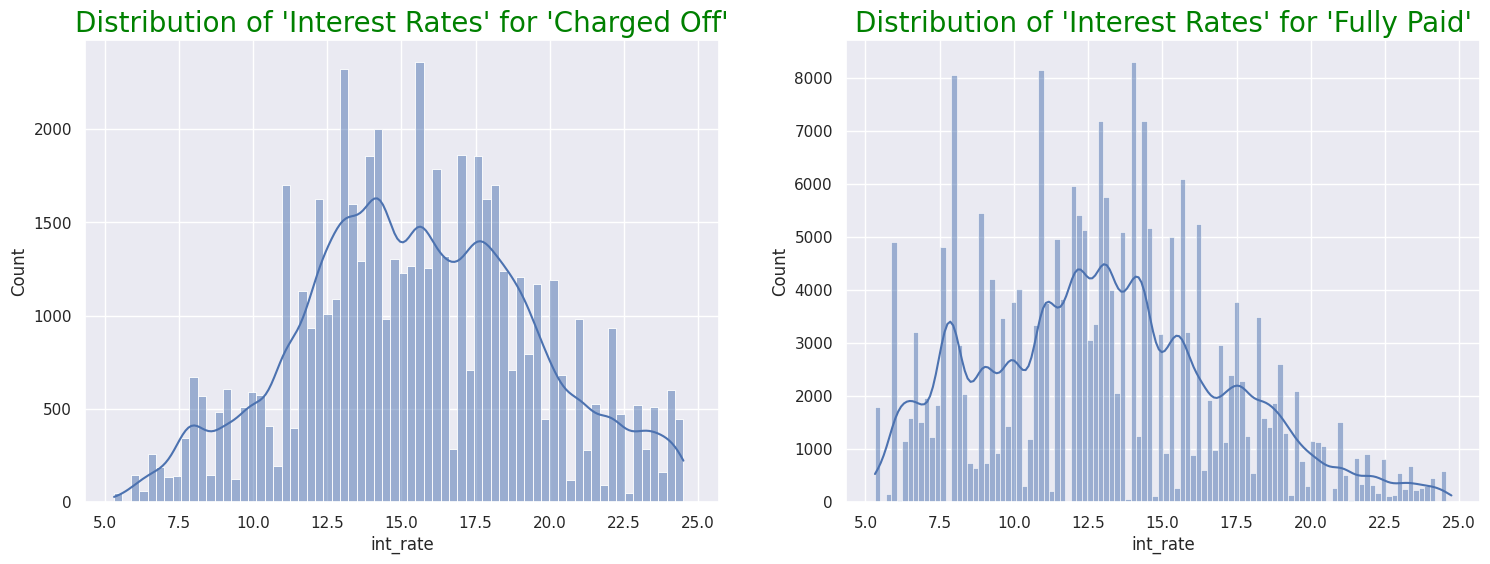

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(charged_off['int_rate'], kde=True, ax=axes[0]).set_title("Distribution of 'Interest Rates' for 'Charged Off'", fontsize=20, color="green")
sns.histplot(fully_paid['int_rate'], kde=True, ax=axes[1]).set_title("Distribution of 'Interest Rates' for 'Fully Paid'", fontsize=20, color="green")
plt.show()

**Even though, the distributions do not visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.**

In [ ]:
np.std(charged_off['int_rate'])**2, np.std(fully_paid['int_rate'])**2

(15.686142961946297, 16.635233957630035)

**Variances are roughly equal so proceeding further with 2 Sample T test.**

--------------------------------------------------------------------------------------------
#### 8.1.1 Applying Unpaired T-Test
--------------------------------------------------------------------------------------------

**H0** = The mean difference of 'Interest Rates' between unpaired observations for 'Charged Off and Paid Off' loans is zero.

**H1** = The mean of 'Interest Rates' for unpaired observations of 'Charged Off' loans is grater than 'Paid Off' loans.

**Significance Level (α)** = 0.05

In [ ]:
stats.ttest_ind(charged_off['int_rate'].sample(100), fully_paid['int_rate'].sample(100), equal_var=False,  alternative='greater')


TtestResult(statistic=5.260325020307014, pvalue=1.8584625774514027e-07, df=197.99712498859955)

> **`Rejected Null hypothesis. This means that Interest Rate has significant impact on Loan Status.`**

### 8.2 Comparison of Loan status for different Grades.

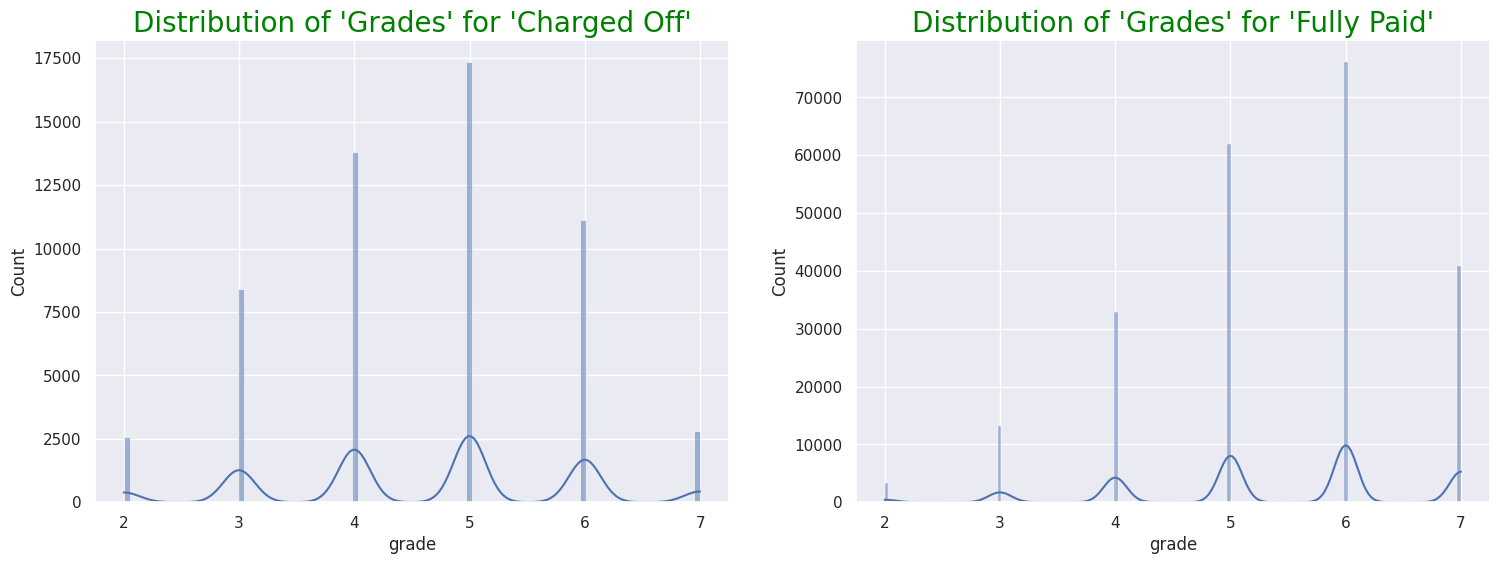

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(charged_off['grade'], kde=True, ax=axes[0]).set_title("Distribution of 'Grades' for 'Charged Off'", fontsize=20, color="green")
sns.histplot(fully_paid['grade'], kde=True, ax=axes[1]).set_title("Distribution of 'Grades' for 'Fully Paid'", fontsize=20, color="green")
plt.show()

**Even though, the distributions do not visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.**

In [ ]:
np.std(charged_off['grade'])**2, np.std(fully_paid['grade'])**2

(1.5104525941682607, 1.4053673667340056)

**Variances are roughly equal so proceeding further with 2 Sample T test**

----------------------------------------------------------------------------------------------
#### 8.2.1 Applying Unpaired T-Test
----------------------------------------------------------------------------------------------

**H0** = The mean difference of 'Grades' between unpaired observations for 'Charged Off and Paid Off' loans is zero.

**H1** = The mean of 'Grades' for unpaired observations of 'Paid Off' loans is grater than 'Charged Off' loans.

**Significance Level (α)** = 0.05

In [ ]:
stats.ttest_ind(fully_paid['grade'].sample(100), charged_off['grade'].sample(100), equal_var=False,  alternative='greater')


TtestResult(statistic=2.7760523505784707, pvalue=0.0030207193174060483, df=193.94453778816347)

> **`Rejected Null hypothesis. This means that Grade has significant impact on Loan Status.`**

### 8.3 Comparison of Loan status for different Sub-Grades.

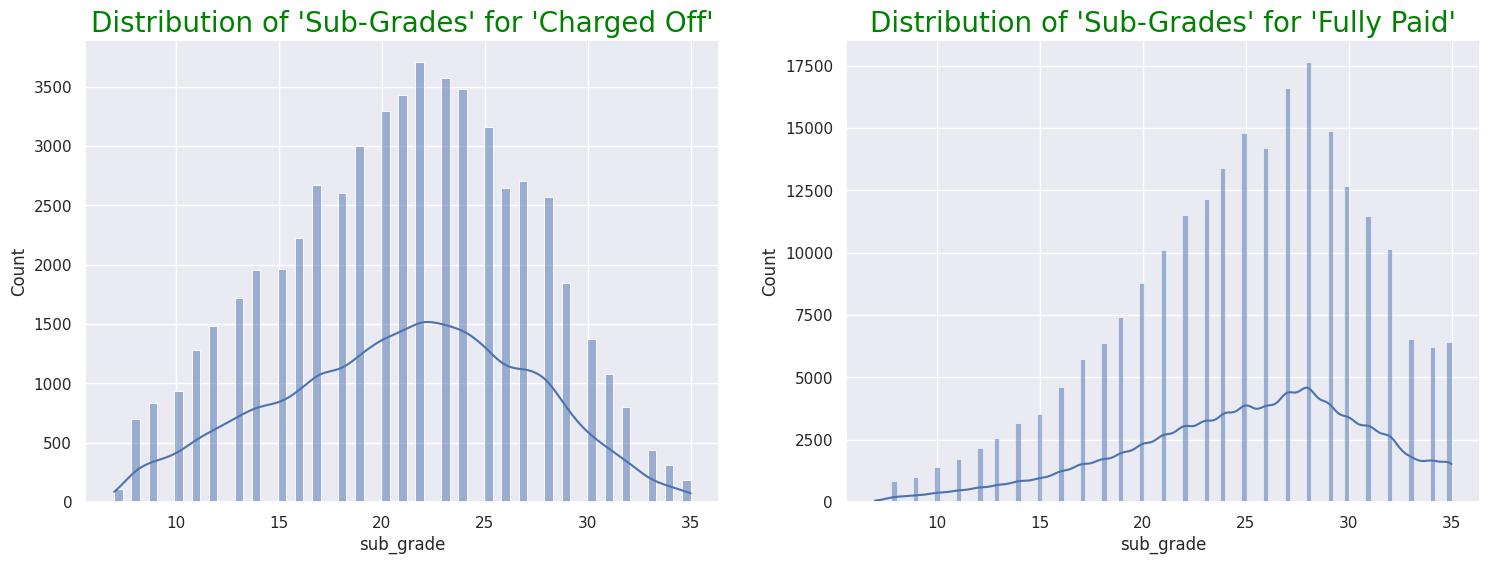

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(charged_off['sub_grade'], kde=True, ax=axes[0]).set_title("Distribution of 'Sub-Grades' for 'Charged Off'", fontsize=20, color="green")
sns.histplot(fully_paid['sub_grade'], kde=True, ax=axes[1]).set_title("Distribution of 'Sub-Grades' for 'Fully Paid'", fontsize=20, color="green")
plt.show()

**Even though, the distributions do not visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.**

In [ ]:
np.std(charged_off['sub_grade'])**2, np.std(fully_paid['sub_grade'])**2

(35.8342890220202, 34.16024074740056)

**Variances are roughly equal so proceeding further with 2 Sample T test.**

--------------------------------------------------------------------------------------------------
#### 8.3.1 Applying Unpaired T-Test
--------------------------------------------------------------------------------------------------

**H0** = The mean difference of 'Sub-Grades' between unpaired observations for 'Charged Off and Paid Off' loans is zero.

**H1** = The mean of 'Sub-Grades' for unpaired observations of 'Paid Off' loans is greater than 'Charged Off' loans.

**Significance Level (α)** = 0.05

In [ ]:
stats.ttest_ind(fully_paid['sub_grade'].sample(100), charged_off['sub_grade'].sample(100), equal_var=False,  alternative='greater')


TtestResult(statistic=6.540301461087706, pvalue=2.55923132050122e-10, df=197.95715347853323)

> **`Rejected Null hypothesis. This means that Sub-Grade has significant impact on Loan Status.`**


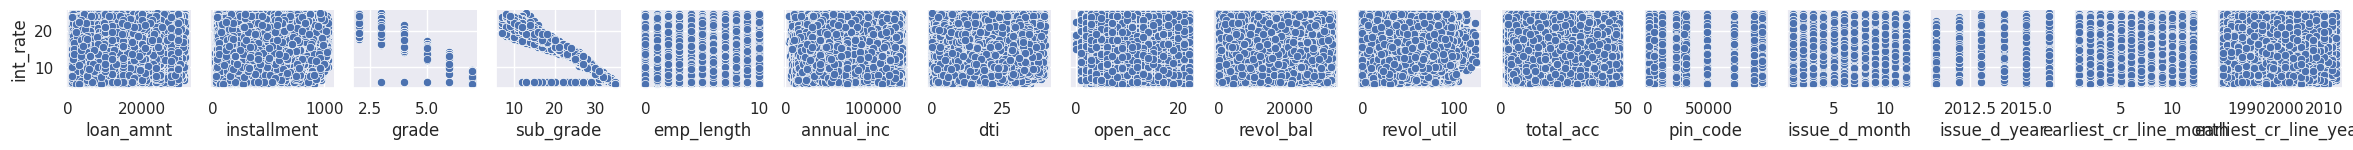

In [ ]:
sns.pairplot(data=df, y_vars=["int_rate"], x_vars=[c for c in get_columns_by_types(df, numeric_types) if c != 'int_rate'], height=1.5, aspect=1);

**As seen from the pairplot, all significant factors (Interest Rate, Grade and Sub-Grade) are highly correlated with each other. So keeping only one column from them and dropping rest of the correlated significant factors.**

In [ ]:
df = df.drop(['int_rate', 'grade'], axis=1)

**We can see that the Loan amount is highly correlated wth the Installments column. Hence we can drop the Installments column.**

In [ ]:
df = df.drop(['installment'], axis=1)

## 9. Feature Engineering and Feature Scaling

### 9.1 Applying One-Hot Encoding on Categorical Variables

In [ ]:
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
df['loan_status'] = df['loan_status'].astype('int64')
df_old = df.copy()

In [ ]:
for column in get_columns_by_types(df, categorical_types):
    if column == 'loan_status':
        continue
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop(column, inplace=True, axis=1)
    df.drop(df.columns[-1], inplace=True, axis=1)

### 9.2 Applying Target Encoding and Standard Scaling to the Train Data

In [ ]:
pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder

In [ ]:
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1), df['loan_status'], random_state=0, test_size = .2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size = .2)
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)
X_train_columns=X_train.columns
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)
X_train.head()

loan_amnt  sub_grade  emp_length  annual_inc   purpose       dti  open_acc  revol_bal  revol_util  total_acc  pin_code  issue_d_month  issue_d_year  earliest_cr_line_month  earliest_cr_line_year  emp_title_primary  emp_title_secondary   term_36  home_ownership_MORTGAGE  home_ownership_OTHER  home_ownership_OWN  verification_status_Not Verified  verification_status_Source Verified  application_type_DIRECT_PAY  application_type_INDIVIDUAL
0   1.687779  -0.526685   -0.150795    1.354838  0.511522  0.205422  1.866258   0.931654    1.531738    0.64127  1.416103      -1.625057      1.008342                0.065572               0.100194          -0.371778             0.000201  0.512392                -0.918576             -0.012624           -0.322765                         -0.728997                             1.404467                    -0.009946                     0.030935
1  -0.262794  -0.526685   -0.952665   -0.841514 -1.191757 -0.614344 -0.090210  -0.495340    0.544458   -0.08743 -0.133985       0.134390     -0.573520               -0.808981               0.794314          -0.573695             0.000201  0.512392                -0.918576             -0.012624           -0.322765                          1.371747                            -0.712014                    -0.009946                     0.030935
2  -0.338252   0.294950   -0.952665    2.073644  0.511522 -0.427467  1.132582  -0.340357    0.702756    1.47407 -1.300558      -1.331816      0.217411                1.523161              -1.635106           0.002757             0.000201  0.512392                -0.918576             -0.012624            3.098231                         -0.728997                             1.404467                    -0.009946                     0.030935
3  -0.957002  -1.512647   -0.418085   -0.601912  0.511522 -1.189925 -1.068445   0.035679    0.819397   -1.44073 -1.300558      -1.038575      1.799272                0.065572              -0.246866          -0.967727             0.000201  0.512392                 1.088642             -0.012624           -0.322765                         -0.728997                             1.404467                    -0.009946                     0.030935
4   0.567237   0.294950    1.185656   -0.362310  0.511522 -0.843580 -0.334769  -0.738826    0.140381    0.64127  1.416103      -0.745334     -0.573520               -1.100499              -1.288046          -0.573695             0.000201  0.512392                 1.088642             -0.012624           -0.322765                          1.371747                            -0.712014                    -0.009946                     0.030935

In [ ]:
X_train.shape, y_train.shape

((181996, 25), (181996,))

### 9.3 Applying Target Encoding and Standard Scaling to the Test and Validation Data.

In [ ]:
X_test = target_encoder.transform(X_test)
X_val = target_encoder.transform(X_val)
X_test_columns=X_test.columns
X_test_std=std.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)
X_val_columns=X_val.columns
X_val_std=std.transform(X_val)
X_val=pd.DataFrame(X_val_std, columns=X_val_columns)

## 10. Hyperparameter Tuning to decide best Regularization Parameter

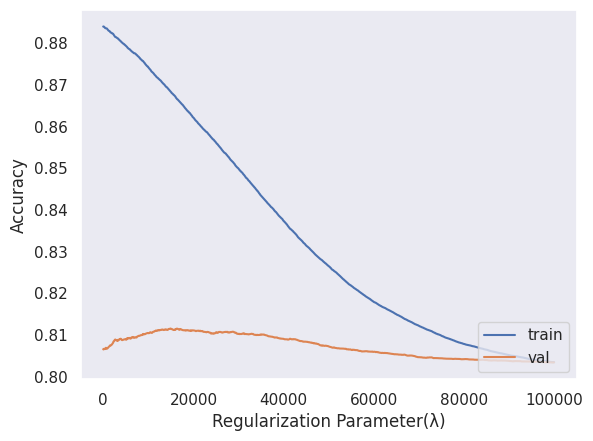

In [ ]:
train_scores = []
val_scores = []
for la in np.arange(0.01, 100000.0, 100):
    model= LogisticRegression(C=1/la)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)
plt.figure()
plt.plot(list(np.arange(0.01, 100000.0, 100)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 100000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')

plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [ ]:
np.max(val_scores), np.argmax(val_scores)

(0.8115164835164835, 149)

In [ ]:
l_best = 0.01 + np.argmax(val_scores) * 100
l_best

14900.01

**The best Regularization Parameter identified is 10800.01**

## 11. Training the Logistic Regression model

In [ ]:
model= LogisticRegression(C=1/l_best)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

In [ ]:
print(f"Training Score is {round(train_score, 4)}")
print(f"Validation Score is {round(val_score, 4)}")
print(f"Test Score is {round(test_score, 4)}")

Training Score is 0.8684
Validation Score is 0.8115
Test Score is 0.811


In [ ]:
print(f"Model intercept is {model.intercept_}")

Model intercept is [-1.75863165]


In [ ]:
pd.DataFrame(np.vstack([X_train.columns, model.coef_]).T, columns=['Feature', 'Model Coefficient']).sort_values(by='Model Coefficient', ascending=False)


Feature Model Coefficient
15                    emp_title_primary          0.815286
10                             pin_code          0.463494
5                                   dti          0.108468
8                            revol_util          0.087332
0                             loan_amnt           0.07101
6                              open_acc          0.062997
4                               purpose          0.036054
22  verification_status_Source Verified          0.029286
14                earliest_cr_line_year          0.027589
24          application_type_INDIVIDUAL          0.013863
16                  emp_title_secondary          0.009345
19                 home_ownership_OTHER          0.004393
12                         issue_d_year          0.003705
23          application_type_DIRECT_PAY          0.000282
13               earliest_cr_line_month         -0.003899
7                             revol_bal         -0.004323
2                            emp_length         -0.006581
20                   home_ownership_OWN         -0.019546
9                             total_acc         -0.021107
11                        issue_d_month         -0.021596
21     verification_status_Not Verified         -0.035077
3                            annual_inc         -0.051391
18              home_ownership_MORTGAGE          -0.07993
17                              term_36         -0.137025
1                             sub_grade          -0.24632

**From the model coefficients we can deduce that 'pin_code' has the most impact on the 'Loan Status' followed by the 'Primary Employee Title' and 'Sub-Grade' features.**

## 12. Confusion Matrix


Confusion Matrix
 [[44554  1221]
 [ 9527  1572]] 



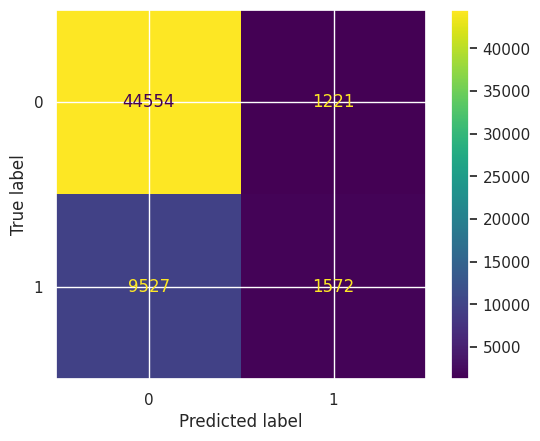

In [ ]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

In [ ]:
print(f"Precision Score is {precision_score(y_test, y_pred)}")
print(f"Recall Score is {recall_score(y_test, y_pred)}")
print(f"F1 Score is {f1_score(y_test, y_pred)}")

Precision Score is 0.5628356605800214
Recall Score is 0.14163438147580862
F1 Score is 0.22631730492369706


**From the confusion matrix we can dedue that there are high number of False Negatives.**

**Need to fix imbalance in target variable so as to reduce False Negatives.**

## 13. Treat Target Variable Imbalance

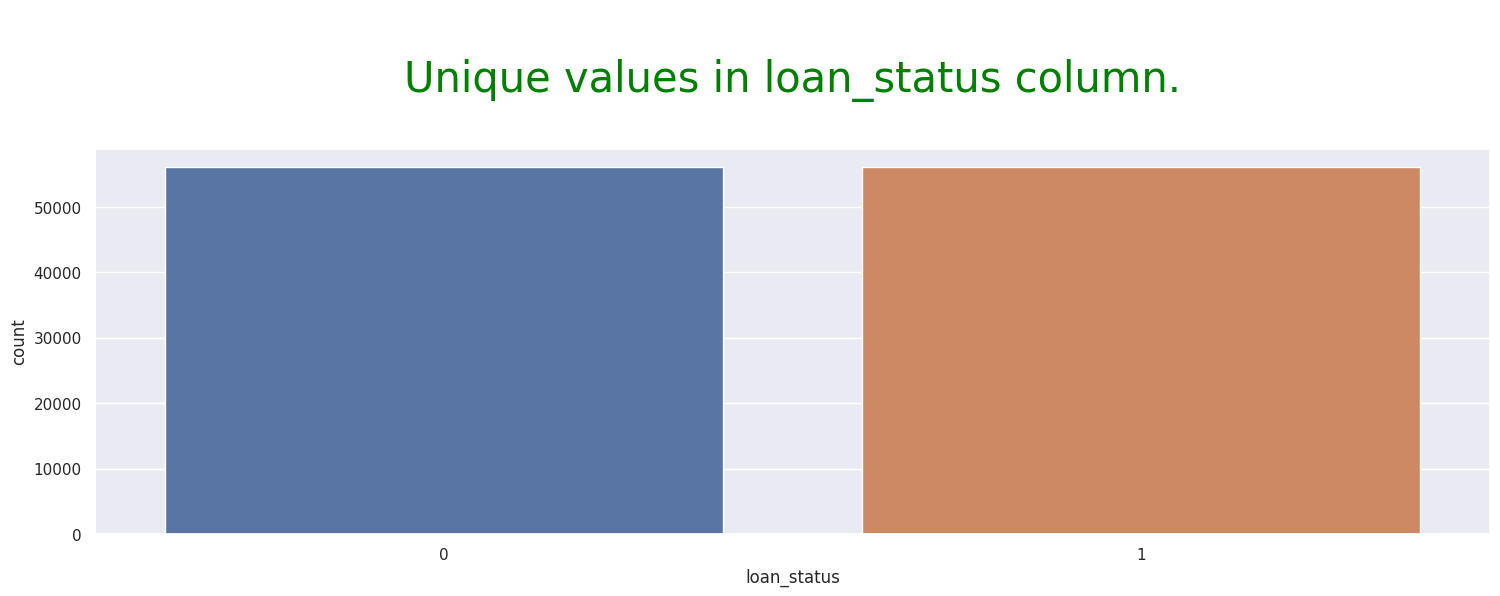

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = undersample.fit_resample(df_old.drop('loan_status', axis=1), df_old['loan_status'])
df = pd.concat([X_over, y_over], axis=1)
fig, axes = plt.subplots(figsize=(18,5))
sns.countplot(data=df, x='loan_status')
plt.title(f"\nUnique values in loan_status column.\n", fontsize=30, color="green")
plt.show()

## 14. Feature Engineering and Feature Scaling

In [ ]:
for column in get_columns_by_types(df, categorical_types):
    if column == 'loan_status':
        continue
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop(column, inplace=True, axis=1)
    df.drop(df.columns[-1], inplace=True, axis=1)

In [ ]:
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1), df['loan_status'], random_state=0, test_size = .2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size = .2)

In [ ]:
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)

In [ ]:
X_train_columns=X_train.columns
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)

In [ ]:
X_test = target_encoder.transform(X_test)
X_val = target_encoder.transform(X_val)

In [ ]:
X_test_columns=X_test.columns
X_test_std=std.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)
X_val_columns=X_val.columns
X_val_std=std.transform(X_val)
X_val=pd.DataFrame(X_val_std, columns=X_val_columns)

## 15. Hyperparameter Tuning to decide best Regularization Parameter

In [ ]:
train_scores = []
val_scores = []
for la in np.arange(0.01, 100000.0, 100):
    model= LogisticRegression(C=1/la)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

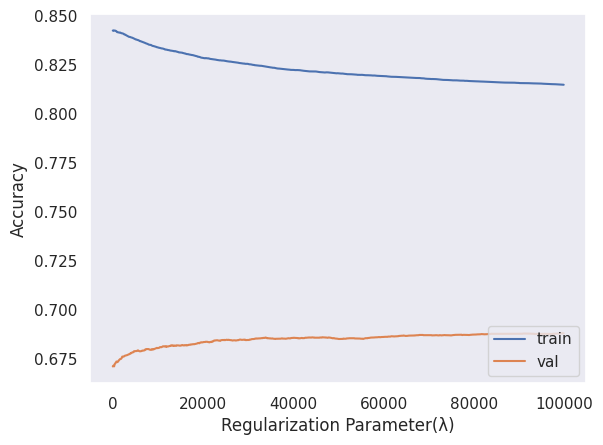

In [ ]:
plt.figure()
plt.plot(list(np.arange(0.01, 100000.0, 100)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 100000.0, 100)), val_scores, label="val")
plt.legend(loc='lower right')

plt.xlabel("Regularization Parameter(λ)")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [ ]:
np.max(val_scores), np.argmax(val_scores)

(0.6881061197190949, 994)

In [ ]:
l_best = 0.01 + np.argmax(val_scores) * 100
l_best

99400.01

**The best Regularization Parameter identified is 1700.01**

## 15. Training the Logistic Regression model

In [ ]:
model= LogisticRegression(C=1/l_best)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

In [ ]:
print(f"Training Score is {round(train_score, 4)}")
print(f"Validation Score is {round(val_score, 4)}")
print(f"Test Score is {round(test_score, 4)}")

Training Score is 0.8149
Validation Score is 0.6881
Test Score is 0.6918


In [ ]:
pd.DataFrame(np.vstack([X_train.columns, model.coef_]).T, columns=['Feature', 'Model Coefficient']).sort_values(by='Model Coefficient', ascending=False)

Feature Model Coefficient
15                    emp_title_primary          0.175459
10                             pin_code          0.109876
5                                   dti          0.039001
8                            revol_util          0.027373
0                             loan_amnt          0.021848
12                         issue_d_year          0.015747
4                               purpose          0.015647
14                earliest_cr_line_year           0.01294
22  verification_status_Source Verified          0.011666
6                              open_acc          0.009715
24          application_type_INDIVIDUAL          0.003111
16                  emp_title_secondary          0.002547
7                             revol_bal          0.001596
20                   home_ownership_OWN          0.000873
23          application_type_DIRECT_PAY          0.000584
13               earliest_cr_line_month          0.000541
19                 home_ownership_OTHER          0.000164
11                        issue_d_month         -0.005892
2                            emp_length         -0.007117
9                             total_acc         -0.008089
18              home_ownership_MORTGAGE            -0.021
21     verification_status_Not Verified         -0.025712
3                            annual_inc         -0.028718
17                              term_36         -0.049635
1                             sub_grade          -0.07995

**From the model coefficients we can deduce that 'pin_code' has the most impact on the 'Loan Status' followed by the 'Primary Employee Title' and 'Loan Sub-Grade' features.**

## 16. Classification Report (Confusion Matrix)

In [ ]:
y_pred = model.predict(X_test)


Confusion Matrix
 [[7919 3252]
 [3661 7595]] 



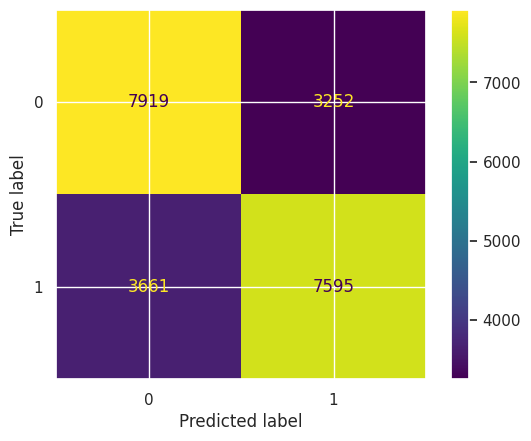

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

In [ ]:
print(f"Precision Score is {precision_score(y_test, y_pred)}")
print(f"Recall Score is {recall_score(y_test, y_pred)}")
print(f"F1 Score is {f1_score(y_test, y_pred)}")

Precision Score is 0.7001936019175808
Recall Score is 0.6747512437810945
F1 Score is 0.6872370266479664


## 17. Percision-Recall Curve

In [ ]:
y_score = model.predict_proba(X_test)[:, 1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

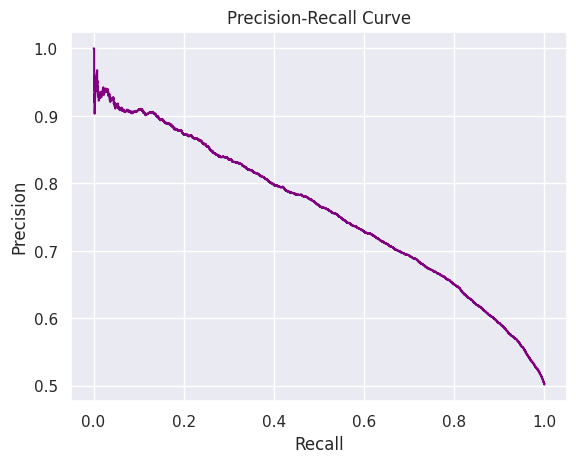

In [ ]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [ ]:
print(f"Area under precision Recall curve is {auc(recall, precision)}")

Area under precision Recall curve is 0.7578500420917983


## 18. ROC-AUC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

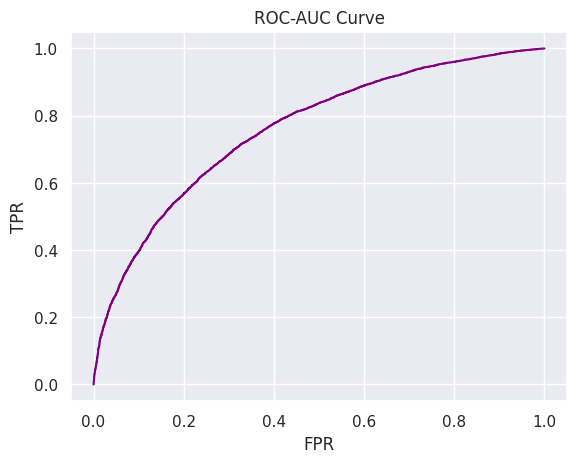

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')
ax.set_title('ROC-AUC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
plt.show()

In [ ]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.7603498725027751


## 19. Accuracy-Threshold Curve

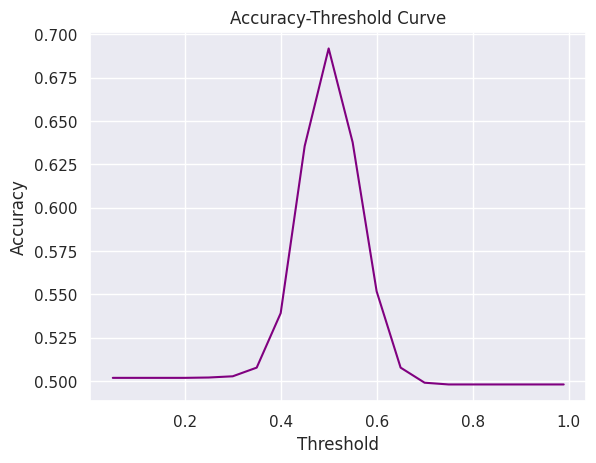

In [ ]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [round((y_pred == y_test).sum()/y_pred.shape[0], 4)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
plt.show()

In [ ]:
np.max(scores), np.argmax(scores)

(0.6918, 9)

In [ ]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.5


## 20. F1-Score-Threshold Curve

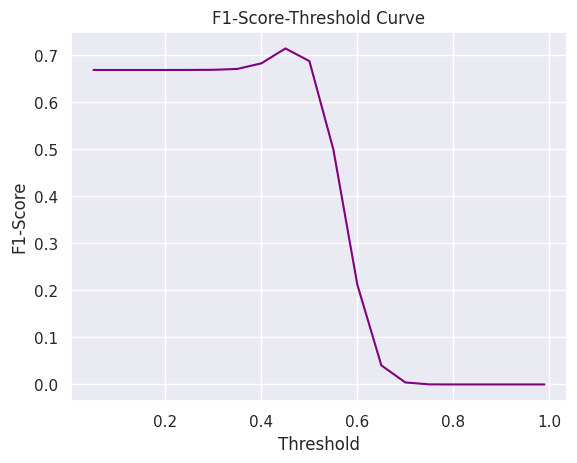

In [ ]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [f1_score(y_test, y_pred)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('F1-Score-Threshold Curve')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Threshold')
plt.show()

In [ ]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.7603498725027751


In [ ]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.45


## 21. Tradeoff Questions

### 21.1 **How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.**

1.   High number of False Positives or False Negatives can result from imbalance in the data. We have handled this case in section 15, by using undersampling technique to reduce imbalance in data.
2.   False Positives can be reduced and as a result model accuracy can be increased by choosing the best performing Regularization Parameter. We have handled this case in section 17, by using Hyperparameter Tuning.
3.   False Positives can also be reduced by increasing the threshold value. In the Accuracy-Threshold Curve we can see that the best performing threshold is 0.5 and if we increase our threshold value beyond that, the accuracy decreases. So, if we try to increase our threshold beyond 0.5, the number of False Positives might reduce but the number of False Nagatives will increase and True Positives will decrease.

For example, following is the Confusion Matrix resulted from using threshold value of 0.55 instead of 0.5.


Confusion Matrix
 [[10254   917]
 [ 7208  4048]] 



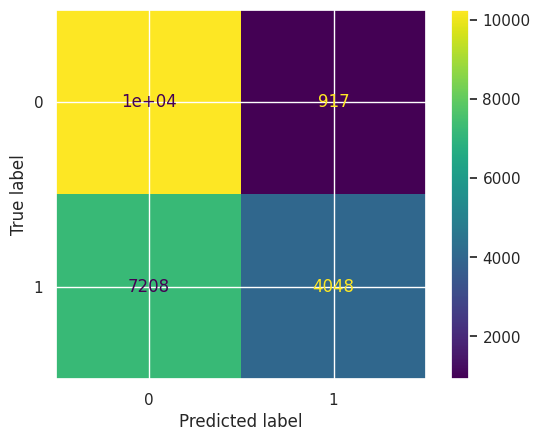

In [ ]:
y_pred = np.vectorize(lambda x: 1 if x>0.55 else 0)(y_score)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

### 21.2 **Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.**

1. Not disbursing loans at all would stop earnings through the interests and might result in the stunted growth. The crux of the problem is high number of False nagatives. If we manage to reduce False Negatives significantly, we can bear minimum losses and still keep on disbursing loans.
2. Steps to reduce False Nagatives are smilar to the steps we discussed for False Positive Reduction.
3. False Nagatives can also be reduced by decreasing the threshold value. In the Accuracy-Threshold Curve we can see that the best performing threshold is 0.5 and if we decrease our threshold value beyond that, the accuracy decreases. So, if we try to decrease our threshold beyond 0.5, the number of False Negatives might reduce but the number of False Positives will increase and True Negatives will decrease.

For example, following is the Confusion Matrix resulted from using threshold value of 0.45 instead of 0.5.


Confusion Matrix
 [[ 4041  7130]
 [ 1045 10211]] 



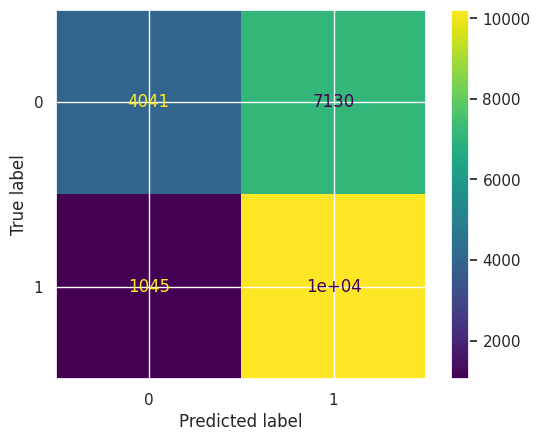

In [ ]:
y_pred = np.vectorize(lambda x: 1 if x>0.45 else 0)(y_score)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix\n", conf_matrix, "\n")
ConfusionMatrixDisplay(conf_matrix).plot();

We just saw how decreasing False Positives might increase False Negatives. And decreasing False Negatives might increase False Positives. Since, the business wants to reduce both, we can
1. Go with the optimal threshold value detected keeping the balance between False Positives and False Nagatives as it its.
2. Go with another machine learning model which might yield better results.

## 22. Questionnaire

### 22.1 **What percentage of customers have fully paid their Loan Amount?**

Ans: 80.3%

### 22.2 **Comment about the correlation between Loan Amount and Installment features.**

Ans. The correlation between Loan Amount and Installment is very high (0.95). Since, these columns would introduce multicollinearity, we have removed Installment column from our model.

### 22.3 **The majority of people have home ownership as _______.**

Ans. Mortgage

### 22.4 **People with grades ‘A’ are more likely to fully pay their loan. (T/F)**

Ans. True

### 22.5 **Name the top 2 afforded job titles.**

Ans. Teacher and Manager

### 22.6 **Thinking from a bank's perspective, which metric should our primary focus be on.**
- ROC AUC
- Precision
- Recall
- F1 Score**

Ans. Thinking from a bank's perspective, our goal is to reduce both False Positives and False Negatives. Precision penalizes only the False Positives and Recall penalizes False Negatives. But, F1-Score takes into account both the Precision as well as Recall score. Hence, we should primarily focus on the F1-Score metric.


### 22.7 **How does the gap in precision and recall affect the bank?**

Ans. Recall score is 0.79 and Precision score is 0.80. Which tells us that the number of False Positives is roughly same as the number of False Negatives. If Recall value is low (False Negatives are high), it means that the Bank is loosing in opportunity cost. If Precision value is low (False Positives are high), it means that the Bank's NPA (defaulters) may increase.

### 22.8 **Which were the features that heavily affected the outcome?**

Ans. Pin Code is the most significant feature followed by emp_title_primary, sub_grade, title, term_months_36. Since, we removed Grade and Interest Rate which were highly correlated with sub_grade, they're also equally significant features.

### 22.9 **Will the results be affected by geographical location? (Yes/No)**

Ans. Yes. The results are highly affected by Pin Code.

## Inferences and Report :

- 396030 data points , 26 features , 1 label.

- 80% belongs to the class 0 : which is loan fully paid.
- 20% belongs to the class 1 : which were charged off.

- Loan Amount distribution / media is slightly higher for Charged_off loanStatus.

- Probability of CHarged_off status is higher in case of 60 month term.

- Interest Rate mean and media is higher for Charged_off LoanStatus.

- Probability of Charged_off LoanStatus is higher for Loan Grades are E ,F, G.
- G grade has the highest probability of having defaulter.
- Similar pattern is visible in sub_grades probability plot.

- Employement Length has overall same probability of Loan_status as fully paid and defaulter.
- That means Defaulters has no relation with their Emoployement length.

- For those borrowers who have rental home, has higher probability of defaulters.
- borrowers having their home mortgage and owns have lower probability of defaulter.

- Annual income median is lightly higher for those who's loan status is as fully paid.

- Somehow , verified income borrowers probability of defaulter is higher than those who are not verified by loan tap.

- Most of the borrowers take loans for dept-consolidation and credit card payoffs.
- the probability of defaulters is higher in the small_business owner borrowers.

- debt-to-income ratio is higher for defaulters.

- number of open credit lines in the borrowers credit file is same as for loan status as fully paid and defaulters.

- Number of derogatory public records increases , the probability of borrowers declared as defaulters also increases
- aspecially for those who have higher than 12 public_records.

- Total credit revolving balance is almost same for both borrowers who had fully paid loan and declared defaulter
- but Revolving line utilization rate is higher for defaulter borrowers.

- Application type Direct-Pay has higher probability of defaulter borrowers than individual and joint.

- Number of public record bankruptcies increasaes ,   higher the probability of defaulters.

- Most important features/ data for prediction , as per Logistic Regression, Decision tree classifier and Random Forest  model are : Employee Title, Loan Grade and Sub-Grade, Interest rate and dept-to-income ratio.







## 24. Actionable Insights & Recommendations
-  We should try to keep the precision higher as possible compare to recall , and keep the false positive low.
- that will help not to missout the opportopportunity to finance more individuals and earn interest on it. This we can achieve by setting up the higher threshold.  
- Giving loans to those even having slightly higher probability of defaulter, we can maximise the earning , by this risk taking method.

- and Since NPA is a real problem in the industry  , Company should more investigate and check for the proof of assets. Since it was observed in probability plot,  verified borrowers had higher probability of defaulters than non-varified.
- Giving loans to those who have no mortgage house of any owned property have higher probability of defaulter , giving loan to this category borrowers can be a problem of NPA.

- Majority of the applications of are type Individual.
- Most loans are for term length 36 months instead of 60 months.
- Loans with higher interest rates have more cases of defaulting.
- Loans with higher Grades/Sub-Grades have less cases of defaulting.
- Most of the loans funded after 2014 have initial list status as W instead of F
- Loans with Direct Pay applications have higher interest rates, higer dti ratio and lower grades/sub_grades.
- Loans with tenure of 60 months have higher loan amounts, higher interest rates, but lower grades/sub-grades.
- Grade, Sub-Grade and Interest Rates have very high correlation between them.
- Logistic Regression Model with the imbalanced data has high accuracy of .88, high precision of 0.96 but low recall score of 0.43.
- After fixing imbalanced data, we get slightly lower accuracy of 0.79, lower precision of 0.80, but we get much higher recall score of 0.79, improving our model significantly.
- F1 Score before fixing imbalance was 0.60, but after fixing imbalance we get F1 Score of 0.79.
- Area under ROC-AUC curve is 90%.
- The best Regularization Parameter (lambda) identified for our model is 1700.01..
- To predict Loan Status, the columns pin_code, emp_title_primary, int_rate, grade sub_grade, title, term_months_36 should be considered.
- While disbursing loans, banks should check address and locality of a person since some geographical locations have higher rates of defaulting compared to others.
- While disbursing loans, banks should also check profession of a person since some professions have higher rates of defaulting compared to others.
- Loantap designated Grade and Sub-Grade to the loan has high impact on loan status. So the banks should avoid disbursing loans with bad grade or sub-grade.
- Factors such as Monthly income, age, current debt should also be considered and tested for their effect on the 'Loan Status' for improving the prediction model.
